https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators  
For what purpose was the dataset created?

* To better understand the relationship between  lifestyle and diabetes in the US

Who funded the creation of the dataset?

* The CDC

What do the instances in this dataset represent?

* Each row represents a person participating in this study.

Are there recommended data splits?

* Cross validation or a fixed train-test split could be used.

Does the dataset contain data that might be considered sensitive in any way?

- Gender
- Income
- Education level

Was there any data preprocessing performed?

* Bucketing of age

Additional Information

* Dataset link: https://www.cdc.gov/brfss/annual_data/annual_2014.html

Has Missing Values?

* No  

diabetes _ binary _ health _ indicators _ BRFSS2015.csv is a clean dataset of 253,680 survey responses to the CDC's BRFSS2015. The target variable Diabetes_binary has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes. This dataset has 21 feature variables and is not balanced.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing

import shap

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import F1Score, Recall, AUC

import statsmodels.formula.api as smf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
def scores(_y_val, _y_pred):
    tn, fp, fn, tp = confusion_matrix(_y_val, _y_pred).ravel()
    specificity = tn / (tn+fp)
    print("Accuracy: ", round(accuracy_score(_y_val, _y_pred), 2)) 
    print("Specificity: ", round(tn / (tn+fp), 2)) 
    print("Recall: ", round(recall_score(_y_val, _y_pred), 2)) 
    print("F1 Score:", round(f1_score(_y_val, _y_pred), 2))

## Phase 1: Data Analysis and Preparation  

* Once you have found a dataset you like
* load the data in a Python Notebook
* normalize your data. CANNOT DO THIS UNTIL DATA IS SPLIT.
* In your report’s introduction section please discuss:
    - why you chose to work on this project
    - explain the problem you plan to solve.
    - mention the source of your dataset.

        
* visualize/plot the distributions of each input feature and discuss the range of the values (min, max, mean, median, etc.). For example, plot histograms showing distribution of each input features. Selected visualizations should be included in the report.

* Discuss the distribution of the output labels.
* Check if the data is imbalanced by calculating what percentage of the output labels are 0 and what percentage are 1. If your dataset is heavily imbalanced (for example, 1% vs 99%) it may be a better idea to choose a different dataset. 

In [3]:
df_full = pd.read_csv("diabetes.csv")

In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [5]:
df_full.head(3).transpose()

0     1     2
Diabetes_binary        0.0   0.0   0.0
HighBP                 1.0   0.0   1.0
HighChol               1.0   0.0   1.0
CholCheck              1.0   0.0   1.0
BMI                   40.0  25.0  28.0
Smoker                 1.0   1.0   0.0
Stroke                 0.0   0.0   0.0
HeartDiseaseorAttack   0.0   0.0   0.0
PhysActivity           0.0   1.0   0.0
Fruits                 0.0   0.0   1.0
Veggies                1.0   0.0   0.0
HvyAlcoholConsump      0.0   0.0   0.0
AnyHealthcare          1.0   0.0   1.0
NoDocbcCost            0.0   1.0   1.0
GenHlth                5.0   3.0   5.0
MentHlth              18.0   0.0  30.0
PhysHlth              15.0   0.0  30.0
DiffWalk               1.0   0.0   1.0
Sex                    0.0   0.0   0.0
Age                    9.0   7.0   9.0
Education              4.0   6.0   4.0
Income                 3.0   1.0   8.0

In [6]:
df_full.describe().transpose()

count       mean       std   min   25%   50%   75%  \
Diabetes_binary       253680.0   0.139333  0.346294   0.0   0.0   0.0   0.0   
HighBP                253680.0   0.429001  0.494934   0.0   0.0   0.0   1.0   
HighChol              253680.0   0.424121  0.494210   0.0   0.0   0.0   1.0   
CholCheck             253680.0   0.962670  0.189571   0.0   1.0   1.0   1.0   
BMI                   253680.0  28.382364  6.608694  12.0  24.0  27.0  31.0   
Smoker                253680.0   0.443169  0.496761   0.0   0.0   0.0   1.0   
Stroke                253680.0   0.040571  0.197294   0.0   0.0   0.0   0.0   
HeartDiseaseorAttack  253680.0   0.094186  0.292087   0.0   0.0   0.0   0.0   
PhysActivity          253680.0   0.756544  0.429169   0.0   1.0   1.0   1.0   
Fruits                253680.0   0.634256  0.481639   0.0   0.0   1.0   1.0   
Veggies               253680.0   0.811420  0.391175   0.0   1.0   1.0   1.0   
HvyAlcoholConsump     253680.0   0.056197  0.230302   0.0   0.0   0.0   0.0   
AnyHealthcare         253680.0   0.951053  0.215759   0.0   1.0   1.0   1.0   
NoDocbcCost           253680.0   0.084177  0.277654   0.0   0.0   0.0   0.0   
GenHlth               253680.0   2.511392  1.068477   1.0   2.0   2.0   3.0   
MentHlth              253680.0   3.184772  7.412847   0.0   0.0   0.0   2.0   
PhysHlth              253680.0   4.242081  8.717951   0.0   0.0   0.0   3.0   
DiffWalk              253680.0   0.168224  0.374066   0.0   0.0   0.0   0.0   
Sex                   253680.0   0.440342  0.496429   0.0   0.0   0.0   1.0   
Age                   253680.0   8.032119  3.054220   1.0   6.0   8.0  10.0   
Education             253680.0   5.050434  0.985774   1.0   4.0   5.0   6.0   
Income                253680.0   6.053875  2.071148   1.0   5.0   7.0   8.0   

                       max  
Diabetes_binary        1.0  
HighBP                 1.0  
HighChol               1.0  
CholCheck              1.0  
BMI                   98.0  
Smoker                 1.0  
Stroke                 1.0  
HeartDiseaseorAttack   1.0  
PhysActivity           1.0  
Fruits                 1.0  
Veggies                1.0  
HvyAlcoholConsump      1.0  
AnyHealthcare          1.0  
NoDocbcCost            1.0  
GenHlth                5.0  
MentHlth              30.0  
PhysHlth              30.0  
DiffWalk               1.0  
Sex                    1.0  
Age                   13.0  
Education              6.0  
Income                 8.0

In [7]:
df_full.Diabetes_binary.value_counts(normalize=True).round(2)

Diabetes_binary
0.0    0.86
1.0    0.14
Name: proportion, dtype: float64

In [8]:
df_full.Diabetes_binary.value_counts()

Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64

In [9]:
cats = list(df_full.describe().transpose().loc[df_full.describe().transpose()['max']==1.0].transpose().columns)

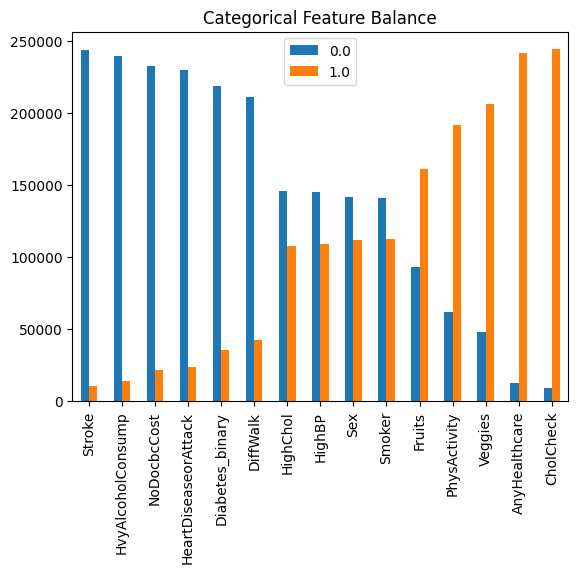

In [10]:
df_full.apply(pd.Series.value_counts).iloc[0:2,:].loc[:,cats].transpose().dropna().astype(int).sort_values(by=1.0).plot(kind='bar')
plt.title("Categorical Feature Balance")
plt.show()

In [11]:
numeric_cols = list(df_full.drop(labels=cats, axis=1).columns)
numeric_cols

['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

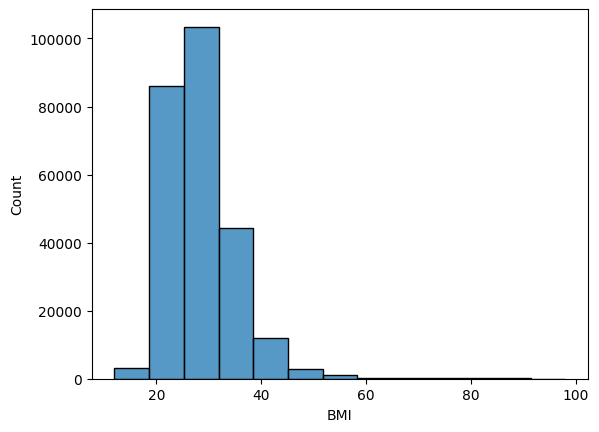

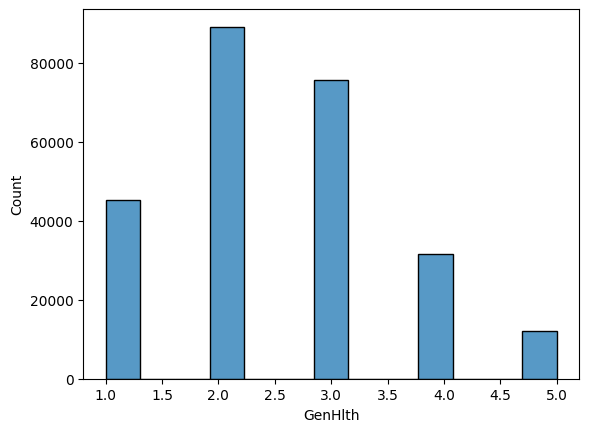

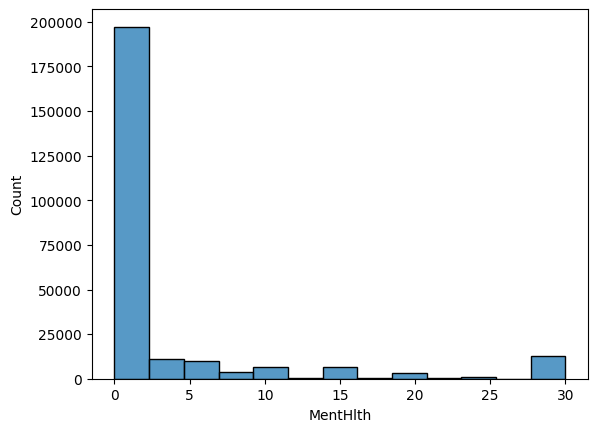

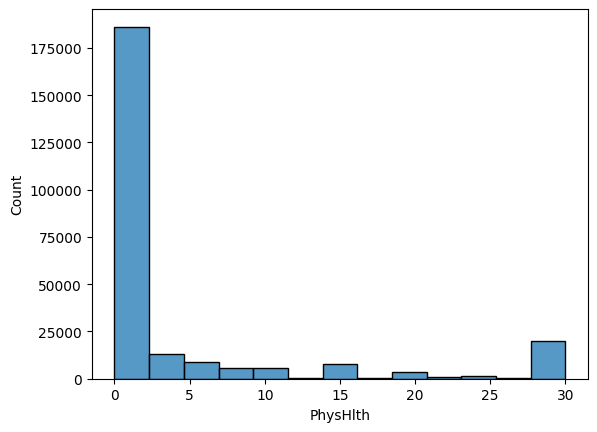

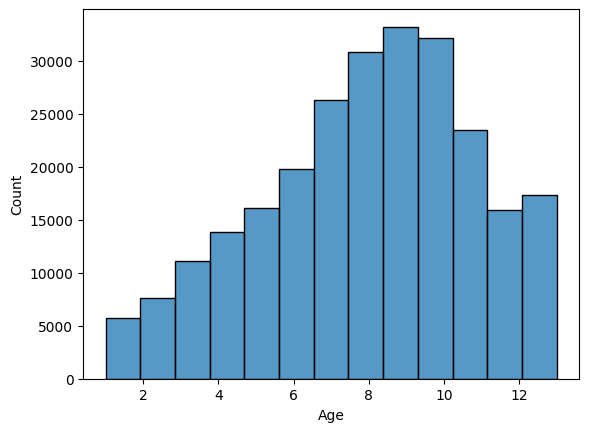

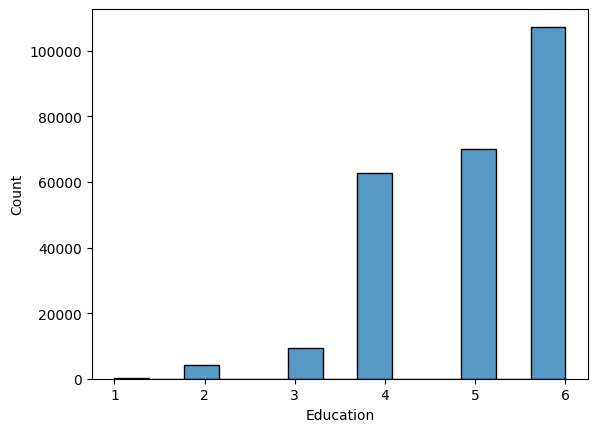

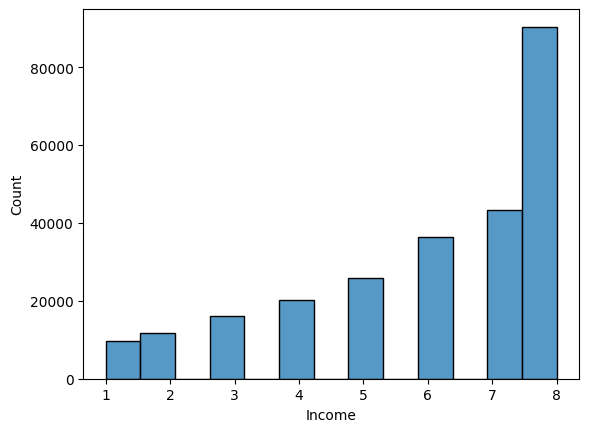

In [12]:
for column in numeric_cols:
    sns.histplot(data = df_full, x=column, bins=13)
    plt.show()


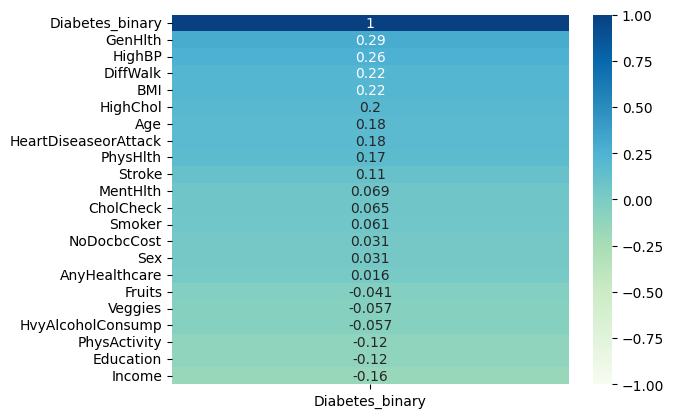

In [13]:
# Plotting the heatmap to check the correlation between the Target Label and other features
sns.heatmap(df_full.corr()[['Diabetes_binary']].sort_values(by='Diabetes_binary', ascending=False), vmin=-1, vmax=1, annot=True, cmap='GnBu')
plt.show()

### Stratified Draw of 10000 Samples

In [16]:
mask_0 = df_full["Diabetes_binary"] == 0
mask_1 = df_full["Diabetes_binary"] == 1
df_0 = df_full.loc[mask_0].copy().sample(5000)
df_1 = df_full.loc[mask_1].copy().sample(5000)
df = pd.concat([df_0, df_1])
df = df.copy().sample(frac=1)
df.describe().transpose()

count     mean        std   min   25%   50%   75%  \
Diabetes_binary       10000.0   0.5000   0.500025   0.0   0.0   0.5   1.0   
HighBP                10000.0   0.5666   0.495569   0.0   0.0   1.0   1.0   
HighChol              10000.0   0.5339   0.498874   0.0   0.0   1.0   1.0   
CholCheck             10000.0   0.9757   0.153987   0.0   1.0   1.0   1.0   
BMI                   10000.0  29.8117   7.081176  14.0  25.0  29.0  33.0   
Smoker                10000.0   0.4788   0.499575   0.0   0.0   0.0   1.0   
Stroke                10000.0   0.0622   0.241531   0.0   0.0   0.0   0.0   
HeartDiseaseorAttack  10000.0   0.1493   0.356402   0.0   0.0   0.0   0.0   
PhysActivity          10000.0   0.7043   0.456380   0.0   0.0   1.0   1.0   
Fruits                10000.0   0.6111   0.487525   0.0   0.0   1.0   1.0   
Veggies               10000.0   0.7866   0.409728   0.0   1.0   1.0   1.0   
HvyAlcoholConsump     10000.0   0.0418   0.200142   0.0   0.0   0.0   0.0   
AnyHealthcare         10000.0   0.9551   0.207095   0.0   1.0   1.0   1.0   
NoDocbcCost           10000.0   0.0976   0.296788   0.0   0.0   0.0   0.0   
GenHlth               10000.0   2.8397   1.107125   1.0   2.0   3.0   4.0   
MentHlth              10000.0   3.7072   8.093109   0.0   0.0   0.0   2.0   
PhysHlth              10000.0   5.8286  10.067530   0.0   0.0   0.0   6.0   
DiffWalk              10000.0   0.2559   0.436388   0.0   0.0   0.0   1.0   
Sex                   10000.0   0.4654   0.498826   0.0   0.0   0.0   1.0   
Age                   10000.0   8.6223   2.857877   1.0   7.0   9.0  11.0   
Education             10000.0   4.9131   1.034531   1.0   4.0   5.0   6.0   
Income                10000.0   5.6908   2.162328   1.0   4.0   6.0   8.0   

                       max  
Diabetes_binary        1.0  
HighBP                 1.0  
HighChol               1.0  
CholCheck              1.0  
BMI                   95.0  
Smoker                 1.0  
Stroke                 1.0  
HeartDiseaseorAttack   1.0  
PhysActivity           1.0  
Fruits                 1.0  
Veggies                1.0  
HvyAlcoholConsump      1.0  
AnyHealthcare          1.0  
NoDocbcCost            1.0  
GenHlth                5.0  
MentHlth              30.0  
PhysHlth              30.0  
DiffWalk               1.0  
Sex                    1.0  
Age                   13.0  
Education              6.0  
Income                 8.0

## Phase 2: Build a Model to Overfit the Entire Dataset

The main goal in this phase is to experiment and find what network size is needed to ‘overfit’ the entire dataset at your hand.  

* Do not split your data into training and validation.  

* The place to start is to use ‘logistic regression’ model and train for as many epochs as needed to obtain as high accuracy as possible. 
After training hundreds of epochs if you observe that the accuracy is not increasing then it implies that the number of neurons in your model (only one) may not be sufficient for overfitting.  

* The next step is to grow your model into a multi-layer model and add a few neurons (say only 2) in the input layer. This way your model will have ‘2 + 1 = 3’ neurons in total.
* If your accuracy still does not each a 100% or close to 100% you can continue to increase the number of layers and number of neurons.
* Once you have obtained 100% accuracy (or around 100%) your experiments for this phase are complete.

The results of this experiment also inform us that our final model (in subsequent phases) should be smaller than this model. 

### Standardize Numeric Data and Prepare for Use in ML Models

In [18]:
def robust_data_scaling(data):
    p_25, median, p_75 = data.quantile([.25, .5, .75])   
    return (data - median)/(p_75 - p_25)

In [19]:
df_2 = df.copy().sample(frac=1)

In [20]:
for column in numeric_cols:
    df_2[column] = robust_data_scaling(df_2[column])

In [21]:
df_2[numeric_cols].describe().transpose()

count      mean       std    min  25%  50%  75%    max
BMI        10000.0  0.101462  0.885147 -1.875 -0.5  0.0  0.5   8.25
GenHlth    10000.0 -0.080150  0.553563 -1.000 -0.5  0.0  0.5   1.00
MentHlth   10000.0  1.853600  4.046555  0.000  0.0  0.0  1.0  15.00
PhysHlth   10000.0  0.971433  1.677922  0.000  0.0  0.0  1.0   5.00
Age        10000.0 -0.094425  0.714469 -2.000 -0.5  0.0  0.5   1.00
Education  10000.0 -0.043450  0.517266 -2.000 -0.5  0.0  0.5   0.50
Income     10000.0 -0.077300  0.540582 -1.250 -0.5  0.0  0.5   0.50

In [22]:
X = df_2.drop(axis=1, labels='Diabetes_binary')
y = df_2['Diabetes_binary']

In [23]:
callback_a = ModelCheckpoint(filepath = 'my_best_model.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='accuracy', mode='max', patience=100, verbose=1)

In [24]:
# https://jscommands.com/using-multiprocessing-with-keras-and-tensorflow-in-python/

In [42]:
models = []
model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], activation='sigmoid'))
models.append((model, X, y, callback_b))

for i in range(5):
    model = Sequential()
    model.add(Dense(22, input_dim=X.shape[1], activation='elu'))
    for j in range(i):
        model.add(Dense(22, activation='elu'))
        
    model.add(Dense(1, activation='sigmoid'))
    models.append((model, X, y, [callback_b]))

In [46]:
from funcs import train_model

In [47]:
pool = multiprocessing.Pool()
history = pool.starmap(train_model, models)
pool.close()
pool.join()

Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.8489 - recall: 0.5998 - accuracy: 0.5929 - auc: 0.6243
Epoch 2/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.8238 - recall: 0.5700 - accuracy: 0.6013 - auc: 0.6349
Epoch 3/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6737 - recall: 0.6952 - accuracy: 0.5937 - auc: 0.6310
Epoch 2/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.8017 - recall: 0.5508 - accuracy: 0.6075 - auc: 0.6457
Epoch 4/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.7257 - recall: 0.3194 - accuracy: 0.5699 - auc: 0.5697
Epoch 2/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.6138 - recall: 0.6926 - accuracy: 0.6698 - auc: 0.7256
Epoch 3/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.7815 - recall: 0.5466 - accuracy: 0.6146 - auc: 0.6567
Epoch 5/1000
20/20

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 1)                 22        
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


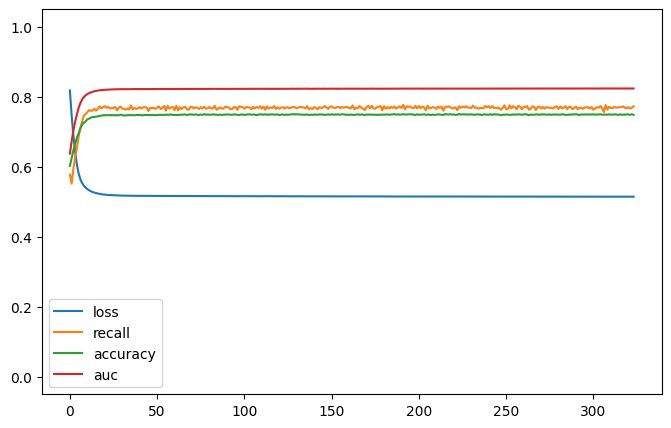

313/313 [==============================] - 0s 558us/step


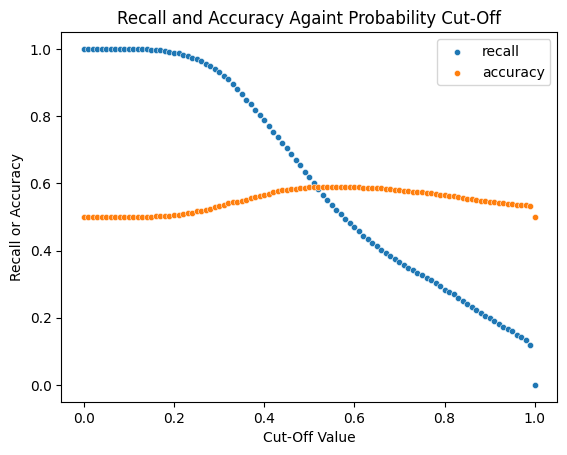

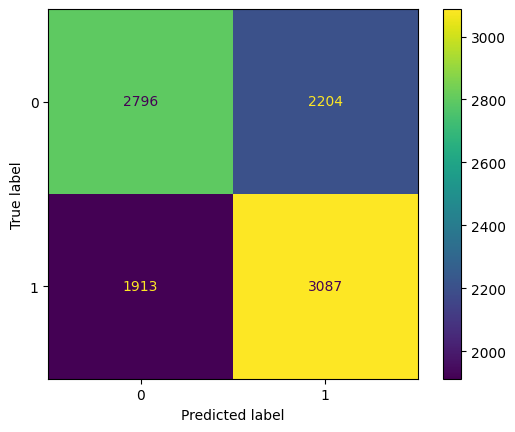

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 22)                484       
                                                                 
 dense_65 (Dense)            (None, 1)                 23        
                                                                 
Total params: 507 (1.98 KB)
Trainable params: 507 (1.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


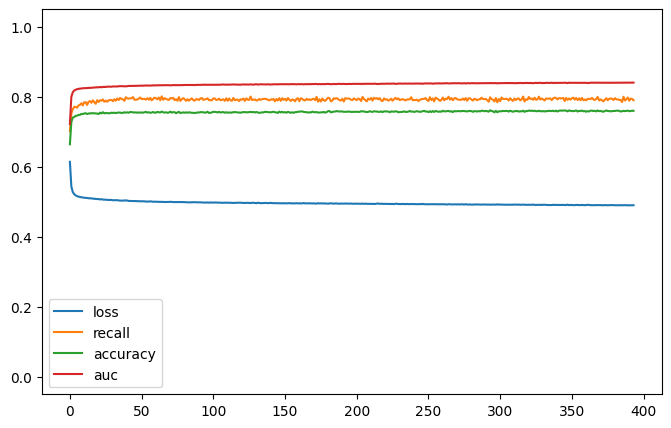

313/313 [==============================] - 0s 298us/step


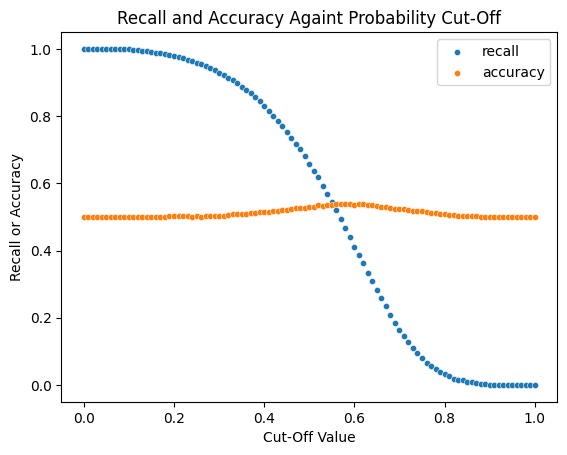

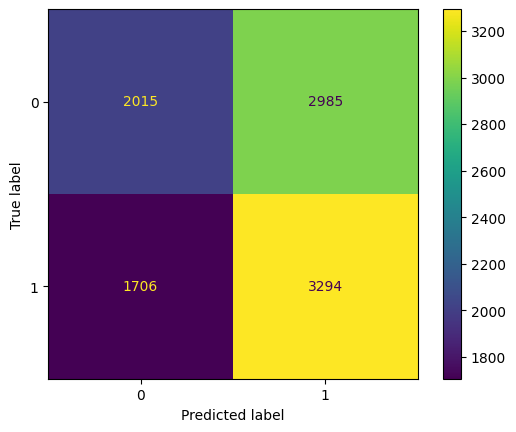

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 22)                484       
                                                                 
 dense_67 (Dense)            (None, 22)                506       
                                                                 
 dense_68 (Dense)            (None, 1)                 23        
                                                                 
Total params: 1013 (3.96 KB)
Trainable params: 1013 (3.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


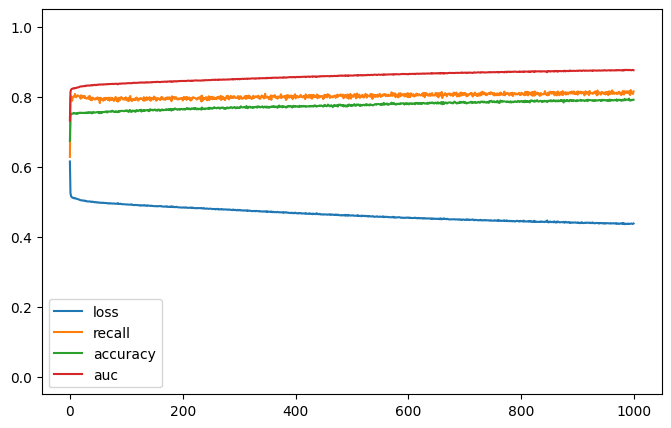

313/313 [==============================] - 0s 316us/step


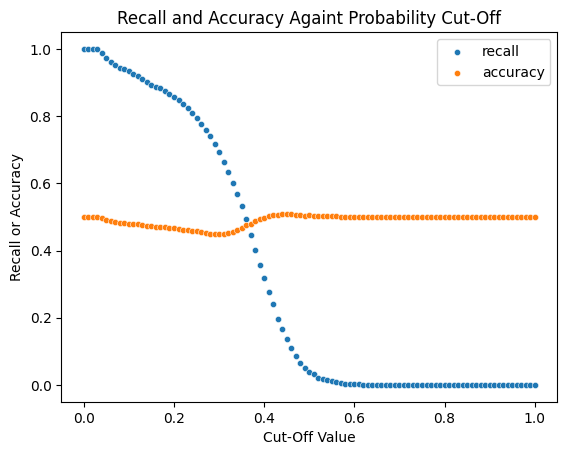

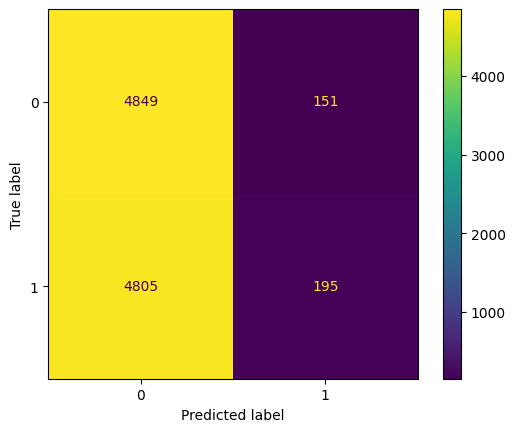

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 22)                484       
                                                                 
 dense_70 (Dense)            (None, 22)                506       
                                                                 
 dense_71 (Dense)            (None, 22)                506       
                                                                 
 dense_72 (Dense)            (None, 1)                 23        
                                                                 
Total params: 1519 (5.93 KB)
Trainable params: 1519 (5.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


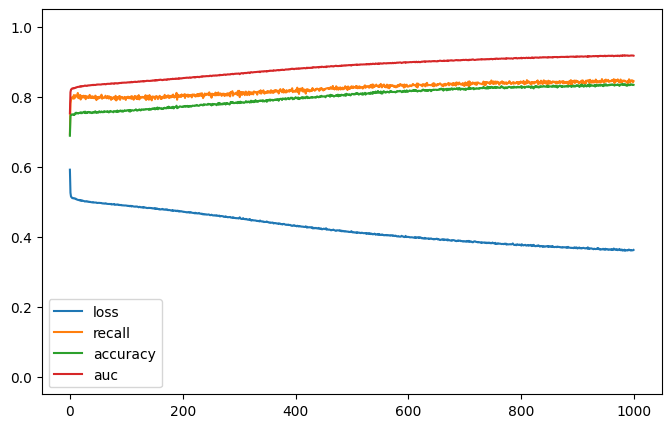

313/313 [==============================] - 0s 343us/step


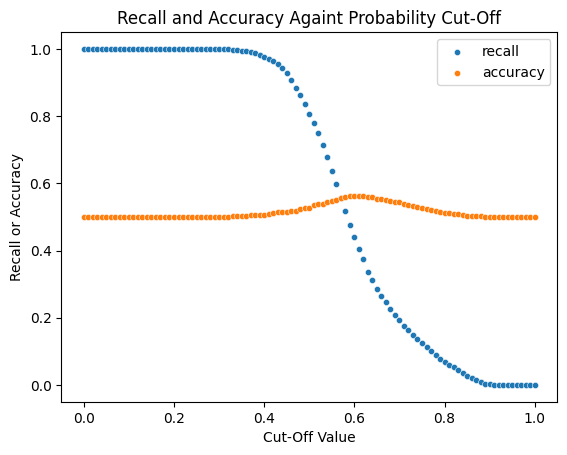

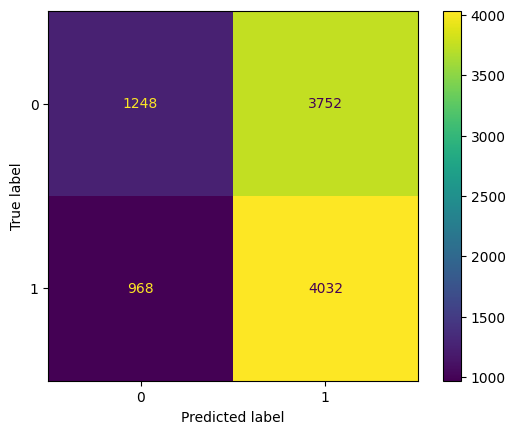

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 22)                484       
                                                                 
 dense_74 (Dense)            (None, 22)                506       
                                                                 
 dense_75 (Dense)            (None, 22)                506       
                                                                 
 dense_76 (Dense)            (None, 22)                506       
                                                                 
 dense_77 (Dense)            (None, 1)                 23        
                                                                 
Total params: 2025 (7.91 KB)
Trainable params: 2025 (7.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


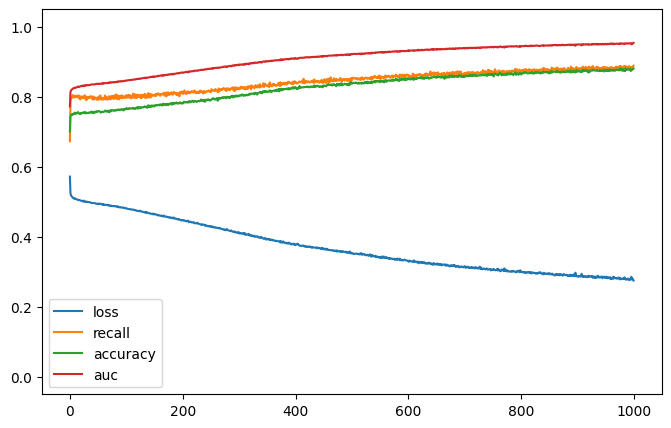

313/313 [==============================] - 0s 345us/step


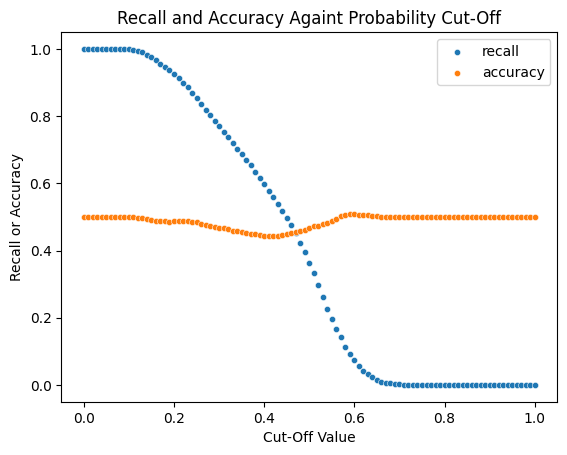

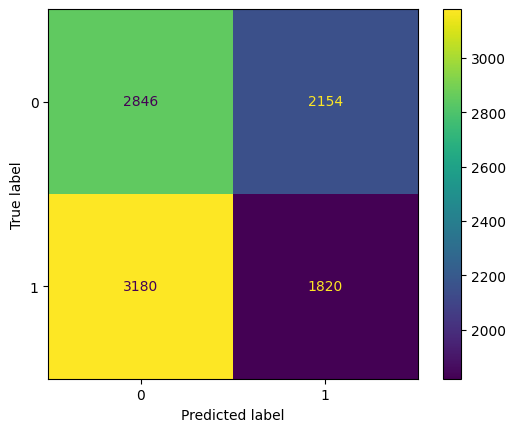

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 22)                484       
                                                                 
 dense_79 (Dense)            (None, 22)                506       
                                                                 
 dense_80 (Dense)            (None, 22)                506       
                                                                 
 dense_81 (Dense)            (None, 22)                506       
                                                                 
 dense_82 (Dense)            (None, 22)                506       
                                                                 
 dense_83 (Dense)            (None, 1)                 23        
                                                                 
Total params: 2531 (9.89 KB)
Trainable params: 2531 (

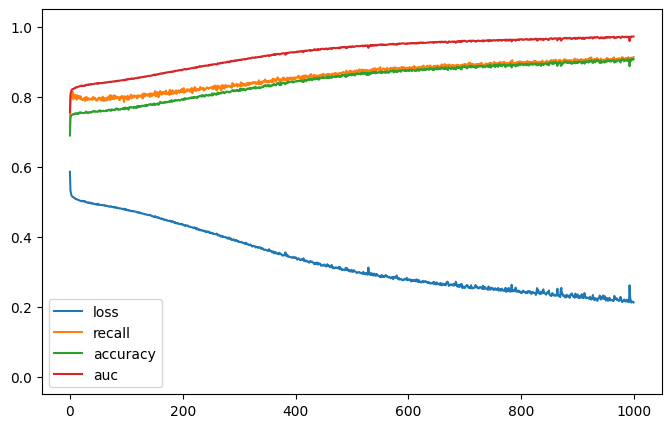

313/313 [==============================] - 0s 469us/step


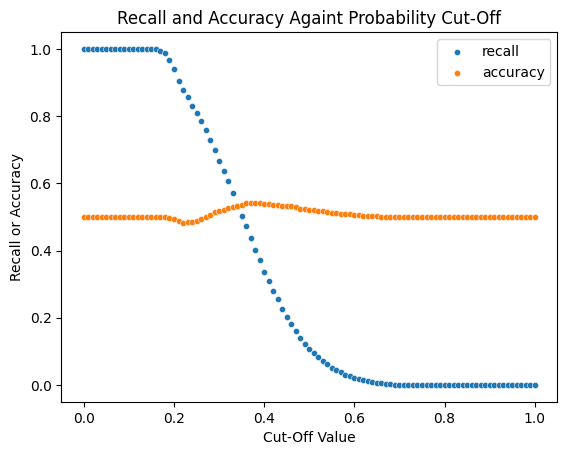

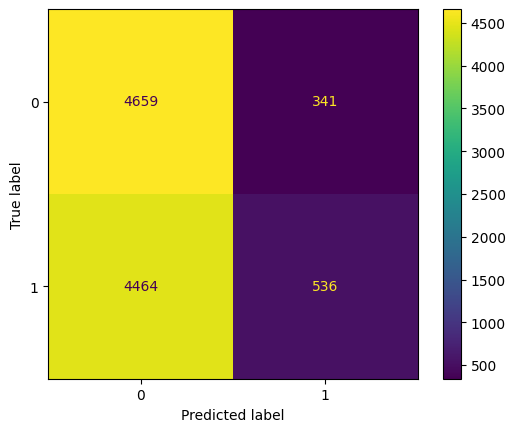

In [45]:
for i in range(len(history)):
    print(models[i][0].summary())
    pd.DataFrame(history[i].history).plot(figsize=(8,5))
    plt.ylim(-0.05,1.05)
    plt.show()
    
    y_pred_k = models[i][0].predict(X)
    x = np.arange(0,1.01,.01)
    recall = [recall_score(y, (y_pred_k >= i)*1) for i in x]
    accuracy = [accuracy_score(y, (y_pred_k >= i)*1) for i in x]
    sns.scatterplot(x=x, y=recall, label="recall", s=20)
    sns.scatterplot(x=x, y=accuracy, label="accuracy", s=20)
    plt.title("Recall and Accuracy Againt Probability Cut-Off")
    plt.ylabel("Recall or Accuracy")
    plt.xlabel("Cut-Off Value")
    plt.legend()
    plt.show()

    y_pred_kb = (y_pred_k >= 0.5)*1
    conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred_kb)
    vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    vis.plot()
    plt.show()

## Phase 3: Model Selection and Evaluation


The main goal in this phase is to obtain highest possible accuracy on the validation set after splitting your data into training set and validation set.  
* Please shuffle your rows before splitting.
* As your baseline model, i.e., the model with minimum accuracy, you can test the accuracy on the validation set using a ‘logistic regression’ model.
* Gradually grow your model into a multi-layered model and investigate if larger models deliver higher accuracy on the validation set.
    * As you explore various network architectures, please note the accuracies of these models to include in your report.
    * You can summarize your findings in the form of a table and the table should contain the accuracy and loss on the training set and the validation set (see below).
    * You can also include other parameters such as number of epochs, number of neurons, total number of parameters, etc.
 * Remember to select one model as your best performing model, i.e., the model that delivers highest accuracy on the validation set.
 * Your report should also include learning curves of your experiments.
 * You should also evaluate your models using other metrics besides precision; for example recall, precision, and F1 score.
 * Please note that your submission for this phase is ineligible for points if you do not use “model checkpointing” in your code.
 * You are discouraged to use external library methods such as “from sklearn.model_selection import train_test_split”.



[FOR GRADUATE STUDENTS ONLY] 

* discuss what architecture (how big) you do need to overfit when you have output as additional input feature,
* code a function that represents your model.
    * Once you have finished coding your model, please build your own function/method that serves as a prediction model.
    * Afterwards, please verify that predictions you obtain are same as the one you obtained using your trained model.

In [26]:
# shuffle rows
df = df.sample(frac=1)

In [27]:
df.shape

(10000, 22)

In [28]:
# split our data
df_train = df.iloc[:9000, :]
df_test = df.iloc[9000:10000, :]

In [29]:
X_train = df_train.drop(axis=1, labels='Diabetes_binary')
y_train = df_train['Diabetes_binary']
X_test = df_test.drop(axis=1, labels='Diabetes_binary')
y_test = df_test['Diabetes_binary']

In [30]:
# Create a transformer from the training data and use it to res-scale the training and test data

In [31]:
transform_dict = {}

for column in numeric_cols:
    transform_dict[column] = X_train[column].quantile([.25, .5, .75]).values

In [32]:
transform_dict

{'BMI': array([25., 29., 33.]),
 'GenHlth': array([2., 3., 4.]),
 'MentHlth': array([0., 0., 3.]),
 'PhysHlth': array([0., 0., 7.]),
 'Age': array([ 7.,  9., 11.]),
 'Education': array([4., 5., 6.]),
 'Income': array([4., 6., 8.])}

In [33]:
def robust_data_scaling_2(data, p_25, median, p_75):  
    return (data - median)/(p_75 - p_25)

In [34]:
for column in numeric_cols:
    X_train[column] = robust_data_scaling_2(X_train[column], 
                                            transform_dict[column][0], 
                                            transform_dict[column][1], 
                                            transform_dict[column][2])

In [35]:
for column in numeric_cols:
    X_test[column] = robust_data_scaling_2(X_test[column], 
                                            transform_dict[column][0], 
                                            transform_dict[column][1], 
                                            transform_dict[column][2])

In [36]:
# Verify
X_train[numeric_cols].describe().transpose()

count      mean       std   min  25%  50%  75%        max
BMI        9000.0  0.130333  0.915912 -2.00 -0.5  0.0  0.5   7.875000
GenHlth    9000.0 -0.069167  0.558272 -1.00 -0.5  0.0  0.5   1.000000
MentHlth   9000.0  1.296296  2.748609  0.00  0.0  0.0  1.0  10.000000
PhysHlth   9000.0  0.858111  1.452279  0.00  0.0  0.0  1.0   4.285714
Age        9000.0 -0.103083  0.713593 -2.00 -0.5  0.0  0.5   1.000000
Education  9000.0 -0.035778  0.514970 -2.00 -0.5  0.0  0.5   0.500000
Income     9000.0 -0.081139  0.544006 -1.25 -0.5  0.0  0.5   0.500000

In [37]:
models = []
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))
models.append((model, X_train, y_train))

for i in range(5):
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    for j in range(i):
        model.add(Dense(8-2*j, activation='relu'))
        
    model.add(Dense(1, activation='sigmoid'))
    models.append((model, X_train, y_train))

In [38]:
pool = multiprocessing.Pool()
history = pool.starmap(train_model, models)
pool.close()
pool.join()

Epoch 1/250
Epoch 1/250
Epoch 1/250
Epoch 1/250
Epoch 1/250
Epoch 1/250
282/282 [==============================] - 0s 845us/step - loss: 0.9510 - recall: 0.4725 - accuracy: 0.4190 - auc: 0.3957
Epoch 2/250
282/282 [==============================] - 1s 1ms/step - loss: 0.5875 - recall: 0.8006 - accuracy: 0.7120 - auc: 0.7760
Epoch 2/250
282/282 [==============================] - 1s 1ms/step - loss: 0.5997 - recall: 0.6770 - accuracy: 0.6790 - auc: 0.7448
Epoch 2/250
282/282 [==============================] - 1s 933us/step - loss: 0.6433 - recall: 0.5673 - accuracy: 0.6521 - auc: 0.6949
Epoch 2/250
282/282 [==============================] - 1s 1ms/step - loss: 0.6441 - recall: 0.8760 - accuracy: 0.6696 - auc: 0.7419
Epoch 2/250
282/282 [==============================] - 0s 820us/step - loss: 0.6762 - recall: 0.6734 - accuracy: 0.6067 - auc: 0.6424
Epoch 3/250
282/282 [==============================] - 0s 961us/step - loss: 0.5429 - recall: 0.7608 - accuracy: 0.7347 - auc: 0.8045
Epoch 3/

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 1)                 22        
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


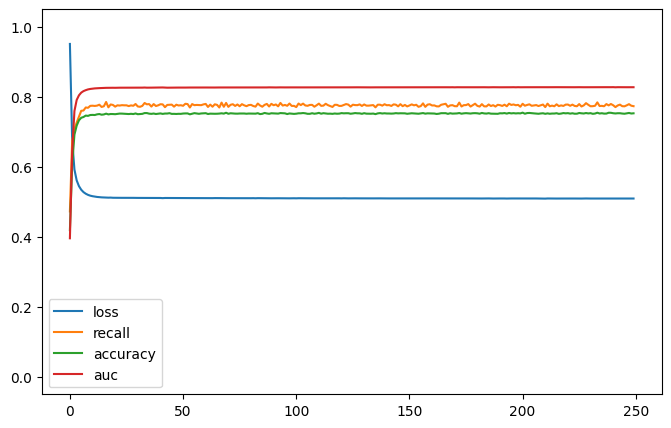

32/32 [==============================] - 0s 910us/step


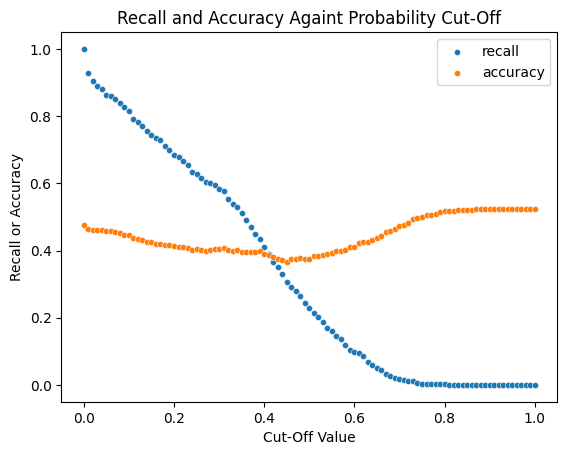

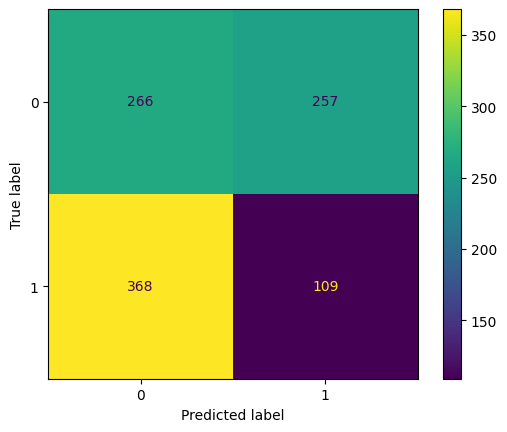

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 10)                220       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 231 (924.00 Byte)
Trainable params: 231 (924.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


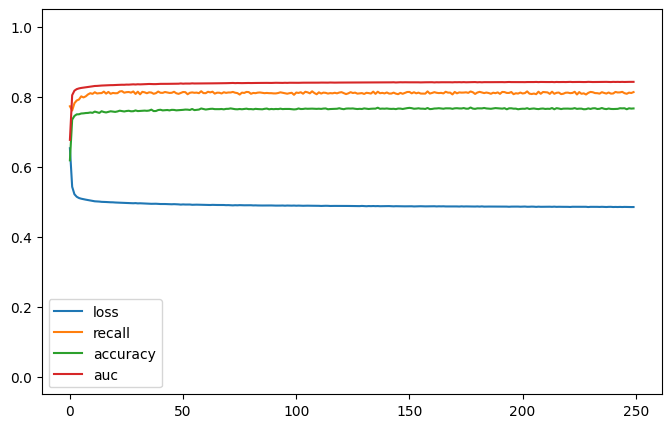

32/32 [==============================] - 0s 407us/step


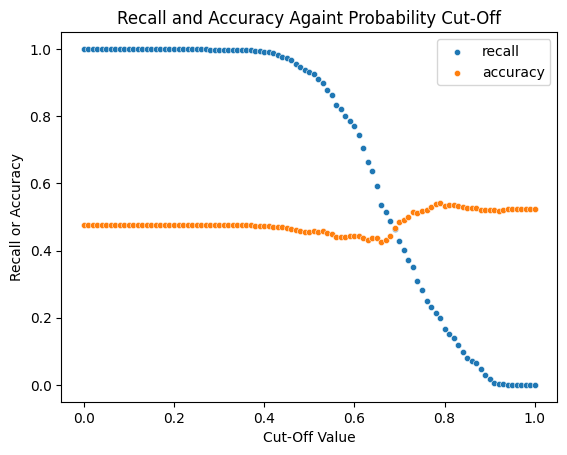

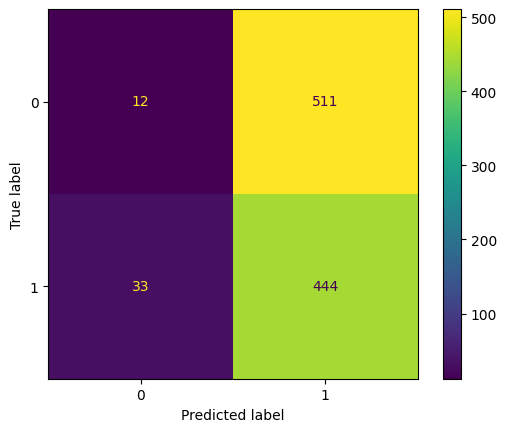

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10)                220       
                                                                 
 dense_25 (Dense)            (None, 8)                 88        
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 317 (1.24 KB)
Trainable params: 317 (1.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


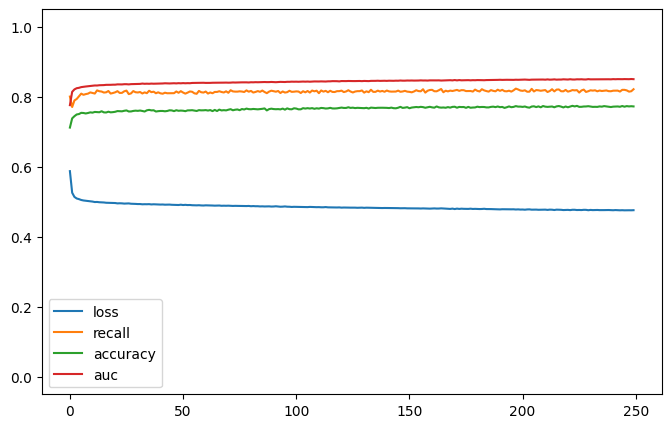

32/32 [==============================] - 0s 372us/step


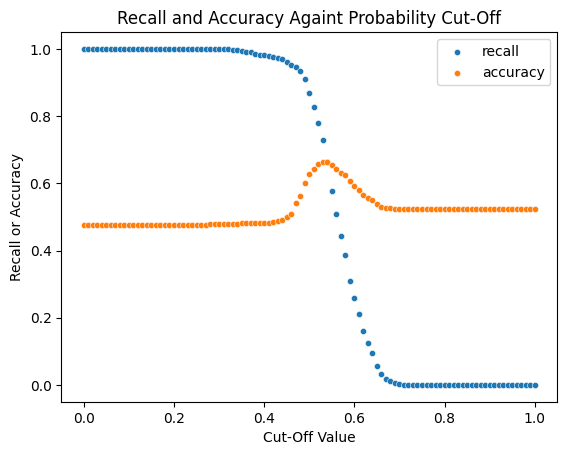

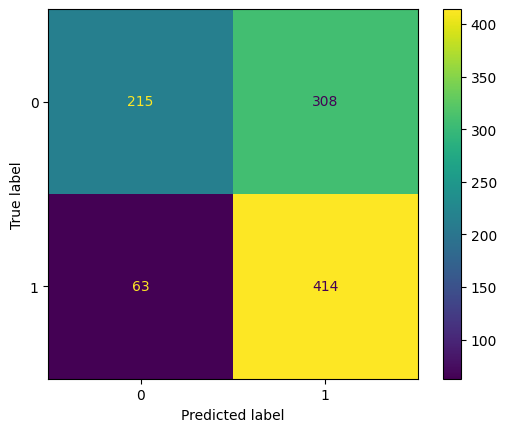

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 10)                220       
                                                                 
 dense_28 (Dense)            (None, 8)                 88        
                                                                 
 dense_29 (Dense)            (None, 6)                 54        
                                                                 
 dense_30 (Dense)            (None, 1)                 7         
                                                                 
Total params: 369 (1.44 KB)
Trainable params: 369 (1.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


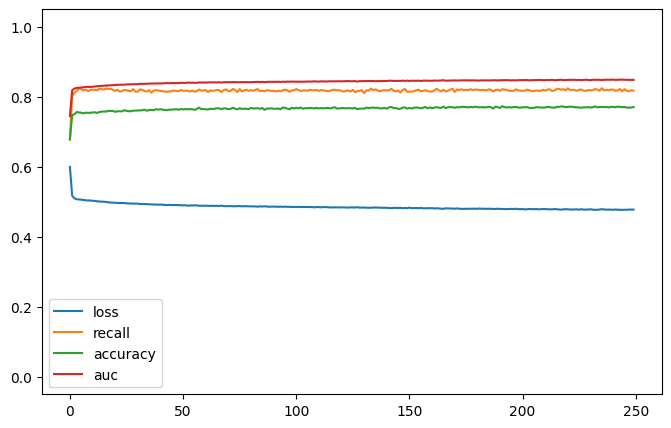

32/32 [==============================] - 0s 411us/step


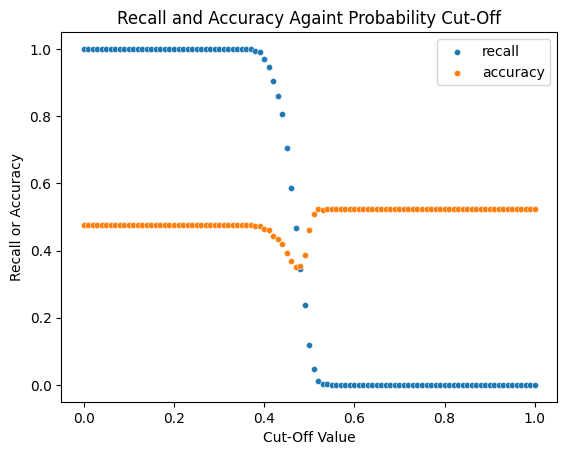

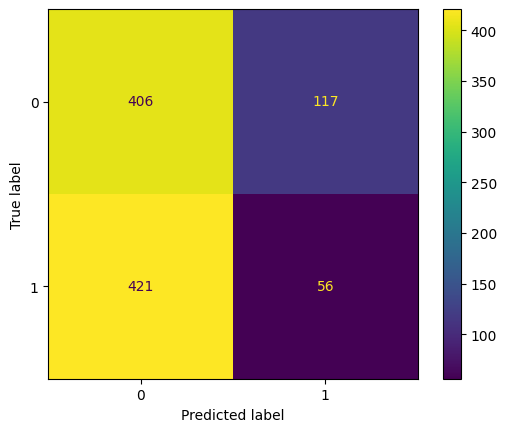

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 10)                220       
                                                                 
 dense_32 (Dense)            (None, 8)                 88        
                                                                 
 dense_33 (Dense)            (None, 6)                 54        
                                                                 
 dense_34 (Dense)            (None, 4)                 28        
                                                                 
 dense_35 (Dense)            (None, 1)                 5         
                                                                 
Total params: 395 (1.54 KB)
Trainable params: 395 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


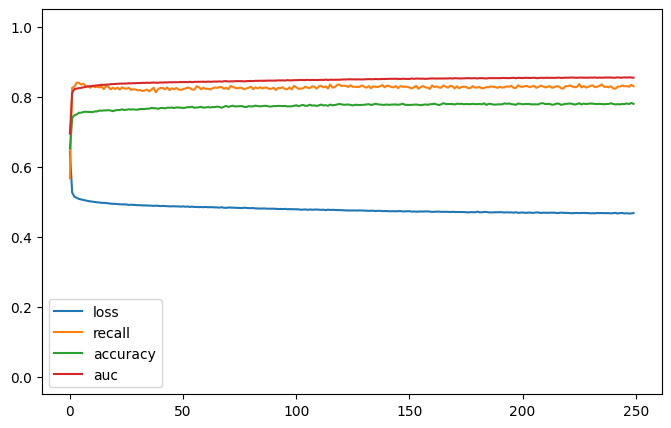

32/32 [==============================] - 0s 377us/step


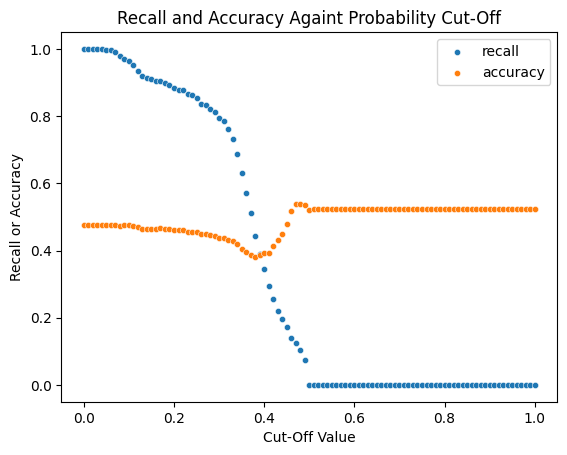

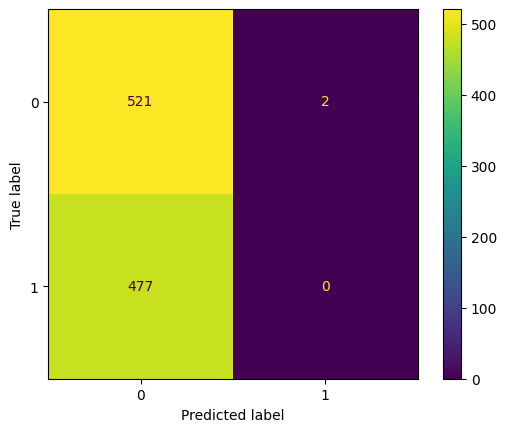

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 10)                220       
                                                                 
 dense_37 (Dense)            (None, 8)                 88        
                                                                 
 dense_38 (Dense)            (None, 6)                 54        
                                                                 
 dense_39 (Dense)            (None, 4)                 28        
                                                                 
 dense_40 (Dense)            (None, 2)                 10        
                                                                 
 dense_41 (Dense)            (None, 1)                 3         
                                                                 
Total params: 403 (1.57 KB)
Trainable params: 403 (1.

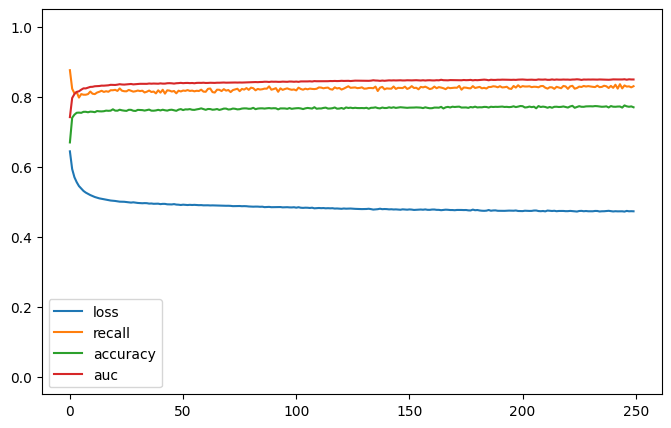

32/32 [==============================] - 0s 384us/step


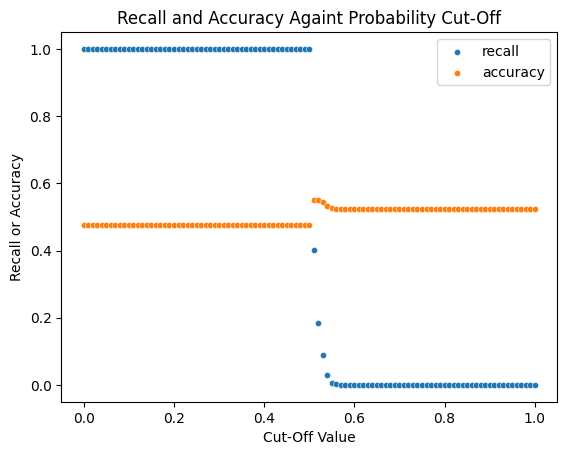

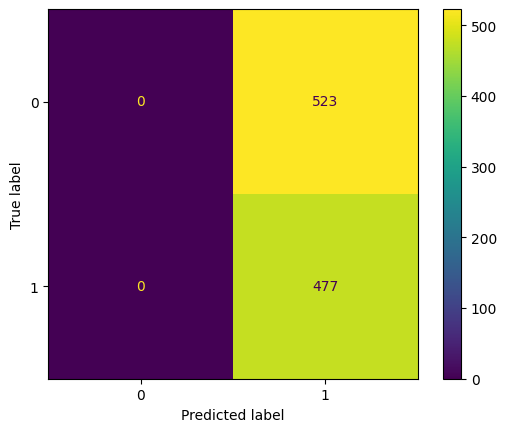

In [39]:
for i in range(len(history)):
    print(models[i][0].summary())
    pd.DataFrame(history[i].history).plot(figsize=(8,5))
    plt.ylim(-0.05,1.05)
    plt.show()
    
    y_pred_k = models[i][0].predict(X_test)
    x = np.arange(0,1.01,.01)
    recall = [recall_score(y_test, (y_pred_k >= i)*1) for i in x]
    accuracy = [accuracy_score(y_test, (y_pred_k >= i)*1) for i in x]
    sns.scatterplot(x=x, y=recall, label="recall", s=20)
    sns.scatterplot(x=x, y=accuracy, label="accuracy", s=20)
    plt.title("Recall and Accuracy Againt Probability Cut-Off")
    plt.ylabel("Recall or Accuracy")
    plt.xlabel("Cut-Off Value")
    plt.legend()
    plt.show()

    y_pred_kb = (y_pred_k >= 0.5)*1
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_kb)
    vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    vis.plot()
    plt.show()

In [40]:
y_pred_k = models[4][0].predict(X_test)

32/32 [==============================] - 0s 379us/step


Accuracy:  0.52
Specificity:  1.0
Recall:  0.0
F1 Score: 0.0


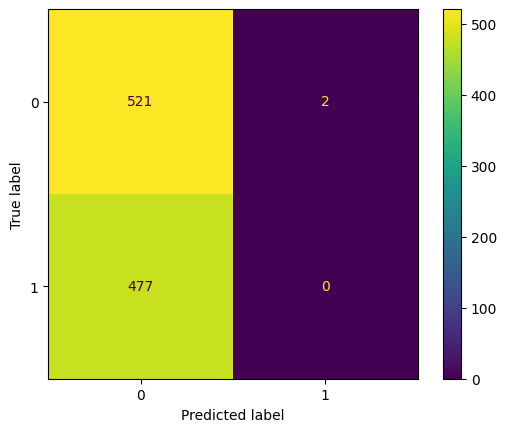

In [41]:
y_pred_kb = (y_pred_k >= 0.5)*1
scores(y_test, y_pred_kb)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_kb)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot()
plt.show()

## Phase 4: Feature Importance and Reduction  
The key activity in this phase is to study the importance of the input features by iteratively removing them. You must continue to use model checkpointing in this phase. Here are the steps involved:

* If you have 10 input features/columns, train 10 models where each model only receives one feature at a time.
    * For example, if age, BMI, and blood pressure are your only three input features, you train three models: one that only take age as input, another that only takes BMI as the input, and the last one that takes only blood pressure as the input.
    * The validation accuracy of these three models will indicate the relative importance of the three features.
    * You should plot these validation accuracies in the form of a bar diagram. If all your accuracies are more than 80%, your plot’s y-axis should be limited to 80-100.
* From the previous step you have the significance/important of each feature. The feature that yields the highest accuray is the most important feature.
    * Starting with the most unimportant feature, remove one feature at a time (without replacement) and train various models.
    * You can iteratively repeat the process removing more and more unimportant features. For example, if BMI is the most important feature and blood pressure is the least important one, you would train two models: one without blood pressure, and one without blood pressure and age.
    * Plot the validation dataset accuracy of all the models that you tested. The overall objective is to identify non-informative input features and remove them from the dataset.
* Finally, you can compare your feature-reduced model with the original model with all input features and discuss the difference in accuracy. 

For bonus points: Use model-agnostic methods such as LIME or Shapley values to derive feature importance. 
 
 https://christophm.github.io/interpretable-ml-book/

In [42]:
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=1, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(4, activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))
    return model

In [43]:
feature_models = []
for i in range(X_train.shape[1]):
    feature_models.append((create_model(), X_train.iloc[:, i], y_train))

In [44]:
pool = multiprocessing.Pool()
history = pool.starmap(train_model, feature_models)
pool.close()
pool.join()

Epoch 1/250
Epoch 1/250
Epoch 1/250
Epoch 1/250
Epoch 1/250
Epoch 1/250
Epoch 1/250
Epoch 1/250
282/282 [==============================] - 1s 1ms/step - loss: 0.6930 - recall: 0.9118 - accuracy: 0.5098 - auc: 0.5146 
Epoch 2/250
282/282 [==============================] - 1s 1ms/step - loss: 0.6400 - recall: 0.7590 - accuracy: 0.6959 - auc: 0.6930
Epoch 2/250
282/282 [==============================] - 1s 1ms/step - loss: 0.6638 - recall: 0.7325 - accuracy: 0.5947 - auc: 0.6513
Epoch 2/250
282/282 [==============================] - 1s 1ms/step - loss: 0.6891 - recall: 0.3369 - accuracy: 0.5556 - auc: 0.5610
Epoch 2/250
282/282 [==============================] - 1s 1ms/step - loss: 0.6925 - recall: 0.9308 - accuracy: 0.5091 - auc: 0.5402
Epoch 2/250
282/282 [==============================] - 1s 1ms/step - loss: 0.6764 - recall: 0.4590 - accuracy: 0.5553 - auc: 0.5773
Epoch 2/250
282/282 [==============================] - 1s 1ms/step - loss: 0.6932 - recall: 0.6821 - accuracy: 0.4959 - auc

In [45]:
def f_acc(idx, model_list, _X, _y):
    _preds = model_list[idx][0].predict(_X.iloc[:,idx])
    _y_preds_01 = (_preds >= 0.5)*1
    return accuracy_score(_y_preds_01, _y)


In [46]:
feature_scores = {}
cols = X_train.columns
for i in range(X_train.shape[1]):
    feature_scores[cols[i]] = f_acc(i, feature_models, X_test, y_test)

32/32 [==============================] - 0s 401us/step


In [47]:
feature_scores

{'HighBP': 0.477,
 'HighChol': 0.352,
 'CholCheck': 0.477,
 'BMI': 0.477,
 'Smoker': 0.462,
 'Stroke': 0.452,
 'HeartDiseaseorAttack': 0.477,
 'PhysActivity': 0.477,
 'Fruits': 0.477,
 'Veggies': 0.508,
 'HvyAlcoholConsump': 0.491,
 'AnyHealthcare': 0.477,
 'NoDocbcCost': 0.47,
 'GenHlth': 0.477,
 'MentHlth': 0.477,
 'PhysHlth': 0.41,
 'DiffWalk': 0.366,
 'Sex': 0.477,
 'Age': 0.477,
 'Education': 0.477,
 'Income': 0.593}

In [48]:
# https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
# Fits the explainer
explainer = shap.Explainer(models[4][0].predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

44/44 [==============================] - 0s 318us/step


PermutationExplainer explainer:   2%|▎                | 15/1000 [00:00<?, ?it/s]

52/52 [==============================] - 0s 314us/step


PermutationExplainer explainer:   2%|▏        | 17/1000 [00:11<05:16,  3.10it/s]

47/47 [==============================] - 0s 297us/step


PermutationExplainer explainer:   2%|▏        | 18/1000 [00:11<07:08,  2.29it/s]

51/51 [==============================] - 0s 314us/step


PermutationExplainer explainer:   2%|▏        | 19/1000 [00:12<08:20,  1.96it/s]

51/51 [==============================] - 0s 320us/step


PermutationExplainer explainer:   2%|▏        | 20/1000 [00:12<09:10,  1.78it/s]

47/47 [==============================] - 0s 330us/step


PermutationExplainer explainer:   2%|▏        | 21/1000 [00:13<09:27,  1.73it/s]

52/52 [==============================] - 0s 305us/step


PermutationExplainer explainer:   2%|▏        | 22/1000 [00:14<09:45,  1.67it/s]

58/58 [==============================] - 0s 302us/step


PermutationExplainer explainer:   2%|▏        | 23/1000 [00:14<10:12,  1.59it/s]

55/55 [==============================] - 0s 291us/step


PermutationExplainer explainer:   2%|▏        | 24/1000 [00:15<10:22,  1.57it/s]

59/59 [==============================] - 0s 317us/step


PermutationExplainer explainer:   2%|▏        | 25/1000 [00:16<10:40,  1.52it/s]

44/44 [==============================] - 0s 310us/step


PermutationExplainer explainer:   3%|▏        | 26/1000 [00:16<10:23,  1.56it/s]

53/53 [==============================] - 0s 305us/step


PermutationExplainer explainer:   3%|▏        | 27/1000 [00:17<10:27,  1.55it/s]

43/43 [==============================] - 0s 334us/step


PermutationExplainer explainer:   3%|▎        | 28/1000 [00:18<10:14,  1.58it/s]

50/50 [==============================] - 0s 318us/step


PermutationExplainer explainer:   3%|▎        | 29/1000 [00:18<10:15,  1.58it/s]

47/47 [==============================] - 0s 311us/step


PermutationExplainer explainer:   3%|▎        | 30/1000 [00:19<10:02,  1.61it/s]

51/51 [==============================] - 0s 315us/step


PermutationExplainer explainer:   3%|▎        | 31/1000 [00:19<10:03,  1.61it/s]

46/46 [==============================] - 0s 312us/step


PermutationExplainer explainer:   3%|▎        | 32/1000 [00:20<09:52,  1.63it/s]

48/48 [==============================] - 0s 310us/step


PermutationExplainer explainer:   3%|▎        | 33/1000 [00:21<09:53,  1.63it/s]

57/57 [==============================] - 0s 307us/step


PermutationExplainer explainer:   3%|▎        | 34/1000 [00:21<10:12,  1.58it/s]

52/52 [==============================] - 0s 318us/step


PermutationExplainer explainer:   4%|▎        | 35/1000 [00:22<10:18,  1.56it/s]

54/54 [==============================] - 0s 326us/step


PermutationExplainer explainer:   4%|▎        | 36/1000 [00:23<10:33,  1.52it/s]

49/49 [==============================] - 0s 329us/step


PermutationExplainer explainer:   4%|▎        | 37/1000 [00:23<10:23,  1.54it/s]

52/52 [==============================] - 0s 324us/step


PermutationExplainer explainer:   4%|▎        | 38/1000 [00:24<10:21,  1.55it/s]

48/48 [==============================] - 0s 318us/step


PermutationExplainer explainer:   4%|▎        | 39/1000 [00:25<10:09,  1.58it/s]

46/46 [==============================] - 0s 313us/step


PermutationExplainer explainer:   4%|▎        | 40/1000 [00:25<10:00,  1.60it/s]

47/47 [==============================] - 0s 328us/step


PermutationExplainer explainer:   4%|▎        | 41/1000 [00:26<09:48,  1.63it/s]

44/44 [==============================] - 0s 322us/step


PermutationExplainer explainer:   4%|▍        | 42/1000 [00:26<09:41,  1.65it/s]

45/45 [==============================] - 0s 309us/step


PermutationExplainer explainer:   4%|▍        | 43/1000 [00:27<09:36,  1.66it/s]

46/46 [==============================] - 0s 316us/step


PermutationExplainer explainer:   4%|▍        | 44/1000 [00:28<09:35,  1.66it/s]

48/48 [==============================] - 0s 337us/step


PermutationExplainer explainer:   4%|▍        | 45/1000 [00:28<09:40,  1.64it/s]

48/48 [==============================] - 0s 301us/step


PermutationExplainer explainer:   5%|▍        | 46/1000 [00:29<09:41,  1.64it/s]

45/45 [==============================] - 0s 326us/step


PermutationExplainer explainer:   5%|▍        | 47/1000 [00:29<09:35,  1.66it/s]

53/53 [==============================] - 0s 354us/step


PermutationExplainer explainer:   5%|▍        | 48/1000 [00:30<09:51,  1.61it/s]

50/50 [==============================] - 0s 295us/step


PermutationExplainer explainer:   5%|▍        | 49/1000 [00:31<09:48,  1.62it/s]

47/47 [==============================] - 0s 313us/step


PermutationExplainer explainer:   5%|▍        | 50/1000 [00:31<09:30,  1.66it/s]

46/46 [==============================] - 0s 318us/step


PermutationExplainer explainer:   5%|▍        | 51/1000 [00:32<09:24,  1.68it/s]

42/42 [==============================] - 0s 303us/step


PermutationExplainer explainer:   5%|▍        | 52/1000 [00:33<09:55,  1.59it/s]

46/46 [==============================] - 0s 296us/step


PermutationExplainer explainer:   5%|▍        | 53/1000 [00:33<09:36,  1.64it/s]

49/49 [==============================] - 0s 293us/step


PermutationExplainer explainer:   5%|▍        | 54/1000 [00:34<09:31,  1.66it/s]

48/48 [==============================] - 0s 291us/step


PermutationExplainer explainer:   6%|▍        | 55/1000 [00:34<09:21,  1.68it/s]

45/45 [==============================] - 0s 286us/step


PermutationExplainer explainer:   6%|▌        | 56/1000 [00:35<09:08,  1.72it/s]

54/54 [==============================] - 0s 313us/step


PermutationExplainer explainer:   6%|▌        | 57/1000 [00:35<09:20,  1.68it/s]

50/50 [==============================] - 0s 299us/step


PermutationExplainer explainer:   6%|▌        | 58/1000 [00:36<09:25,  1.67it/s]

49/49 [==============================] - 0s 297us/step


PermutationExplainer explainer:   6%|▌        | 59/1000 [00:37<09:19,  1.68it/s]

51/51 [==============================] - 0s 309us/step


PermutationExplainer explainer:   6%|▌        | 60/1000 [00:37<09:19,  1.68it/s]

46/46 [==============================] - 0s 305us/step


PermutationExplainer explainer:   6%|▌        | 61/1000 [00:38<09:13,  1.70it/s]

53/53 [==============================] - 0s 307us/step


PermutationExplainer explainer:   6%|▌        | 62/1000 [00:38<09:23,  1.66it/s]

53/53 [==============================] - 0s 304us/step


PermutationExplainer explainer:   6%|▌        | 63/1000 [00:39<09:27,  1.65it/s]

51/51 [==============================] - 0s 306us/step


PermutationExplainer explainer:   6%|▌        | 64/1000 [00:40<09:22,  1.66it/s]

42/42 [==============================] - 0s 322us/step


PermutationExplainer explainer:   6%|▌        | 65/1000 [00:40<09:02,  1.72it/s]

44/44 [==============================] - 0s 283us/step


PermutationExplainer explainer:   7%|▌        | 66/1000 [00:41<08:58,  1.73it/s]

49/49 [==============================] - 0s 296us/step


PermutationExplainer explainer:   7%|▌        | 67/1000 [00:41<09:00,  1.73it/s]

49/49 [==============================] - 0s 302us/step


PermutationExplainer explainer:   7%|▌        | 68/1000 [00:42<09:02,  1.72it/s]

48/48 [==============================] - 0s 315us/step


PermutationExplainer explainer:   7%|▌        | 69/1000 [00:42<09:08,  1.70it/s]

44/44 [==============================] - 0s 295us/step


PermutationExplainer explainer:   7%|▋        | 70/1000 [00:43<08:59,  1.72it/s]

50/50 [==============================] - 0s 288us/step


PermutationExplainer explainer:   7%|▋        | 71/1000 [00:44<09:09,  1.69it/s]

51/51 [==============================] - 0s 289us/step


PermutationExplainer explainer:   7%|▋        | 72/1000 [00:44<09:12,  1.68it/s]

51/51 [==============================] - 0s 283us/step


PermutationExplainer explainer:   7%|▋        | 73/1000 [00:45<09:16,  1.67it/s]

47/47 [==============================] - 0s 300us/step


PermutationExplainer explainer:   7%|▋        | 74/1000 [00:45<09:10,  1.68it/s]

47/47 [==============================] - 0s 292us/step


PermutationExplainer explainer:   8%|▋        | 75/1000 [00:46<09:11,  1.68it/s]

53/53 [==============================] - 0s 294us/step


PermutationExplainer explainer:   8%|▋        | 76/1000 [00:47<09:19,  1.65it/s]

53/53 [==============================] - 0s 291us/step


PermutationExplainer explainer:   8%|▋        | 77/1000 [00:47<09:28,  1.62it/s]

51/51 [==============================] - 0s 333us/step


PermutationExplainer explainer:   8%|▋        | 78/1000 [00:48<09:25,  1.63it/s]

46/46 [==============================] - 0s 317us/step


PermutationExplainer explainer:   8%|▋        | 79/1000 [00:49<09:17,  1.65it/s]

51/51 [==============================] - 0s 297us/step


PermutationExplainer explainer:   8%|▋        | 80/1000 [00:49<09:18,  1.65it/s]

50/50 [==============================] - 0s 301us/step


PermutationExplainer explainer:   8%|▋        | 81/1000 [00:50<09:12,  1.66it/s]

49/49 [==============================] - 0s 289us/step


PermutationExplainer explainer:   8%|▋        | 82/1000 [00:50<09:09,  1.67it/s]

49/49 [==============================] - 0s 294us/step


PermutationExplainer explainer:   8%|▋        | 83/1000 [00:51<09:05,  1.68it/s]

55/55 [==============================] - 0s 301us/step


PermutationExplainer explainer:   8%|▊        | 84/1000 [00:52<09:14,  1.65it/s]

50/50 [==============================] - 0s 308us/step


PermutationExplainer explainer:   8%|▊        | 85/1000 [00:52<09:08,  1.67it/s]

50/50 [==============================] - 0s 300us/step


PermutationExplainer explainer:   9%|▊        | 86/1000 [00:53<09:10,  1.66it/s]

57/57 [==============================] - 0s 297us/step


PermutationExplainer explainer:   9%|▊        | 87/1000 [00:53<09:21,  1.63it/s]

45/45 [==============================] - 0s 308us/step


PermutationExplainer explainer:   9%|▊        | 88/1000 [00:54<09:07,  1.67it/s]

46/46 [==============================] - 0s 300us/step


PermutationExplainer explainer:   9%|▊        | 89/1000 [00:55<09:00,  1.69it/s]

53/53 [==============================] - 0s 292us/step


PermutationExplainer explainer:   9%|▊        | 90/1000 [00:55<09:05,  1.67it/s]

45/45 [==============================] - 0s 292us/step


PermutationExplainer explainer:   9%|▊        | 91/1000 [00:56<08:52,  1.71it/s]

51/51 [==============================] - 0s 292us/step


PermutationExplainer explainer:   9%|▊        | 92/1000 [00:56<08:56,  1.69it/s]

50/50 [==============================] - 0s 287us/step


PermutationExplainer explainer:   9%|▊        | 93/1000 [00:57<08:53,  1.70it/s]

48/48 [==============================] - 0s 294us/step


PermutationExplainer explainer:   9%|▊        | 94/1000 [00:57<08:54,  1.69it/s]

45/45 [==============================] - 0s 274us/step


PermutationExplainer explainer:  10%|▊        | 95/1000 [00:58<08:49,  1.71it/s]

49/49 [==============================] - 0s 288us/step


PermutationExplainer explainer:  10%|▊        | 96/1000 [00:59<08:56,  1.69it/s]

51/51 [==============================] - 0s 281us/step


PermutationExplainer explainer:  10%|▊        | 97/1000 [00:59<08:53,  1.69it/s]

47/47 [==============================] - 0s 309us/step


PermutationExplainer explainer:  10%|▉        | 98/1000 [01:00<08:47,  1.71it/s]

56/56 [==============================] - 0s 310us/step


PermutationExplainer explainer:  10%|▉        | 99/1000 [01:00<08:59,  1.67it/s]

60/60 [==============================] - 0s 293us/step


PermutationExplainer explainer:  10%|▊       | 100/1000 [01:01<09:23,  1.60it/s]

48/48 [==============================] - 0s 301us/step


PermutationExplainer explainer:  10%|▊       | 101/1000 [01:02<09:08,  1.64it/s]

52/52 [==============================] - 0s 302us/step


PermutationExplainer explainer:  10%|▊       | 102/1000 [01:02<09:04,  1.65it/s]

45/45 [==============================] - 0s 294us/step


PermutationExplainer explainer:  10%|▊       | 103/1000 [01:03<08:48,  1.70it/s]

46/46 [==============================] - 0s 320us/step


PermutationExplainer explainer:  10%|▊       | 104/1000 [01:03<08:39,  1.73it/s]

50/50 [==============================] - 0s 346us/step


PermutationExplainer explainer:  10%|▊       | 105/1000 [01:04<08:53,  1.68it/s]

48/48 [==============================] - 0s 346us/step


PermutationExplainer explainer:  11%|▊       | 106/1000 [01:05<09:05,  1.64it/s]

58/58 [==============================] - 0s 317us/step


PermutationExplainer explainer:  11%|▊       | 107/1000 [01:05<09:21,  1.59it/s]

42/42 [==============================] - 0s 360us/step


PermutationExplainer explainer:  11%|▊       | 108/1000 [01:06<09:26,  1.58it/s]

56/56 [==============================] - 0s 303us/step


PermutationExplainer explainer:  11%|▊       | 109/1000 [01:07<09:34,  1.55it/s]

52/52 [==============================] - 0s 315us/step


PermutationExplainer explainer:  11%|▉       | 110/1000 [01:07<09:35,  1.55it/s]

52/52 [==============================] - 0s 296us/step


PermutationExplainer explainer:  11%|▉       | 111/1000 [01:08<09:28,  1.57it/s]

54/54 [==============================] - 0s 287us/step


PermutationExplainer explainer:  11%|▉       | 112/1000 [01:09<09:11,  1.61it/s]

50/50 [==============================] - 0s 310us/step


PermutationExplainer explainer:  11%|▉       | 113/1000 [01:09<09:02,  1.63it/s]

49/49 [==============================] - 0s 336us/step


PermutationExplainer explainer:  11%|▉       | 114/1000 [01:10<08:58,  1.65it/s]

57/57 [==============================] - 0s 298us/step


PermutationExplainer explainer:  12%|▉       | 115/1000 [01:10<09:03,  1.63it/s]

55/55 [==============================] - 0s 311us/step


PermutationExplainer explainer:  12%|▉       | 116/1000 [01:11<09:06,  1.62it/s]

48/48 [==============================] - 0s 297us/step


PermutationExplainer explainer:  12%|▉       | 117/1000 [01:12<08:58,  1.64it/s]

48/48 [==============================] - 0s 302us/step


PermutationExplainer explainer:  12%|▉       | 118/1000 [01:12<08:50,  1.66it/s]

48/48 [==============================] - 0s 296us/step


PermutationExplainer explainer:  12%|▉       | 119/1000 [01:13<08:43,  1.68it/s]

48/48 [==============================] - 0s 299us/step


PermutationExplainer explainer:  12%|▉       | 120/1000 [01:13<08:40,  1.69it/s]

47/47 [==============================] - 0s 301us/step


PermutationExplainer explainer:  12%|▉       | 121/1000 [01:14<08:34,  1.71it/s]

54/54 [==============================] - 0s 364us/step


PermutationExplainer explainer:  12%|▉       | 122/1000 [01:15<09:00,  1.62it/s]

48/48 [==============================] - 0s 346us/step


PermutationExplainer explainer:  12%|▉       | 123/1000 [01:15<09:00,  1.62it/s]

51/51 [==============================] - 0s 345us/step


PermutationExplainer explainer:  12%|▉       | 124/1000 [01:16<09:11,  1.59it/s]

49/49 [==============================] - 0s 292us/step


PermutationExplainer explainer:  12%|█       | 125/1000 [01:16<08:56,  1.63it/s]

43/43 [==============================] - 0s 281us/step


PermutationExplainer explainer:  13%|█       | 126/1000 [01:17<08:38,  1.69it/s]

47/47 [==============================] - 0s 289us/step


PermutationExplainer explainer:  13%|█       | 127/1000 [01:18<08:32,  1.70it/s]

50/50 [==============================] - 0s 292us/step


PermutationExplainer explainer:  13%|█       | 128/1000 [01:18<08:30,  1.71it/s]

52/52 [==============================] - 0s 310us/step


PermutationExplainer explainer:  13%|█       | 129/1000 [01:19<08:36,  1.69it/s]

54/54 [==============================] - 0s 290us/step


PermutationExplainer explainer:  13%|█       | 130/1000 [01:19<08:46,  1.65it/s]

48/48 [==============================] - 0s 332us/step


PermutationExplainer explainer:  13%|█       | 131/1000 [01:20<08:42,  1.66it/s]

44/44 [==============================] - 0s 300us/step


PermutationExplainer explainer:  13%|█       | 132/1000 [01:21<08:32,  1.69it/s]

51/51 [==============================] - 0s 295us/step


PermutationExplainer explainer:  13%|█       | 133/1000 [01:21<08:31,  1.69it/s]

56/56 [==============================] - 0s 310us/step


PermutationExplainer explainer:  13%|█       | 134/1000 [01:22<08:43,  1.65it/s]

46/46 [==============================] - 0s 316us/step


PermutationExplainer explainer:  14%|█       | 135/1000 [01:22<08:31,  1.69it/s]

54/54 [==============================] - 0s 298us/step


PermutationExplainer explainer:  14%|█       | 136/1000 [01:23<08:38,  1.67it/s]

46/46 [==============================] - 0s 296us/step


PermutationExplainer explainer:  14%|█       | 137/1000 [01:23<08:24,  1.71it/s]

50/50 [==============================] - 0s 312us/step


PermutationExplainer explainer:  14%|█       | 138/1000 [01:24<08:24,  1.71it/s]

44/44 [==============================] - 0s 284us/step


PermutationExplainer explainer:  14%|█       | 139/1000 [01:25<08:15,  1.74it/s]

47/47 [==============================] - 0s 301us/step


PermutationExplainer explainer:  14%|█       | 140/1000 [01:25<08:09,  1.76it/s]

52/52 [==============================] - 0s 282us/step


PermutationExplainer explainer:  14%|█▏      | 141/1000 [01:26<08:13,  1.74it/s]

55/55 [==============================] - 0s 312us/step


PermutationExplainer explainer:  14%|█▏      | 142/1000 [01:26<08:28,  1.69it/s]

49/49 [==============================] - 0s 317us/step


PermutationExplainer explainer:  14%|█▏      | 143/1000 [01:27<08:40,  1.65it/s]

51/51 [==============================] - 0s 349us/step


PermutationExplainer explainer:  14%|█▏      | 144/1000 [01:28<09:00,  1.58it/s]

49/49 [==============================] - 0s 311us/step


PermutationExplainer explainer:  14%|█▏      | 145/1000 [01:28<09:25,  1.51it/s]

50/50 [==============================] - 0s 329us/step


PermutationExplainer explainer:  15%|█▏      | 146/1000 [01:29<09:16,  1.53it/s]

48/48 [==============================] - 0s 296us/step


PermutationExplainer explainer:  15%|█▏      | 147/1000 [01:30<09:06,  1.56it/s]

49/49 [==============================] - 0s 426us/step


PermutationExplainer explainer:  15%|█▏      | 148/1000 [01:30<09:09,  1.55it/s]

54/54 [==============================] - 0s 307us/step


PermutationExplainer explainer:  15%|█▏      | 149/1000 [01:31<09:11,  1.54it/s]

50/50 [==============================] - 0s 318us/step


PermutationExplainer explainer:  15%|█▏      | 150/1000 [01:32<08:59,  1.58it/s]

46/46 [==============================] - 0s 327us/step


PermutationExplainer explainer:  15%|█▏      | 151/1000 [01:32<08:51,  1.60it/s]

41/41 [==============================] - 0s 352us/step


PermutationExplainer explainer:  15%|█▏      | 152/1000 [01:33<08:33,  1.65it/s]

47/47 [==============================] - 0s 305us/step


PermutationExplainer explainer:  15%|█▏      | 153/1000 [01:33<08:27,  1.67it/s]

49/49 [==============================] - 0s 287us/step


PermutationExplainer explainer:  15%|█▏      | 154/1000 [01:34<08:21,  1.69it/s]

47/47 [==============================] - 0s 316us/step


PermutationExplainer explainer:  16%|█▏      | 155/1000 [01:35<08:18,  1.70it/s]

51/51 [==============================] - 0s 289us/step


PermutationExplainer explainer:  16%|█▏      | 156/1000 [01:35<08:26,  1.67it/s]

51/51 [==============================] - 0s 284us/step


PermutationExplainer explainer:  16%|█▎      | 157/1000 [01:36<08:29,  1.65it/s]

46/46 [==============================] - 0s 294us/step


PermutationExplainer explainer:  16%|█▎      | 158/1000 [01:36<08:33,  1.64it/s]

49/49 [==============================] - 0s 291us/step


PermutationExplainer explainer:  16%|█▎      | 159/1000 [01:37<08:25,  1.67it/s]

48/48 [==============================] - 0s 302us/step


PermutationExplainer explainer:  16%|█▎      | 160/1000 [01:38<08:22,  1.67it/s]

61/61 [==============================] - 0s 281us/step


PermutationExplainer explainer:  16%|█▎      | 161/1000 [01:38<08:43,  1.60it/s]

42/42 [==============================] - 0s 301us/step


PermutationExplainer explainer:  16%|█▎      | 162/1000 [01:39<08:20,  1.67it/s]

49/49 [==============================] - 0s 286us/step


PermutationExplainer explainer:  16%|█▎      | 163/1000 [01:39<08:24,  1.66it/s]

47/47 [==============================] - 0s 312us/step


PermutationExplainer explainer:  16%|█▎      | 164/1000 [01:40<08:16,  1.68it/s]

54/54 [==============================] - 0s 293us/step


PermutationExplainer explainer:  16%|█▎      | 165/1000 [01:41<08:23,  1.66it/s]

48/48 [==============================] - 0s 298us/step


PermutationExplainer explainer:  17%|█▎      | 166/1000 [01:41<08:13,  1.69it/s]

55/55 [==============================] - 0s 287us/step


PermutationExplainer explainer:  17%|█▎      | 167/1000 [01:42<08:22,  1.66it/s]

46/46 [==============================] - 0s 269us/step


PermutationExplainer explainer:  17%|█▎      | 168/1000 [01:42<08:09,  1.70it/s]

46/46 [==============================] - 0s 372us/step


PermutationExplainer explainer:  17%|█▎      | 169/1000 [01:43<08:12,  1.69it/s]

45/45 [==============================] - 0s 309us/step


PermutationExplainer explainer:  17%|█▎      | 170/1000 [01:44<08:11,  1.69it/s]

47/47 [==============================] - 0s 324us/step


PermutationExplainer explainer:  17%|█▎      | 171/1000 [01:44<08:09,  1.69it/s]

46/46 [==============================] - 0s 287us/step


PermutationExplainer explainer:  17%|█▍      | 172/1000 [01:45<08:04,  1.71it/s]

47/47 [==============================] - 0s 329us/step


PermutationExplainer explainer:  17%|█▍      | 173/1000 [01:45<08:02,  1.71it/s]

49/49 [==============================] - 0s 331us/step


PermutationExplainer explainer:  17%|█▍      | 174/1000 [01:46<08:10,  1.68it/s]

49/49 [==============================] - 0s 308us/step


PermutationExplainer explainer:  18%|█▍      | 175/1000 [01:47<08:18,  1.66it/s]

48/48 [==============================] - 0s 301us/step


PermutationExplainer explainer:  18%|█▍      | 176/1000 [01:47<08:18,  1.65it/s]

47/47 [==============================] - 0s 322us/step


PermutationExplainer explainer:  18%|█▍      | 177/1000 [01:48<08:09,  1.68it/s]

45/45 [==============================] - 0s 354us/step


PermutationExplainer explainer:  18%|█▍      | 178/1000 [01:48<08:18,  1.65it/s]

55/55 [==============================] - 0s 300us/step


PermutationExplainer explainer:  18%|█▍      | 179/1000 [01:49<08:28,  1.61it/s]

56/56 [==============================] - 0s 306us/step


PermutationExplainer explainer:  18%|█▍      | 180/1000 [01:50<08:38,  1.58it/s]

49/49 [==============================] - 0s 307us/step


PermutationExplainer explainer:  18%|█▍      | 181/1000 [01:50<08:29,  1.61it/s]

53/53 [==============================] - 0s 322us/step


PermutationExplainer explainer:  18%|█▍      | 182/1000 [01:51<08:33,  1.59it/s]

45/45 [==============================] - 0s 291us/step


PermutationExplainer explainer:  18%|█▍      | 183/1000 [01:51<08:24,  1.62it/s]

52/52 [==============================] - 0s 319us/step


PermutationExplainer explainer:  18%|█▍      | 184/1000 [01:52<08:22,  1.62it/s]

44/44 [==============================] - 0s 300us/step


PermutationExplainer explainer:  18%|█▍      | 185/1000 [01:53<08:16,  1.64it/s]

46/46 [==============================] - 0s 313us/step


PermutationExplainer explainer:  19%|█▍      | 186/1000 [01:53<08:12,  1.65it/s]

49/49 [==============================] - 0s 285us/step


PermutationExplainer explainer:  19%|█▍      | 187/1000 [01:54<08:16,  1.64it/s]

52/52 [==============================] - 0s 308us/step


PermutationExplainer explainer:  19%|█▌      | 188/1000 [01:55<08:21,  1.62it/s]

44/44 [==============================] - 0s 318us/step


PermutationExplainer explainer:  19%|█▌      | 189/1000 [01:55<08:14,  1.64it/s]

48/48 [==============================] - 0s 316us/step


PermutationExplainer explainer:  19%|█▌      | 190/1000 [01:56<08:18,  1.63it/s]

47/47 [==============================] - 0s 305us/step


PermutationExplainer explainer:  19%|█▌      | 191/1000 [01:56<08:09,  1.65it/s]

54/54 [==============================] - 0s 284us/step


PermutationExplainer explainer:  19%|█▌      | 192/1000 [01:57<08:12,  1.64it/s]

49/49 [==============================] - 0s 293us/step


PermutationExplainer explainer:  19%|█▌      | 193/1000 [01:58<08:13,  1.63it/s]

52/52 [==============================] - 0s 317us/step


PermutationExplainer explainer:  19%|█▌      | 194/1000 [01:58<08:18,  1.62it/s]

49/49 [==============================] - 0s 323us/step


PermutationExplainer explainer:  20%|█▌      | 195/1000 [01:59<08:11,  1.64it/s]

54/54 [==============================] - 0s 293us/step


PermutationExplainer explainer:  20%|█▌      | 196/1000 [01:59<08:26,  1.59it/s]

60/60 [==============================] - 0s 309us/step


PermutationExplainer explainer:  20%|█▌      | 197/1000 [02:00<08:46,  1.53it/s]

44/44 [==============================] - 0s 282us/step


PermutationExplainer explainer:  20%|█▌      | 198/1000 [02:01<08:27,  1.58it/s]

48/48 [==============================] - 0s 345us/step


PermutationExplainer explainer:  20%|█▌      | 199/1000 [02:01<08:27,  1.58it/s]

52/52 [==============================] - 0s 303us/step


PermutationExplainer explainer:  20%|█▌      | 200/1000 [02:02<08:21,  1.59it/s]

49/49 [==============================] - 0s 336us/step


PermutationExplainer explainer:  20%|█▌      | 201/1000 [02:03<08:20,  1.60it/s]

49/49 [==============================] - 0s 343us/step


PermutationExplainer explainer:  20%|█▌      | 202/1000 [02:03<08:19,  1.60it/s]

51/51 [==============================] - 0s 285us/step


PermutationExplainer explainer:  20%|█▌      | 203/1000 [02:04<08:15,  1.61it/s]

50/50 [==============================] - 0s 326us/step


PermutationExplainer explainer:  20%|█▋      | 204/1000 [02:04<08:13,  1.61it/s]

47/47 [==============================] - 0s 298us/step


PermutationExplainer explainer:  20%|█▋      | 205/1000 [02:05<08:05,  1.64it/s]

46/46 [==============================] - 0s 305us/step


PermutationExplainer explainer:  21%|█▋      | 206/1000 [02:06<07:54,  1.67it/s]

57/57 [==============================] - 0s 324us/step


PermutationExplainer explainer:  21%|█▋      | 207/1000 [02:06<08:11,  1.61it/s]

48/48 [==============================] - 0s 316us/step


PermutationExplainer explainer:  21%|█▋      | 208/1000 [02:07<08:21,  1.58it/s]

49/49 [==============================] - 0s 289us/step


PermutationExplainer explainer:  21%|█▋      | 209/1000 [02:08<08:19,  1.58it/s]

54/54 [==============================] - 0s 299us/step


PermutationExplainer explainer:  21%|█▋      | 210/1000 [02:08<08:25,  1.56it/s]

47/47 [==============================] - 0s 324us/step


PermutationExplainer explainer:  21%|█▋      | 211/1000 [02:09<08:16,  1.59it/s]

57/57 [==============================] - 0s 336us/step


PermutationExplainer explainer:  21%|█▋      | 212/1000 [02:09<08:16,  1.59it/s]

46/46 [==============================] - 0s 311us/step


PermutationExplainer explainer:  21%|█▋      | 213/1000 [02:10<08:08,  1.61it/s]

54/54 [==============================] - 0s 303us/step


PermutationExplainer explainer:  21%|█▋      | 214/1000 [02:11<08:09,  1.61it/s]

52/52 [==============================] - 0s 314us/step


PermutationExplainer explainer:  22%|█▋      | 215/1000 [02:11<08:00,  1.63it/s]

50/50 [==============================] - 0s 370us/step


PermutationExplainer explainer:  22%|█▋      | 216/1000 [02:12<08:06,  1.61it/s]

50/50 [==============================] - 0s 294us/step


PermutationExplainer explainer:  22%|█▋      | 217/1000 [02:13<08:06,  1.61it/s]

45/45 [==============================] - 0s 365us/step


PermutationExplainer explainer:  22%|█▋      | 218/1000 [02:13<07:56,  1.64it/s]

49/49 [==============================] - 0s 325us/step


PermutationExplainer explainer:  22%|█▊      | 219/1000 [02:14<07:59,  1.63it/s]

50/50 [==============================] - 0s 334us/step


PermutationExplainer explainer:  22%|█▊      | 220/1000 [02:14<07:58,  1.63it/s]

48/48 [==============================] - 0s 318us/step


PermutationExplainer explainer:  22%|█▊      | 221/1000 [02:15<07:55,  1.64it/s]

49/49 [==============================] - 0s 344us/step


PermutationExplainer explainer:  22%|█▊      | 222/1000 [02:16<07:56,  1.63it/s]

53/53 [==============================] - 0s 306us/step


PermutationExplainer explainer:  22%|█▊      | 223/1000 [02:16<08:02,  1.61it/s]

52/52 [==============================] - 0s 314us/step


PermutationExplainer explainer:  22%|█▊      | 224/1000 [02:17<08:08,  1.59it/s]

44/44 [==============================] - 0s 308us/step


PermutationExplainer explainer:  22%|█▊      | 225/1000 [02:17<07:56,  1.63it/s]

44/44 [==============================] - 0s 286us/step


PermutationExplainer explainer:  23%|█▊      | 226/1000 [02:18<07:43,  1.67it/s]

47/47 [==============================] - 0s 306us/step


PermutationExplainer explainer:  23%|█▊      | 227/1000 [02:19<07:47,  1.65it/s]

46/46 [==============================] - 0s 301us/step


PermutationExplainer explainer:  23%|█▊      | 228/1000 [02:19<07:47,  1.65it/s]

51/51 [==============================] - 0s 282us/step


PermutationExplainer explainer:  23%|█▊      | 229/1000 [02:20<07:48,  1.65it/s]

51/51 [==============================] - 0s 293us/step


PermutationExplainer explainer:  23%|█▊      | 230/1000 [02:20<07:44,  1.66it/s]

46/46 [==============================] - 0s 305us/step


PermutationExplainer explainer:  23%|█▊      | 231/1000 [02:21<07:44,  1.66it/s]

53/53 [==============================] - 0s 286us/step


PermutationExplainer explainer:  23%|█▊      | 232/1000 [02:22<07:44,  1.65it/s]

55/55 [==============================] - 0s 286us/step


PermutationExplainer explainer:  23%|█▊      | 233/1000 [02:22<07:43,  1.65it/s]

46/46 [==============================] - 0s 302us/step


PermutationExplainer explainer:  23%|█▊      | 234/1000 [02:23<07:32,  1.69it/s]

48/48 [==============================] - 0s 276us/step


PermutationExplainer explainer:  24%|█▉      | 235/1000 [02:23<07:23,  1.73it/s]

46/46 [==============================] - 0s 306us/step


PermutationExplainer explainer:  24%|█▉      | 236/1000 [02:24<07:21,  1.73it/s]

45/45 [==============================] - 0s 301us/step


PermutationExplainer explainer:  24%|█▉      | 237/1000 [02:25<07:21,  1.73it/s]

47/47 [==============================] - 0s 290us/step


PermutationExplainer explainer:  24%|█▉      | 238/1000 [02:25<07:15,  1.75it/s]

49/49 [==============================] - 0s 350us/step


PermutationExplainer explainer:  24%|█▉      | 239/1000 [02:26<07:18,  1.74it/s]

57/57 [==============================] - 0s 269us/step


PermutationExplainer explainer:  24%|█▉      | 240/1000 [02:26<08:02,  1.58it/s]

51/51 [==============================] - 0s 292us/step


PermutationExplainer explainer:  24%|█▉      | 241/1000 [02:27<07:49,  1.62it/s]

47/47 [==============================] - 0s 280us/step


PermutationExplainer explainer:  24%|█▉      | 242/1000 [02:28<07:36,  1.66it/s]

46/46 [==============================] - 0s 287us/step


PermutationExplainer explainer:  24%|█▉      | 243/1000 [02:28<07:24,  1.70it/s]

52/52 [==============================] - 0s 280us/step


PermutationExplainer explainer:  24%|█▉      | 244/1000 [02:29<07:20,  1.72it/s]

50/50 [==============================] - 0s 289us/step


PermutationExplainer explainer:  24%|█▉      | 245/1000 [02:29<07:23,  1.70it/s]

47/47 [==============================] - 0s 281us/step


PermutationExplainer explainer:  25%|█▉      | 246/1000 [02:30<07:25,  1.69it/s]

48/48 [==============================] - 0s 290us/step


PermutationExplainer explainer:  25%|█▉      | 247/1000 [02:31<07:20,  1.71it/s]

45/45 [==============================] - 0s 294us/step


PermutationExplainer explainer:  25%|█▉      | 248/1000 [02:31<07:13,  1.73it/s]

42/42 [==============================] - 0s 296us/step


PermutationExplainer explainer:  25%|█▉      | 249/1000 [02:32<07:06,  1.76it/s]

44/44 [==============================] - 0s 291us/step


PermutationExplainer explainer:  25%|██      | 250/1000 [02:32<06:58,  1.79it/s]

49/49 [==============================] - 0s 296us/step


PermutationExplainer explainer:  25%|██      | 251/1000 [02:33<07:06,  1.76it/s]

52/52 [==============================] - 0s 295us/step


PermutationExplainer explainer:  25%|██      | 252/1000 [02:33<07:07,  1.75it/s]

50/50 [==============================] - 0s 291us/step


PermutationExplainer explainer:  25%|██      | 253/1000 [02:34<07:10,  1.74it/s]

43/43 [==============================] - 0s 291us/step


PermutationExplainer explainer:  25%|██      | 254/1000 [02:34<06:58,  1.78it/s]

54/54 [==============================] - 0s 299us/step


PermutationExplainer explainer:  26%|██      | 255/1000 [02:35<07:12,  1.72it/s]

47/47 [==============================] - 0s 286us/step


PermutationExplainer explainer:  26%|██      | 256/1000 [02:36<07:10,  1.73it/s]

48/48 [==============================] - 0s 291us/step


PermutationExplainer explainer:  26%|██      | 257/1000 [02:36<07:06,  1.74it/s]

47/47 [==============================] - 0s 279us/step


PermutationExplainer explainer:  26%|██      | 258/1000 [02:37<07:06,  1.74it/s]

51/51 [==============================] - 0s 288us/step


PermutationExplainer explainer:  26%|██      | 259/1000 [02:37<07:09,  1.73it/s]

51/51 [==============================] - 0s 283us/step


PermutationExplainer explainer:  26%|██      | 260/1000 [02:38<07:09,  1.72it/s]

52/52 [==============================] - 0s 272us/step


PermutationExplainer explainer:  26%|██      | 261/1000 [02:39<07:14,  1.70it/s]

53/53 [==============================] - 0s 286us/step


PermutationExplainer explainer:  26%|██      | 262/1000 [02:39<07:17,  1.69it/s]

48/48 [==============================] - 0s 281us/step


PermutationExplainer explainer:  26%|██      | 263/1000 [02:40<07:08,  1.72it/s]

51/51 [==============================] - 0s 301us/step


PermutationExplainer explainer:  26%|██      | 264/1000 [02:40<07:22,  1.66it/s]

51/51 [==============================] - 0s 281us/step


PermutationExplainer explainer:  26%|██      | 265/1000 [02:41<07:21,  1.66it/s]

49/49 [==============================] - 0s 281us/step


PermutationExplainer explainer:  27%|██▏     | 266/1000 [02:42<07:15,  1.69it/s]

42/42 [==============================] - 0s 300us/step


PermutationExplainer explainer:  27%|██▏     | 267/1000 [02:42<07:03,  1.73it/s]

48/48 [==============================] - 0s 309us/step


PermutationExplainer explainer:  27%|██▏     | 268/1000 [02:43<07:07,  1.71it/s]

47/47 [==============================] - 0s 287us/step


PermutationExplainer explainer:  27%|██▏     | 269/1000 [02:43<06:58,  1.75it/s]

46/46 [==============================] - 0s 298us/step


PermutationExplainer explainer:  27%|██▏     | 270/1000 [02:44<06:52,  1.77it/s]

50/50 [==============================] - 0s 293us/step


PermutationExplainer explainer:  27%|██▏     | 271/1000 [02:44<06:54,  1.76it/s]

47/47 [==============================] - 0s 301us/step


PermutationExplainer explainer:  27%|██▏     | 272/1000 [02:45<06:52,  1.76it/s]

50/50 [==============================] - 0s 280us/step


PermutationExplainer explainer:  27%|██▏     | 273/1000 [02:45<06:55,  1.75it/s]

51/51 [==============================] - 0s 301us/step


PermutationExplainer explainer:  27%|██▏     | 274/1000 [02:46<06:57,  1.74it/s]

53/53 [==============================] - 0s 291us/step


PermutationExplainer explainer:  28%|██▏     | 275/1000 [02:47<07:06,  1.70it/s]

54/54 [==============================] - 0s 277us/step


PermutationExplainer explainer:  28%|██▏     | 276/1000 [02:47<07:10,  1.68it/s]

52/52 [==============================] - 0s 277us/step


PermutationExplainer explainer:  28%|██▏     | 277/1000 [02:48<07:04,  1.70it/s]

52/52 [==============================] - 0s 274us/step


PermutationExplainer explainer:  28%|██▏     | 278/1000 [02:48<07:00,  1.72it/s]

46/46 [==============================] - 0s 305us/step


PermutationExplainer explainer:  28%|██▏     | 279/1000 [02:49<06:55,  1.74it/s]

51/51 [==============================] - 0s 310us/step


PermutationExplainer explainer:  28%|██▏     | 280/1000 [02:50<07:06,  1.69it/s]

47/47 [==============================] - 0s 298us/step


PermutationExplainer explainer:  28%|██▏     | 281/1000 [02:50<07:01,  1.71it/s]

46/46 [==============================] - 0s 292us/step


PermutationExplainer explainer:  28%|██▎     | 282/1000 [02:51<06:53,  1.74it/s]

44/44 [==============================] - 0s 304us/step


PermutationExplainer explainer:  28%|██▎     | 283/1000 [02:51<06:48,  1.76it/s]

55/55 [==============================] - 0s 290us/step


PermutationExplainer explainer:  28%|██▎     | 284/1000 [02:52<07:01,  1.70it/s]

50/50 [==============================] - 0s 296us/step


PermutationExplainer explainer:  28%|██▎     | 285/1000 [02:53<07:03,  1.69it/s]

45/45 [==============================] - 0s 294us/step


PermutationExplainer explainer:  29%|██▎     | 286/1000 [02:53<06:54,  1.72it/s]

50/50 [==============================] - 0s 309us/step


PermutationExplainer explainer:  29%|██▎     | 287/1000 [02:54<06:53,  1.73it/s]

56/56 [==============================] - 0s 279us/step


PermutationExplainer explainer:  29%|██▎     | 288/1000 [02:54<07:06,  1.67it/s]

61/61 [==============================] - 0s 278us/step


PermutationExplainer explainer:  29%|██▎     | 289/1000 [02:55<07:16,  1.63it/s]

49/49 [==============================] - 0s 294us/step


PermutationExplainer explainer:  29%|██▎     | 290/1000 [02:56<07:07,  1.66it/s]

51/51 [==============================] - 0s 300us/step


PermutationExplainer explainer:  29%|██▎     | 291/1000 [02:56<07:07,  1.66it/s]

44/44 [==============================] - 0s 308us/step


PermutationExplainer explainer:  29%|██▎     | 292/1000 [02:57<06:56,  1.70it/s]

57/57 [==============================] - 0s 312us/step


PermutationExplainer explainer:  29%|██▎     | 293/1000 [02:57<07:04,  1.67it/s]

45/45 [==============================] - 0s 289us/step


PermutationExplainer explainer:  29%|██▎     | 294/1000 [02:58<06:49,  1.72it/s]

54/54 [==============================] - 0s 292us/step


PermutationExplainer explainer:  30%|██▎     | 295/1000 [02:58<06:52,  1.71it/s]

51/51 [==============================] - 0s 310us/step


PermutationExplainer explainer:  30%|██▎     | 296/1000 [02:59<06:49,  1.72it/s]

51/51 [==============================] - 0s 306us/step


PermutationExplainer explainer:  30%|██▍     | 297/1000 [03:00<06:53,  1.70it/s]

50/50 [==============================] - 0s 297us/step


PermutationExplainer explainer:  30%|██▍     | 298/1000 [03:00<06:47,  1.72it/s]

46/46 [==============================] - 0s 288us/step


PermutationExplainer explainer:  30%|██▍     | 299/1000 [03:01<06:41,  1.75it/s]

44/44 [==============================] - 0s 298us/step


PermutationExplainer explainer:  30%|██▍     | 300/1000 [03:01<06:40,  1.75it/s]

47/47 [==============================] - 0s 297us/step


PermutationExplainer explainer:  30%|██▍     | 301/1000 [03:02<06:37,  1.76it/s]

46/46 [==============================] - 0s 303us/step


PermutationExplainer explainer:  30%|██▍     | 302/1000 [03:02<06:34,  1.77it/s]

46/46 [==============================] - 0s 299us/step


PermutationExplainer explainer:  30%|██▍     | 303/1000 [03:03<06:36,  1.76it/s]

46/46 [==============================] - 0s 298us/step


PermutationExplainer explainer:  30%|██▍     | 304/1000 [03:04<06:37,  1.75it/s]

55/55 [==============================] - 0s 296us/step


PermutationExplainer explainer:  30%|██▍     | 305/1000 [03:04<06:44,  1.72it/s]

45/45 [==============================] - 0s 329us/step


PermutationExplainer explainer:  31%|██▍     | 306/1000 [03:05<06:38,  1.74it/s]

43/43 [==============================] - 0s 294us/step


PermutationExplainer explainer:  31%|██▍     | 307/1000 [03:05<06:34,  1.76it/s]

53/53 [==============================] - 0s 288us/step


PermutationExplainer explainer:  31%|██▍     | 308/1000 [03:06<06:46,  1.70it/s]

52/52 [==============================] - 0s 292us/step


PermutationExplainer explainer:  31%|██▍     | 309/1000 [03:07<06:48,  1.69it/s]

45/45 [==============================] - 0s 284us/step


PermutationExplainer explainer:  31%|██▍     | 310/1000 [03:07<06:39,  1.73it/s]

51/51 [==============================] - 0s 277us/step


PermutationExplainer explainer:  31%|██▍     | 311/1000 [03:08<06:47,  1.69it/s]

47/47 [==============================] - 0s 295us/step


PermutationExplainer explainer:  31%|██▍     | 312/1000 [03:08<06:43,  1.71it/s]

44/44 [==============================] - 0s 287us/step


PermutationExplainer explainer:  31%|██▌     | 313/1000 [03:09<06:32,  1.75it/s]

45/45 [==============================] - 0s 283us/step


PermutationExplainer explainer:  31%|██▌     | 314/1000 [03:09<06:29,  1.76it/s]

49/49 [==============================] - 0s 297us/step


PermutationExplainer explainer:  32%|██▌     | 315/1000 [03:10<06:29,  1.76it/s]

41/41 [==============================] - 0s 297us/step


PermutationExplainer explainer:  32%|██▌     | 316/1000 [03:10<06:22,  1.79it/s]

48/48 [==============================] - 0s 277us/step


PermutationExplainer explainer:  32%|██▌     | 317/1000 [03:11<06:21,  1.79it/s]

45/45 [==============================] - 0s 287us/step


PermutationExplainer explainer:  32%|██▌     | 318/1000 [03:12<06:17,  1.81it/s]

50/50 [==============================] - 0s 302us/step


PermutationExplainer explainer:  32%|██▌     | 319/1000 [03:12<06:32,  1.74it/s]

50/50 [==============================] - 0s 294us/step


PermutationExplainer explainer:  32%|██▌     | 320/1000 [03:13<06:33,  1.73it/s]

45/45 [==============================] - 0s 303us/step


PermutationExplainer explainer:  32%|██▌     | 321/1000 [03:13<06:26,  1.76it/s]

52/52 [==============================] - 0s 278us/step


PermutationExplainer explainer:  32%|██▌     | 322/1000 [03:14<06:28,  1.75it/s]

50/50 [==============================] - 0s 297us/step


PermutationExplainer explainer:  32%|██▌     | 323/1000 [03:15<06:27,  1.75it/s]

44/44 [==============================] - 0s 282us/step


PermutationExplainer explainer:  32%|██▌     | 324/1000 [03:15<06:24,  1.76it/s]

55/55 [==============================] - 0s 300us/step


PermutationExplainer explainer:  32%|██▌     | 325/1000 [03:16<06:29,  1.73it/s]

49/49 [==============================] - 0s 292us/step


PermutationExplainer explainer:  33%|██▌     | 326/1000 [03:16<06:23,  1.76it/s]

45/45 [==============================] - 0s 294us/step


PermutationExplainer explainer:  33%|██▌     | 327/1000 [03:17<06:19,  1.77it/s]

58/58 [==============================] - 0s 301us/step


PermutationExplainer explainer:  33%|██▌     | 328/1000 [03:17<06:36,  1.69it/s]

49/49 [==============================] - 0s 297us/step


PermutationExplainer explainer:  33%|██▋     | 329/1000 [03:18<06:31,  1.71it/s]

46/46 [==============================] - 0s 274us/step


PermutationExplainer explainer:  33%|██▋     | 330/1000 [03:19<06:24,  1.74it/s]

49/49 [==============================] - 0s 293us/step


PermutationExplainer explainer:  33%|██▋     | 331/1000 [03:19<06:24,  1.74it/s]

44/44 [==============================] - 0s 283us/step


PermutationExplainer explainer:  33%|██▋     | 332/1000 [03:20<06:16,  1.77it/s]

51/51 [==============================] - 0s 297us/step


PermutationExplainer explainer:  33%|██▋     | 333/1000 [03:20<06:18,  1.76it/s]

47/47 [==============================] - 0s 293us/step


PermutationExplainer explainer:  33%|██▋     | 334/1000 [03:21<06:45,  1.64it/s]

48/48 [==============================] - 0s 274us/step


PermutationExplainer explainer:  34%|██▋     | 335/1000 [03:21<06:34,  1.68it/s]

48/48 [==============================] - 0s 279us/step


PermutationExplainer explainer:  34%|██▋     | 336/1000 [03:22<06:23,  1.73it/s]

48/48 [==============================] - 0s 271us/step


PermutationExplainer explainer:  34%|██▋     | 337/1000 [03:23<06:18,  1.75it/s]

52/52 [==============================] - 0s 305us/step


PermutationExplainer explainer:  34%|██▋     | 338/1000 [03:23<06:23,  1.72it/s]

44/44 [==============================] - 0s 301us/step


PermutationExplainer explainer:  34%|██▋     | 339/1000 [03:24<06:16,  1.76it/s]

50/50 [==============================] - 0s 275us/step


PermutationExplainer explainer:  34%|██▋     | 340/1000 [03:24<06:17,  1.75it/s]

46/46 [==============================] - 0s 279us/step


PermutationExplainer explainer:  34%|██▋     | 341/1000 [03:25<06:14,  1.76it/s]

55/55 [==============================] - 0s 288us/step


PermutationExplainer explainer:  34%|██▋     | 342/1000 [03:26<06:27,  1.70it/s]

52/52 [==============================] - 0s 275us/step


PermutationExplainer explainer:  34%|██▋     | 343/1000 [03:26<06:27,  1.70it/s]

49/49 [==============================] - 0s 290us/step


PermutationExplainer explainer:  34%|██▊     | 344/1000 [03:27<06:24,  1.71it/s]

43/43 [==============================] - 0s 298us/step


PermutationExplainer explainer:  34%|██▊     | 345/1000 [03:27<06:15,  1.74it/s]

48/48 [==============================] - 0s 278us/step


PermutationExplainer explainer:  35%|██▊     | 346/1000 [03:28<06:14,  1.75it/s]

54/54 [==============================] - 0s 274us/step


PermutationExplainer explainer:  35%|██▊     | 347/1000 [03:28<06:27,  1.68it/s]

48/48 [==============================] - 0s 302us/step


PermutationExplainer explainer:  35%|██▊     | 348/1000 [03:29<06:26,  1.69it/s]

54/54 [==============================] - 0s 299us/step


PermutationExplainer explainer:  35%|██▊     | 349/1000 [03:30<06:27,  1.68it/s]

47/47 [==============================] - 0s 306us/step


PermutationExplainer explainer:  35%|██▊     | 350/1000 [03:30<06:17,  1.72it/s]

50/50 [==============================] - 0s 289us/step


PermutationExplainer explainer:  35%|██▊     | 351/1000 [03:31<06:11,  1.75it/s]

48/48 [==============================] - 0s 295us/step


PermutationExplainer explainer:  35%|██▊     | 352/1000 [03:31<06:11,  1.74it/s]

56/56 [==============================] - 0s 287us/step


PermutationExplainer explainer:  35%|██▊     | 353/1000 [03:32<06:21,  1.70it/s]

44/44 [==============================] - 0s 285us/step


PermutationExplainer explainer:  35%|██▊     | 354/1000 [03:32<06:13,  1.73it/s]

51/51 [==============================] - 0s 277us/step


PermutationExplainer explainer:  36%|██▊     | 355/1000 [03:33<06:15,  1.72it/s]

46/46 [==============================] - 0s 283us/step


PermutationExplainer explainer:  36%|██▊     | 356/1000 [03:34<06:09,  1.74it/s]

52/52 [==============================] - 0s 285us/step


PermutationExplainer explainer:  36%|██▊     | 357/1000 [03:34<06:16,  1.71it/s]

50/50 [==============================] - 0s 296us/step


PermutationExplainer explainer:  36%|██▊     | 358/1000 [03:35<06:18,  1.69it/s]

51/51 [==============================] - 0s 299us/step


PermutationExplainer explainer:  36%|██▊     | 359/1000 [03:35<06:19,  1.69it/s]

47/47 [==============================] - 0s 290us/step


PermutationExplainer explainer:  36%|██▉     | 360/1000 [03:36<06:13,  1.71it/s]

55/55 [==============================] - 0s 318us/step


PermutationExplainer explainer:  36%|██▉     | 361/1000 [03:37<06:19,  1.68it/s]

46/46 [==============================] - 0s 298us/step


PermutationExplainer explainer:  36%|██▉     | 362/1000 [03:37<06:14,  1.70it/s]

49/49 [==============================] - 0s 293us/step


PermutationExplainer explainer:  36%|██▉     | 363/1000 [03:38<06:11,  1.72it/s]

46/46 [==============================] - 0s 291us/step


PermutationExplainer explainer:  36%|██▉     | 364/1000 [03:38<06:02,  1.76it/s]

48/48 [==============================] - 0s 297us/step


PermutationExplainer explainer:  36%|██▉     | 365/1000 [03:39<06:00,  1.76it/s]

52/52 [==============================] - 0s 272us/step


PermutationExplainer explainer:  37%|██▉     | 366/1000 [03:39<06:09,  1.72it/s]

50/50 [==============================] - 0s 328us/step


PermutationExplainer explainer:  37%|██▉     | 367/1000 [03:40<06:06,  1.73it/s]

48/48 [==============================] - 0s 293us/step


PermutationExplainer explainer:  37%|██▉     | 368/1000 [03:41<06:06,  1.73it/s]

53/53 [==============================] - 0s 297us/step


PermutationExplainer explainer:  37%|██▉     | 369/1000 [03:41<06:07,  1.72it/s]

49/49 [==============================] - 0s 281us/step


PermutationExplainer explainer:  37%|██▉     | 370/1000 [03:42<06:07,  1.72it/s]

48/48 [==============================] - 0s 288us/step


PermutationExplainer explainer:  37%|██▉     | 371/1000 [03:42<06:04,  1.73it/s]

46/46 [==============================] - 0s 282us/step


PermutationExplainer explainer:  37%|██▉     | 372/1000 [03:43<05:57,  1.76it/s]

46/46 [==============================] - 0s 297us/step


PermutationExplainer explainer:  37%|██▉     | 373/1000 [03:43<05:53,  1.77it/s]

44/44 [==============================] - 0s 334us/step


PermutationExplainer explainer:  37%|██▉     | 374/1000 [03:44<05:51,  1.78it/s]

57/57 [==============================] - 0s 293us/step


PermutationExplainer explainer:  38%|███     | 375/1000 [03:45<06:10,  1.69it/s]

50/50 [==============================] - 0s 294us/step


PermutationExplainer explainer:  38%|███     | 376/1000 [03:45<06:11,  1.68it/s]

53/53 [==============================] - 0s 291us/step


PermutationExplainer explainer:  38%|███     | 377/1000 [03:46<06:10,  1.68it/s]

45/45 [==============================] - 0s 299us/step


PermutationExplainer explainer:  38%|███     | 378/1000 [03:46<06:00,  1.73it/s]

48/48 [==============================] - 0s 291us/step


PermutationExplainer explainer:  38%|███     | 379/1000 [03:47<05:54,  1.75it/s]

53/53 [==============================] - 0s 290us/step


PermutationExplainer explainer:  38%|███     | 380/1000 [03:48<06:03,  1.70it/s]

45/45 [==============================] - 0s 297us/step


PermutationExplainer explainer:  38%|███     | 381/1000 [03:48<05:54,  1.75it/s]

47/47 [==============================] - 0s 291us/step


PermutationExplainer explainer:  38%|███     | 382/1000 [03:49<05:55,  1.74it/s]

45/45 [==============================] - 0s 290us/step


PermutationExplainer explainer:  38%|███     | 383/1000 [03:49<05:51,  1.75it/s]

51/51 [==============================] - 0s 288us/step


PermutationExplainer explainer:  38%|███     | 384/1000 [03:50<05:54,  1.74it/s]

44/44 [==============================] - 0s 379us/step


PermutationExplainer explainer:  38%|███     | 385/1000 [03:50<05:56,  1.73it/s]

50/50 [==============================] - 0s 303us/step


PermutationExplainer explainer:  39%|███     | 386/1000 [03:51<05:51,  1.74it/s]

45/45 [==============================] - 0s 306us/step


PermutationExplainer explainer:  39%|███     | 387/1000 [03:52<05:48,  1.76it/s]

42/42 [==============================] - 0s 304us/step


PermutationExplainer explainer:  39%|███     | 388/1000 [03:52<05:42,  1.79it/s]

46/46 [==============================] - 0s 300us/step


PermutationExplainer explainer:  39%|███     | 389/1000 [03:53<05:38,  1.80it/s]

48/48 [==============================] - 0s 275us/step


PermutationExplainer explainer:  39%|███     | 390/1000 [03:53<05:40,  1.79it/s]

43/43 [==============================] - 0s 296us/step


PermutationExplainer explainer:  39%|███▏    | 391/1000 [03:54<05:34,  1.82it/s]

49/49 [==============================] - 0s 295us/step


PermutationExplainer explainer:  39%|███▏    | 392/1000 [03:54<05:37,  1.80it/s]

45/45 [==============================] - 0s 287us/step


PermutationExplainer explainer:  39%|███▏    | 393/1000 [03:55<05:35,  1.81it/s]

48/48 [==============================] - 0s 293us/step


PermutationExplainer explainer:  39%|███▏    | 394/1000 [03:55<05:38,  1.79it/s]

44/44 [==============================] - 0s 281us/step


PermutationExplainer explainer:  40%|███▏    | 395/1000 [03:56<05:34,  1.81it/s]

50/50 [==============================] - 0s 301us/step


PermutationExplainer explainer:  40%|███▏    | 396/1000 [03:57<05:37,  1.79it/s]

57/57 [==============================] - 0s 310us/step


PermutationExplainer explainer:  40%|███▏    | 397/1000 [03:57<05:46,  1.74it/s]

44/44 [==============================] - 0s 295us/step


PermutationExplainer explainer:  40%|███▏    | 398/1000 [03:58<05:38,  1.78it/s]

46/46 [==============================] - 0s 290us/step


PermutationExplainer explainer:  40%|███▏    | 399/1000 [03:58<05:33,  1.80it/s]

50/50 [==============================] - 0s 274us/step


PermutationExplainer explainer:  40%|███▏    | 400/1000 [03:59<05:32,  1.81it/s]

45/45 [==============================] - 0s 294us/step


PermutationExplainer explainer:  40%|███▏    | 401/1000 [03:59<05:29,  1.82it/s]

50/50 [==============================] - 0s 321us/step


PermutationExplainer explainer:  40%|███▏    | 402/1000 [04:00<05:35,  1.78it/s]

57/57 [==============================] - 0s 277us/step


PermutationExplainer explainer:  40%|███▏    | 403/1000 [04:01<05:53,  1.69it/s]

46/46 [==============================] - 0s 278us/step


PermutationExplainer explainer:  40%|███▏    | 404/1000 [04:01<05:44,  1.73it/s]

47/47 [==============================] - 0s 288us/step


PermutationExplainer explainer:  40%|███▏    | 405/1000 [04:02<05:40,  1.74it/s]

46/46 [==============================] - 0s 295us/step


PermutationExplainer explainer:  41%|███▏    | 406/1000 [04:02<05:35,  1.77it/s]

45/45 [==============================] - 0s 287us/step


PermutationExplainer explainer:  41%|███▎    | 407/1000 [04:03<05:29,  1.80it/s]

51/51 [==============================] - 0s 289us/step


PermutationExplainer explainer:  41%|███▎    | 408/1000 [04:03<05:34,  1.77it/s]

54/54 [==============================] - 0s 277us/step


PermutationExplainer explainer:  41%|███▎    | 409/1000 [04:04<05:36,  1.76it/s]

46/46 [==============================] - 0s 281us/step


PermutationExplainer explainer:  41%|███▎    | 410/1000 [04:04<05:33,  1.77it/s]

51/51 [==============================] - 0s 283us/step


PermutationExplainer explainer:  41%|███▎    | 411/1000 [04:05<05:34,  1.76it/s]

43/43 [==============================] - 0s 295us/step


PermutationExplainer explainer:  41%|███▎    | 412/1000 [04:06<05:28,  1.79it/s]

50/50 [==============================] - 0s 289us/step


PermutationExplainer explainer:  41%|███▎    | 413/1000 [04:06<05:22,  1.82it/s]

42/42 [==============================] - 0s 276us/step


PermutationExplainer explainer:  41%|███▎    | 414/1000 [04:07<05:17,  1.85it/s]

54/54 [==============================] - 0s 292us/step


PermutationExplainer explainer:  42%|███▎    | 415/1000 [04:07<05:29,  1.77it/s]

46/46 [==============================] - 0s 304us/step


PermutationExplainer explainer:  42%|███▎    | 416/1000 [04:08<05:25,  1.80it/s]

52/52 [==============================] - 0s 293us/step


PermutationExplainer explainer:  42%|███▎    | 417/1000 [04:08<05:29,  1.77it/s]

46/46 [==============================] - 0s 287us/step


PermutationExplainer explainer:  42%|███▎    | 418/1000 [04:09<05:25,  1.79it/s]

47/47 [==============================] - 0s 308us/step


PermutationExplainer explainer:  42%|███▎    | 419/1000 [04:10<05:32,  1.75it/s]

49/49 [==============================] - 0s 292us/step


PermutationExplainer explainer:  42%|███▎    | 420/1000 [04:10<05:29,  1.76it/s]

43/43 [==============================] - 0s 312us/step


PermutationExplainer explainer:  42%|███▎    | 421/1000 [04:11<05:21,  1.80it/s]

49/49 [==============================] - 0s 300us/step


PermutationExplainer explainer:  42%|███▍    | 422/1000 [04:11<05:22,  1.79it/s]

45/45 [==============================] - 0s 296us/step


PermutationExplainer explainer:  42%|███▍    | 423/1000 [04:12<05:20,  1.80it/s]

42/42 [==============================] - 0s 287us/step


PermutationExplainer explainer:  42%|███▍    | 424/1000 [04:12<05:15,  1.83it/s]

50/50 [==============================] - 0s 304us/step


PermutationExplainer explainer:  42%|███▍    | 425/1000 [04:13<05:18,  1.80it/s]

46/46 [==============================] - 0s 294us/step


PermutationExplainer explainer:  43%|███▍    | 426/1000 [04:13<05:18,  1.80it/s]

52/52 [==============================] - 0s 294us/step


PermutationExplainer explainer:  43%|███▍    | 427/1000 [04:14<05:23,  1.77it/s]

53/53 [==============================] - 0s 295us/step


PermutationExplainer explainer:  43%|███▍    | 428/1000 [04:15<05:53,  1.62it/s]

52/52 [==============================] - 0s 267us/step


PermutationExplainer explainer:  43%|███▍    | 429/1000 [04:15<05:49,  1.63it/s]

50/50 [==============================] - 0s 321us/step


PermutationExplainer explainer:  43%|███▍    | 430/1000 [04:16<05:41,  1.67it/s]

51/51 [==============================] - 0s 286us/step


PermutationExplainer explainer:  43%|███▍    | 431/1000 [04:17<05:48,  1.63it/s]

50/50 [==============================] - 0s 299us/step


PermutationExplainer explainer:  43%|███▍    | 432/1000 [04:17<05:40,  1.67it/s]

51/51 [==============================] - 0s 303us/step


PermutationExplainer explainer:  43%|███▍    | 433/1000 [04:18<05:36,  1.69it/s]

52/52 [==============================] - 0s 282us/step


PermutationExplainer explainer:  43%|███▍    | 434/1000 [04:18<05:33,  1.70it/s]

50/50 [==============================] - 0s 278us/step


PermutationExplainer explainer:  44%|███▍    | 435/1000 [04:19<05:32,  1.70it/s]

46/46 [==============================] - 0s 288us/step


PermutationExplainer explainer:  44%|███▍    | 436/1000 [04:19<05:25,  1.73it/s]

45/45 [==============================] - 0s 278us/step


PermutationExplainer explainer:  44%|███▍    | 437/1000 [04:20<05:17,  1.78it/s]

46/46 [==============================] - 0s 322us/step


PermutationExplainer explainer:  44%|███▌    | 438/1000 [04:20<05:13,  1.79it/s]

43/43 [==============================] - 0s 293us/step


PermutationExplainer explainer:  44%|███▌    | 439/1000 [04:21<05:09,  1.81it/s]

45/45 [==============================] - 0s 302us/step


PermutationExplainer explainer:  44%|███▌    | 440/1000 [04:22<05:11,  1.80it/s]

44/44 [==============================] - 0s 318us/step


PermutationExplainer explainer:  44%|███▌    | 441/1000 [04:22<05:09,  1.81it/s]

51/51 [==============================] - 0s 287us/step


PermutationExplainer explainer:  44%|███▌    | 442/1000 [04:23<05:15,  1.77it/s]

54/54 [==============================] - 0s 282us/step


PermutationExplainer explainer:  44%|███▌    | 443/1000 [04:23<05:22,  1.73it/s]

47/47 [==============================] - 0s 299us/step


PermutationExplainer explainer:  44%|███▌    | 444/1000 [04:24<05:18,  1.74it/s]

56/56 [==============================] - 0s 298us/step


PermutationExplainer explainer:  44%|███▌    | 445/1000 [04:25<05:30,  1.68it/s]

48/48 [==============================] - 0s 311us/step


PermutationExplainer explainer:  45%|███▌    | 446/1000 [04:25<05:28,  1.69it/s]

57/57 [==============================] - 0s 288us/step


PermutationExplainer explainer:  45%|███▌    | 447/1000 [04:26<05:36,  1.64it/s]

49/49 [==============================] - 0s 302us/step


PermutationExplainer explainer:  45%|███▌    | 448/1000 [04:26<05:26,  1.69it/s]

51/51 [==============================] - 0s 293us/step


PermutationExplainer explainer:  45%|███▌    | 449/1000 [04:27<05:24,  1.70it/s]

50/50 [==============================] - 0s 308us/step


PermutationExplainer explainer:  45%|███▌    | 450/1000 [04:27<05:24,  1.69it/s]

54/54 [==============================] - 0s 276us/step


PermutationExplainer explainer:  45%|███▌    | 451/1000 [04:28<05:24,  1.69it/s]

44/44 [==============================] - 0s 272us/step


PermutationExplainer explainer:  45%|███▌    | 452/1000 [04:29<05:16,  1.73it/s]

44/44 [==============================] - 0s 298us/step


PermutationExplainer explainer:  45%|███▌    | 453/1000 [04:29<05:11,  1.76it/s]

43/43 [==============================] - 0s 295us/step


PermutationExplainer explainer:  45%|███▋    | 454/1000 [04:30<05:06,  1.78it/s]

53/53 [==============================] - 0s 294us/step


PermutationExplainer explainer:  46%|███▋    | 455/1000 [04:30<05:17,  1.72it/s]

47/47 [==============================] - 0s 295us/step


PermutationExplainer explainer:  46%|███▋    | 456/1000 [04:31<05:14,  1.73it/s]

47/47 [==============================] - 0s 316us/step


PermutationExplainer explainer:  46%|███▋    | 457/1000 [04:31<05:12,  1.74it/s]

45/45 [==============================] - 0s 324us/step


PermutationExplainer explainer:  46%|███▋    | 458/1000 [04:32<05:11,  1.74it/s]

45/45 [==============================] - 0s 299us/step


PermutationExplainer explainer:  46%|███▋    | 459/1000 [04:33<05:09,  1.75it/s]

49/49 [==============================] - 0s 275us/step


PermutationExplainer explainer:  46%|███▋    | 460/1000 [04:33<05:12,  1.73it/s]

43/43 [==============================] - 0s 287us/step


PermutationExplainer explainer:  46%|███▋    | 461/1000 [04:34<05:05,  1.76it/s]

51/51 [==============================] - 0s 305us/step


PermutationExplainer explainer:  46%|███▋    | 462/1000 [04:34<05:11,  1.73it/s]

50/50 [==============================] - 0s 290us/step


PermutationExplainer explainer:  46%|███▋    | 463/1000 [04:35<05:10,  1.73it/s]

50/50 [==============================] - 0s 297us/step


PermutationExplainer explainer:  46%|███▋    | 464/1000 [04:36<05:11,  1.72it/s]

49/49 [==============================] - 0s 312us/step


PermutationExplainer explainer:  46%|███▋    | 465/1000 [04:36<05:10,  1.73it/s]

53/53 [==============================] - 0s 288us/step


PermutationExplainer explainer:  47%|███▋    | 466/1000 [04:37<05:13,  1.70it/s]

53/53 [==============================] - 0s 283us/step


PermutationExplainer explainer:  47%|███▋    | 467/1000 [04:37<05:14,  1.69it/s]

54/54 [==============================] - 0s 297us/step


PermutationExplainer explainer:  47%|███▋    | 468/1000 [04:38<05:18,  1.67it/s]

47/47 [==============================] - 0s 292us/step


PermutationExplainer explainer:  47%|███▊    | 469/1000 [04:39<05:14,  1.69it/s]

47/47 [==============================] - 0s 277us/step


PermutationExplainer explainer:  47%|███▊    | 470/1000 [04:39<05:07,  1.72it/s]

50/50 [==============================] - 0s 277us/step


PermutationExplainer explainer:  47%|███▊    | 471/1000 [04:40<05:07,  1.72it/s]

47/47 [==============================] - 0s 296us/step


PermutationExplainer explainer:  47%|███▊    | 472/1000 [04:40<05:02,  1.74it/s]

43/43 [==============================] - 0s 297us/step


PermutationExplainer explainer:  47%|███▊    | 473/1000 [04:41<04:56,  1.77it/s]

52/52 [==============================] - 0s 289us/step


PermutationExplainer explainer:  47%|███▊    | 474/1000 [04:41<05:04,  1.73it/s]

50/50 [==============================] - 0s 288us/step


PermutationExplainer explainer:  48%|███▊    | 475/1000 [04:42<05:03,  1.73it/s]

51/51 [==============================] - 0s 318us/step


PermutationExplainer explainer:  48%|███▊    | 476/1000 [04:43<05:01,  1.74it/s]

45/45 [==============================] - 0s 289us/step


PermutationExplainer explainer:  48%|███▊    | 477/1000 [04:43<04:58,  1.75it/s]

46/46 [==============================] - 0s 307us/step


PermutationExplainer explainer:  48%|███▊    | 478/1000 [04:44<04:56,  1.76it/s]

50/50 [==============================] - 0s 281us/step


PermutationExplainer explainer:  48%|███▊    | 479/1000 [04:44<04:55,  1.76it/s]

43/43 [==============================] - 0s 306us/step


PermutationExplainer explainer:  48%|███▊    | 480/1000 [04:45<04:51,  1.78it/s]

48/48 [==============================] - 0s 304us/step


PermutationExplainer explainer:  48%|███▊    | 481/1000 [04:45<04:52,  1.77it/s]

47/47 [==============================] - 0s 286us/step


PermutationExplainer explainer:  48%|███▊    | 482/1000 [04:46<04:51,  1.77it/s]

52/52 [==============================] - 0s 283us/step


PermutationExplainer explainer:  48%|███▊    | 483/1000 [04:46<04:55,  1.75it/s]

48/48 [==============================] - 0s 309us/step


PermutationExplainer explainer:  48%|███▊    | 484/1000 [04:47<04:55,  1.75it/s]

44/44 [==============================] - 0s 278us/step


PermutationExplainer explainer:  48%|███▉    | 485/1000 [04:48<04:51,  1.77it/s]

53/53 [==============================] - 0s 291us/step


PermutationExplainer explainer:  49%|███▉    | 486/1000 [04:48<05:06,  1.68it/s]

48/48 [==============================] - 0s 301us/step


PermutationExplainer explainer:  49%|███▉    | 487/1000 [04:49<05:04,  1.68it/s]

45/45 [==============================] - 0s 281us/step


PermutationExplainer explainer:  49%|███▉    | 488/1000 [04:49<04:56,  1.73it/s]

45/45 [==============================] - 0s 292us/step


PermutationExplainer explainer:  49%|███▉    | 489/1000 [04:50<04:53,  1.74it/s]

45/45 [==============================] - 0s 307us/step


PermutationExplainer explainer:  49%|███▉    | 490/1000 [04:50<04:44,  1.79it/s]

49/49 [==============================] - 0s 276us/step


PermutationExplainer explainer:  49%|███▉    | 491/1000 [04:51<04:47,  1.77it/s]

48/48 [==============================] - 0s 287us/step


PermutationExplainer explainer:  49%|███▉    | 492/1000 [04:52<04:46,  1.78it/s]

46/46 [==============================] - 0s 280us/step


PermutationExplainer explainer:  49%|███▉    | 493/1000 [04:52<04:46,  1.77it/s]

49/49 [==============================] - 0s 285us/step


PermutationExplainer explainer:  49%|███▉    | 494/1000 [04:53<04:43,  1.79it/s]

45/45 [==============================] - 0s 291us/step


PermutationExplainer explainer:  50%|███▉    | 495/1000 [04:53<04:42,  1.79it/s]

52/52 [==============================] - 0s 297us/step


PermutationExplainer explainer:  50%|███▉    | 496/1000 [04:54<04:46,  1.76it/s]

48/48 [==============================] - 0s 287us/step


PermutationExplainer explainer:  50%|███▉    | 497/1000 [04:54<04:44,  1.77it/s]

42/42 [==============================] - 0s 299us/step


PermutationExplainer explainer:  50%|███▉    | 498/1000 [04:55<04:39,  1.79it/s]

48/48 [==============================] - 0s 291us/step


PermutationExplainer explainer:  50%|███▉    | 499/1000 [04:56<04:39,  1.79it/s]

49/49 [==============================] - 0s 286us/step


PermutationExplainer explainer:  50%|████    | 500/1000 [04:56<04:40,  1.78it/s]

46/46 [==============================] - 0s 301us/step


PermutationExplainer explainer:  50%|████    | 501/1000 [04:57<04:35,  1.81it/s]

50/50 [==============================] - 0s 286us/step


PermutationExplainer explainer:  50%|████    | 502/1000 [04:57<04:38,  1.79it/s]

46/46 [==============================] - 0s 288us/step


PermutationExplainer explainer:  50%|████    | 503/1000 [04:58<04:34,  1.81it/s]

52/52 [==============================] - 0s 283us/step


PermutationExplainer explainer:  50%|████    | 504/1000 [04:58<04:34,  1.80it/s]

44/44 [==============================] - 0s 306us/step


PermutationExplainer explainer:  50%|████    | 505/1000 [04:59<04:31,  1.82it/s]

46/46 [==============================] - 0s 290us/step


PermutationExplainer explainer:  51%|████    | 506/1000 [04:59<04:27,  1.84it/s]

43/43 [==============================] - 0s 272us/step


PermutationExplainer explainer:  51%|████    | 507/1000 [05:00<04:26,  1.85it/s]

45/45 [==============================] - 0s 288us/step


PermutationExplainer explainer:  51%|████    | 508/1000 [05:00<04:27,  1.84it/s]

51/51 [==============================] - 0s 285us/step


PermutationExplainer explainer:  51%|████    | 509/1000 [05:01<04:33,  1.80it/s]

43/43 [==============================] - 0s 289us/step


PermutationExplainer explainer:  51%|████    | 510/1000 [05:02<04:28,  1.83it/s]

49/49 [==============================] - 0s 306us/step


PermutationExplainer explainer:  51%|████    | 511/1000 [05:02<04:37,  1.76it/s]

52/52 [==============================] - 0s 280us/step


PermutationExplainer explainer:  51%|████    | 512/1000 [05:03<04:39,  1.74it/s]

47/47 [==============================] - 0s 278us/step


PermutationExplainer explainer:  51%|████    | 513/1000 [05:03<04:37,  1.75it/s]

49/49 [==============================] - 0s 302us/step


PermutationExplainer explainer:  51%|████    | 514/1000 [05:04<04:39,  1.74it/s]

56/56 [==============================] - 0s 305us/step


PermutationExplainer explainer:  52%|████    | 515/1000 [05:05<04:48,  1.68it/s]

44/44 [==============================] - 0s 320us/step


PermutationExplainer explainer:  52%|████▏   | 516/1000 [05:05<04:40,  1.73it/s]

55/55 [==============================] - 0s 313us/step


PermutationExplainer explainer:  52%|████▏   | 517/1000 [05:06<04:48,  1.68it/s]

48/48 [==============================] - 0s 293us/step


PermutationExplainer explainer:  52%|████▏   | 518/1000 [05:06<04:42,  1.71it/s]

50/50 [==============================] - 0s 290us/step


PermutationExplainer explainer:  52%|████▏   | 519/1000 [05:07<04:39,  1.72it/s]

54/54 [==============================] - 0s 282us/step


PermutationExplainer explainer:  52%|████▏   | 520/1000 [05:07<04:41,  1.70it/s]

54/54 [==============================] - 0s 282us/step


PermutationExplainer explainer:  52%|████▏   | 521/1000 [05:08<05:02,  1.58it/s]

50/50 [==============================] - 0s 311us/step


PermutationExplainer explainer:  52%|████▏   | 522/1000 [05:09<04:52,  1.63it/s]

47/47 [==============================] - 0s 302us/step


PermutationExplainer explainer:  52%|████▏   | 523/1000 [05:09<04:45,  1.67it/s]

50/50 [==============================] - 0s 301us/step


PermutationExplainer explainer:  52%|████▏   | 524/1000 [05:10<04:43,  1.68it/s]

42/42 [==============================] - 0s 296us/step


PermutationExplainer explainer:  52%|████▏   | 525/1000 [05:10<04:34,  1.73it/s]

50/50 [==============================] - 0s 300us/step


PermutationExplainer explainer:  53%|████▏   | 526/1000 [05:11<04:32,  1.74it/s]

51/51 [==============================] - 0s 305us/step


PermutationExplainer explainer:  53%|████▏   | 527/1000 [05:12<04:35,  1.72it/s]

45/45 [==============================] - 0s 298us/step


PermutationExplainer explainer:  53%|████▏   | 528/1000 [05:12<04:29,  1.75it/s]

52/52 [==============================] - 0s 274us/step


PermutationExplainer explainer:  53%|████▏   | 529/1000 [05:13<04:30,  1.74it/s]

54/54 [==============================] - 0s 314us/step


PermutationExplainer explainer:  53%|████▏   | 530/1000 [05:13<04:34,  1.71it/s]

48/48 [==============================] - 0s 282us/step


PermutationExplainer explainer:  53%|████▏   | 531/1000 [05:14<04:33,  1.71it/s]

45/45 [==============================] - 0s 289us/step


PermutationExplainer explainer:  53%|████▎   | 532/1000 [05:14<04:27,  1.75it/s]

52/52 [==============================] - 0s 303us/step


PermutationExplainer explainer:  53%|████▎   | 533/1000 [05:15<04:29,  1.73it/s]

53/53 [==============================] - 0s 317us/step


PermutationExplainer explainer:  53%|████▎   | 534/1000 [05:16<04:36,  1.69it/s]

48/48 [==============================] - 0s 294us/step


PermutationExplainer explainer:  54%|████▎   | 535/1000 [05:16<04:31,  1.71it/s]

45/45 [==============================] - 0s 301us/step


PermutationExplainer explainer:  54%|████▎   | 536/1000 [05:17<04:28,  1.73it/s]

47/47 [==============================] - 0s 325us/step


PermutationExplainer explainer:  54%|████▎   | 537/1000 [05:17<04:26,  1.74it/s]

52/52 [==============================] - 0s 309us/step


PermutationExplainer explainer:  54%|████▎   | 538/1000 [05:18<04:29,  1.71it/s]

53/53 [==============================] - 0s 293us/step


PermutationExplainer explainer:  54%|████▎   | 539/1000 [05:19<04:34,  1.68it/s]

52/52 [==============================] - 0s 287us/step


PermutationExplainer explainer:  54%|████▎   | 540/1000 [05:19<04:32,  1.69it/s]

43/43 [==============================] - 0s 299us/step


PermutationExplainer explainer:  54%|████▎   | 541/1000 [05:20<04:25,  1.73it/s]

55/55 [==============================] - 0s 294us/step


PermutationExplainer explainer:  54%|████▎   | 542/1000 [05:20<04:34,  1.67it/s]

55/55 [==============================] - 0s 296us/step


PermutationExplainer explainer:  54%|████▎   | 543/1000 [05:21<04:36,  1.65it/s]

58/58 [==============================] - 0s 293us/step


PermutationExplainer explainer:  54%|████▎   | 544/1000 [05:22<04:41,  1.62it/s]

45/45 [==============================] - 0s 310us/step


PermutationExplainer explainer:  55%|████▎   | 545/1000 [05:22<04:32,  1.67it/s]

49/49 [==============================] - 0s 304us/step


PermutationExplainer explainer:  55%|████▎   | 546/1000 [05:23<04:30,  1.68it/s]

53/53 [==============================] - 0s 285us/step


PermutationExplainer explainer:  55%|████▍   | 547/1000 [05:23<04:34,  1.65it/s]

44/44 [==============================] - 0s 277us/step


PermutationExplainer explainer:  55%|████▍   | 548/1000 [05:24<04:25,  1.70it/s]

44/44 [==============================] - 0s 310us/step


PermutationExplainer explainer:  55%|████▍   | 549/1000 [05:25<04:17,  1.75it/s]

46/46 [==============================] - 0s 299us/step


PermutationExplainer explainer:  55%|████▍   | 550/1000 [05:25<04:15,  1.76it/s]

58/58 [==============================] - 0s 289us/step


PermutationExplainer explainer:  55%|████▍   | 551/1000 [05:26<04:23,  1.71it/s]

46/46 [==============================] - 0s 289us/step


PermutationExplainer explainer:  55%|████▍   | 552/1000 [05:26<04:18,  1.73it/s]

58/58 [==============================] - 0s 295us/step


PermutationExplainer explainer:  55%|████▍   | 553/1000 [05:27<04:25,  1.68it/s]

50/50 [==============================] - 0s 284us/step


PermutationExplainer explainer:  55%|████▍   | 554/1000 [05:27<04:22,  1.70it/s]

45/45 [==============================] - 0s 300us/step


PermutationExplainer explainer:  56%|████▍   | 555/1000 [05:28<04:18,  1.72it/s]

47/47 [==============================] - 0s 297us/step


PermutationExplainer explainer:  56%|████▍   | 556/1000 [05:29<04:17,  1.73it/s]

52/52 [==============================] - 0s 297us/step


PermutationExplainer explainer:  56%|████▍   | 557/1000 [05:29<04:18,  1.71it/s]

51/51 [==============================] - 0s 288us/step


PermutationExplainer explainer:  56%|████▍   | 558/1000 [05:30<04:17,  1.72it/s]

55/55 [==============================] - 0s 300us/step


PermutationExplainer explainer:  56%|████▍   | 559/1000 [05:30<04:18,  1.71it/s]

45/45 [==============================] - 0s 286us/step


PermutationExplainer explainer:  56%|████▍   | 560/1000 [05:31<04:11,  1.75it/s]

55/55 [==============================] - 0s 295us/step


PermutationExplainer explainer:  56%|████▍   | 561/1000 [05:32<04:15,  1.72it/s]

56/56 [==============================] - 0s 293us/step


PermutationExplainer explainer:  56%|████▍   | 562/1000 [05:32<04:15,  1.71it/s]

46/46 [==============================] - 0s 296us/step


PermutationExplainer explainer:  56%|████▌   | 563/1000 [05:33<04:11,  1.74it/s]

51/51 [==============================] - 0s 277us/step


PermutationExplainer explainer:  56%|████▌   | 564/1000 [05:33<04:10,  1.74it/s]

51/51 [==============================] - 0s 299us/step


PermutationExplainer explainer:  56%|████▌   | 565/1000 [05:34<04:09,  1.74it/s]

47/47 [==============================] - 0s 293us/step


PermutationExplainer explainer:  57%|████▌   | 566/1000 [05:34<04:06,  1.76it/s]

44/44 [==============================] - 0s 297us/step


PermutationExplainer explainer:  57%|████▌   | 567/1000 [05:35<04:01,  1.79it/s]

50/50 [==============================] - 0s 290us/step


PermutationExplainer explainer:  57%|████▌   | 568/1000 [05:35<04:03,  1.77it/s]

45/45 [==============================] - 0s 336us/step


PermutationExplainer explainer:  57%|████▌   | 569/1000 [05:36<04:08,  1.74it/s]

50/50 [==============================] - 0s 296us/step


PermutationExplainer explainer:  57%|████▌   | 570/1000 [05:37<04:13,  1.70it/s]

51/51 [==============================] - 0s 300us/step


PermutationExplainer explainer:  57%|████▌   | 571/1000 [05:37<04:12,  1.70it/s]

53/53 [==============================] - 0s 265us/step


PermutationExplainer explainer:  57%|████▌   | 572/1000 [05:38<04:15,  1.67it/s]

52/52 [==============================] - 0s 291us/step


PermutationExplainer explainer:  57%|████▌   | 573/1000 [05:39<04:15,  1.67it/s]

46/46 [==============================] - 0s 279us/step


PermutationExplainer explainer:  57%|████▌   | 574/1000 [05:39<04:09,  1.71it/s]

50/50 [==============================] - 0s 289us/step


PermutationExplainer explainer:  57%|████▌   | 575/1000 [05:40<04:07,  1.72it/s]

46/46 [==============================] - 0s 305us/step


PermutationExplainer explainer:  58%|████▌   | 576/1000 [05:40<04:02,  1.75it/s]

41/41 [==============================] - 0s 308us/step


PermutationExplainer explainer:  58%|████▌   | 577/1000 [05:41<03:56,  1.79it/s]

48/48 [==============================] - 0s 298us/step


PermutationExplainer explainer:  58%|████▌   | 578/1000 [05:41<03:57,  1.78it/s]

59/59 [==============================] - 0s 281us/step


PermutationExplainer explainer:  58%|████▋   | 579/1000 [05:42<04:03,  1.73it/s]

54/54 [==============================] - 0s 296us/step


PermutationExplainer explainer:  58%|████▋   | 580/1000 [05:43<04:07,  1.69it/s]

50/50 [==============================] - 0s 284us/step


PermutationExplainer explainer:  58%|████▋   | 581/1000 [05:43<04:06,  1.70it/s]

47/47 [==============================] - 0s 295us/step


PermutationExplainer explainer:  58%|████▋   | 582/1000 [05:44<04:03,  1.71it/s]

45/45 [==============================] - 0s 305us/step


PermutationExplainer explainer:  58%|████▋   | 583/1000 [05:44<03:58,  1.75it/s]

53/53 [==============================] - 0s 289us/step


PermutationExplainer explainer:  58%|████▋   | 584/1000 [05:45<04:00,  1.73it/s]

50/50 [==============================] - 0s 296us/step


PermutationExplainer explainer:  58%|████▋   | 585/1000 [05:45<03:59,  1.73it/s]

50/50 [==============================] - 0s 278us/step


PermutationExplainer explainer:  59%|████▋   | 586/1000 [05:46<03:56,  1.75it/s]

46/46 [==============================] - 0s 285us/step


PermutationExplainer explainer:  59%|████▋   | 587/1000 [05:46<03:53,  1.77it/s]

42/42 [==============================] - 0s 295us/step


PermutationExplainer explainer:  59%|████▋   | 588/1000 [05:47<03:48,  1.80it/s]

50/50 [==============================] - 0s 301us/step


PermutationExplainer explainer:  59%|████▋   | 589/1000 [05:48<03:51,  1.77it/s]

45/45 [==============================] - 0s 290us/step


PermutationExplainer explainer:  59%|████▋   | 590/1000 [05:48<03:48,  1.79it/s]

46/46 [==============================] - 0s 273us/step


PermutationExplainer explainer:  59%|████▋   | 591/1000 [05:49<03:49,  1.78it/s]

52/52 [==============================] - 0s 288us/step


PermutationExplainer explainer:  59%|████▋   | 592/1000 [05:49<03:53,  1.75it/s]

45/45 [==============================] - 0s 297us/step


PermutationExplainer explainer:  59%|████▋   | 593/1000 [05:50<03:49,  1.78it/s]

44/44 [==============================] - 0s 294us/step


PermutationExplainer explainer:  59%|████▊   | 594/1000 [05:50<03:47,  1.79it/s]

45/45 [==============================] - 0s 290us/step


PermutationExplainer explainer:  60%|████▊   | 595/1000 [05:51<03:46,  1.79it/s]

55/55 [==============================] - 0s 308us/step


PermutationExplainer explainer:  60%|████▊   | 596/1000 [05:52<03:51,  1.75it/s]

48/48 [==============================] - 0s 303us/step


PermutationExplainer explainer:  60%|████▊   | 597/1000 [05:52<03:53,  1.73it/s]

49/49 [==============================] - 0s 288us/step


PermutationExplainer explainer:  60%|████▊   | 598/1000 [05:53<03:50,  1.74it/s]

45/45 [==============================] - 0s 273us/step


PermutationExplainer explainer:  60%|████▊   | 599/1000 [05:53<03:46,  1.77it/s]

47/47 [==============================] - 0s 286us/step


PermutationExplainer explainer:  60%|████▊   | 600/1000 [05:54<03:46,  1.77it/s]

47/47 [==============================] - 0s 292us/step


PermutationExplainer explainer:  60%|████▊   | 601/1000 [05:54<03:42,  1.80it/s]

52/52 [==============================] - 0s 283us/step


PermutationExplainer explainer:  60%|████▊   | 602/1000 [05:55<03:43,  1.78it/s]

43/43 [==============================] - 0s 291us/step


PermutationExplainer explainer:  60%|████▊   | 603/1000 [05:55<03:40,  1.80it/s]

51/51 [==============================] - 0s 286us/step


PermutationExplainer explainer:  60%|████▊   | 604/1000 [05:56<03:44,  1.76it/s]

47/47 [==============================] - 0s 280us/step


PermutationExplainer explainer:  60%|████▊   | 605/1000 [05:57<03:44,  1.76it/s]

52/52 [==============================] - 0s 280us/step


PermutationExplainer explainer:  61%|████▊   | 606/1000 [05:57<03:46,  1.74it/s]

45/45 [==============================] - 0s 283us/step


PermutationExplainer explainer:  61%|████▊   | 607/1000 [05:58<03:43,  1.75it/s]

49/49 [==============================] - 0s 287us/step


PermutationExplainer explainer:  61%|████▊   | 608/1000 [05:58<03:42,  1.76it/s]

50/50 [==============================] - 0s 289us/step


PermutationExplainer explainer:  61%|████▊   | 609/1000 [05:59<03:44,  1.74it/s]

51/51 [==============================] - 0s 311us/step


PermutationExplainer explainer:  61%|████▉   | 610/1000 [06:00<03:46,  1.73it/s]

45/45 [==============================] - 0s 275us/step


PermutationExplainer explainer:  61%|████▉   | 611/1000 [06:00<03:40,  1.76it/s]

52/52 [==============================] - 0s 289us/step


PermutationExplainer explainer:  61%|████▉   | 612/1000 [06:01<03:43,  1.73it/s]

47/47 [==============================] - 0s 297us/step


PermutationExplainer explainer:  61%|████▉   | 613/1000 [06:01<03:41,  1.75it/s]

42/42 [==============================] - 0s 301us/step


PermutationExplainer explainer:  61%|████▉   | 614/1000 [06:02<03:35,  1.79it/s]

53/53 [==============================] - 0s 282us/step


PermutationExplainer explainer:  62%|████▉   | 615/1000 [06:03<03:54,  1.64it/s]

47/47 [==============================] - 0s 297us/step


PermutationExplainer explainer:  62%|████▉   | 616/1000 [06:03<03:48,  1.68it/s]

45/45 [==============================] - 0s 306us/step


PermutationExplainer explainer:  62%|████▉   | 617/1000 [06:04<03:42,  1.72it/s]

52/52 [==============================] - 0s 283us/step


PermutationExplainer explainer:  62%|████▉   | 618/1000 [06:04<03:44,  1.70it/s]

43/43 [==============================] - 0s 295us/step


PermutationExplainer explainer:  62%|████▉   | 619/1000 [06:05<03:38,  1.74it/s]

53/53 [==============================] - 0s 287us/step


PermutationExplainer explainer:  62%|████▉   | 620/1000 [06:05<03:42,  1.71it/s]

43/43 [==============================] - 0s 287us/step


PermutationExplainer explainer:  62%|████▉   | 621/1000 [06:06<03:36,  1.75it/s]

47/47 [==============================] - 0s 287us/step


PermutationExplainer explainer:  62%|████▉   | 622/1000 [06:06<03:33,  1.77it/s]

47/47 [==============================] - 0s 280us/step


PermutationExplainer explainer:  62%|████▉   | 623/1000 [06:07<03:30,  1.80it/s]

46/46 [==============================] - 0s 294us/step


PermutationExplainer explainer:  62%|████▉   | 624/1000 [06:08<03:26,  1.82it/s]

50/50 [==============================] - 0s 352us/step


PermutationExplainer explainer:  62%|█████   | 625/1000 [06:08<03:32,  1.76it/s]

55/55 [==============================] - 0s 302us/step


PermutationExplainer explainer:  63%|█████   | 626/1000 [06:09<03:36,  1.73it/s]

47/47 [==============================] - 0s 302us/step


PermutationExplainer explainer:  63%|█████   | 627/1000 [06:09<03:35,  1.73it/s]

46/46 [==============================] - 0s 285us/step


PermutationExplainer explainer:  63%|█████   | 628/1000 [06:10<03:32,  1.75it/s]

58/58 [==============================] - 0s 293us/step


PermutationExplainer explainer:  63%|█████   | 629/1000 [06:11<03:41,  1.67it/s]

53/53 [==============================] - 0s 320us/step


PermutationExplainer explainer:  63%|█████   | 630/1000 [06:11<03:44,  1.65it/s]

45/45 [==============================] - 0s 301us/step


PermutationExplainer explainer:  63%|█████   | 631/1000 [06:12<03:38,  1.69it/s]

56/56 [==============================] - 0s 298us/step


PermutationExplainer explainer:  63%|█████   | 632/1000 [06:12<03:44,  1.64it/s]

56/56 [==============================] - 0s 305us/step


PermutationExplainer explainer:  63%|█████   | 633/1000 [06:13<03:45,  1.63it/s]

46/46 [==============================] - 0s 285us/step


PermutationExplainer explainer:  63%|█████   | 634/1000 [06:14<03:37,  1.68it/s]

54/54 [==============================] - 0s 286us/step


PermutationExplainer explainer:  64%|█████   | 635/1000 [06:14<03:36,  1.68it/s]

53/53 [==============================] - 0s 314us/step


PermutationExplainer explainer:  64%|█████   | 636/1000 [06:15<03:39,  1.66it/s]

49/49 [==============================] - 0s 294us/step


PermutationExplainer explainer:  64%|█████   | 637/1000 [06:15<03:35,  1.69it/s]

56/56 [==============================] - 0s 270us/step


PermutationExplainer explainer:  64%|█████   | 638/1000 [06:16<03:39,  1.65it/s]

47/47 [==============================] - 0s 302us/step


PermutationExplainer explainer:  64%|█████   | 639/1000 [06:17<03:32,  1.70it/s]

52/52 [==============================] - 0s 286us/step


PermutationExplainer explainer:  64%|█████   | 640/1000 [06:17<03:37,  1.66it/s]

58/58 [==============================] - 0s 272us/step


PermutationExplainer explainer:  64%|█████▏  | 641/1000 [06:18<03:41,  1.62it/s]

51/51 [==============================] - 0s 319us/step


PermutationExplainer explainer:  64%|█████▏  | 642/1000 [06:18<03:38,  1.64it/s]

51/51 [==============================] - 0s 290us/step


PermutationExplainer explainer:  64%|█████▏  | 643/1000 [06:19<03:35,  1.66it/s]

48/48 [==============================] - 0s 290us/step


PermutationExplainer explainer:  64%|█████▏  | 644/1000 [06:20<03:28,  1.71it/s]

51/51 [==============================] - 0s 318us/step


PermutationExplainer explainer:  64%|█████▏  | 645/1000 [06:20<03:25,  1.73it/s]

49/49 [==============================] - 0s 296us/step


PermutationExplainer explainer:  65%|█████▏  | 646/1000 [06:21<03:23,  1.74it/s]

41/41 [==============================] - 0s 285us/step


PermutationExplainer explainer:  65%|█████▏  | 647/1000 [06:21<03:17,  1.79it/s]

48/48 [==============================] - 0s 315us/step


PermutationExplainer explainer:  65%|█████▏  | 648/1000 [06:22<03:17,  1.78it/s]

45/45 [==============================] - 0s 299us/step


PermutationExplainer explainer:  65%|█████▏  | 649/1000 [06:22<03:16,  1.79it/s]

53/53 [==============================] - 0s 288us/step


PermutationExplainer explainer:  65%|█████▏  | 650/1000 [06:23<03:20,  1.75it/s]

49/49 [==============================] - 0s 293us/step


PermutationExplainer explainer:  65%|█████▏  | 651/1000 [06:23<03:20,  1.74it/s]

51/51 [==============================] - 0s 287us/step


PermutationExplainer explainer:  65%|█████▏  | 652/1000 [06:24<03:22,  1.72it/s]

54/54 [==============================] - 0s 326us/step


PermutationExplainer explainer:  65%|█████▏  | 653/1000 [06:25<03:28,  1.66it/s]

48/48 [==============================] - 0s 297us/step


PermutationExplainer explainer:  65%|█████▏  | 654/1000 [06:25<03:30,  1.64it/s]

49/49 [==============================] - 0s 292us/step


PermutationExplainer explainer:  66%|█████▏  | 655/1000 [06:26<03:26,  1.67it/s]

45/45 [==============================] - 0s 301us/step


PermutationExplainer explainer:  66%|█████▏  | 656/1000 [06:26<03:21,  1.71it/s]

46/46 [==============================] - 0s 287us/step


PermutationExplainer explainer:  66%|█████▎  | 657/1000 [06:27<03:18,  1.73it/s]

53/53 [==============================] - 0s 289us/step


PermutationExplainer explainer:  66%|█████▎  | 658/1000 [06:28<03:19,  1.71it/s]

50/50 [==============================] - 0s 284us/step


PermutationExplainer explainer:  66%|█████▎  | 659/1000 [06:28<03:17,  1.73it/s]

52/52 [==============================] - 0s 296us/step


PermutationExplainer explainer:  66%|█████▎  | 660/1000 [06:29<03:18,  1.71it/s]

49/49 [==============================] - 0s 282us/step


PermutationExplainer explainer:  66%|█████▎  | 661/1000 [06:29<03:15,  1.73it/s]

49/49 [==============================] - 0s 285us/step


PermutationExplainer explainer:  66%|█████▎  | 662/1000 [06:30<03:14,  1.74it/s]

51/51 [==============================] - 0s 272us/step


PermutationExplainer explainer:  66%|█████▎  | 663/1000 [06:31<03:14,  1.73it/s]

48/48 [==============================] - 0s 294us/step


PermutationExplainer explainer:  66%|█████▎  | 664/1000 [06:31<03:13,  1.73it/s]

53/53 [==============================] - 0s 286us/step


PermutationExplainer explainer:  66%|█████▎  | 665/1000 [06:32<03:15,  1.71it/s]

56/56 [==============================] - 0s 292us/step


PermutationExplainer explainer:  67%|█████▎  | 666/1000 [06:32<03:20,  1.67it/s]

47/47 [==============================] - 0s 300us/step


PermutationExplainer explainer:  67%|█████▎  | 667/1000 [06:33<03:16,  1.69it/s]

47/47 [==============================] - 0s 281us/step


PermutationExplainer explainer:  67%|█████▎  | 668/1000 [06:33<03:12,  1.72it/s]

46/46 [==============================] - 0s 283us/step


PermutationExplainer explainer:  67%|█████▎  | 669/1000 [06:34<03:08,  1.76it/s]

45/45 [==============================] - 0s 286us/step


PermutationExplainer explainer:  67%|█████▎  | 670/1000 [06:35<03:05,  1.78it/s]

46/46 [==============================] - 0s 285us/step


PermutationExplainer explainer:  67%|█████▎  | 671/1000 [06:35<03:03,  1.80it/s]

52/52 [==============================] - 0s 297us/step


PermutationExplainer explainer:  67%|█████▍  | 672/1000 [06:36<03:06,  1.76it/s]

50/50 [==============================] - 0s 292us/step


PermutationExplainer explainer:  67%|█████▍  | 673/1000 [06:36<03:07,  1.75it/s]

52/52 [==============================] - 0s 303us/step


PermutationExplainer explainer:  67%|█████▍  | 674/1000 [06:37<03:06,  1.75it/s]

44/44 [==============================] - 0s 293us/step


PermutationExplainer explainer:  68%|█████▍  | 675/1000 [06:37<03:04,  1.77it/s]

46/46 [==============================] - 0s 295us/step


PermutationExplainer explainer:  68%|█████▍  | 676/1000 [06:38<03:01,  1.79it/s]

51/51 [==============================] - 0s 291us/step


PermutationExplainer explainer:  68%|█████▍  | 677/1000 [06:39<03:03,  1.76it/s]

48/48 [==============================] - 0s 288us/step


PermutationExplainer explainer:  68%|█████▍  | 678/1000 [06:39<03:00,  1.79it/s]

53/53 [==============================] - 0s 288us/step


PermutationExplainer explainer:  68%|█████▍  | 679/1000 [06:40<03:05,  1.74it/s]

52/52 [==============================] - 0s 294us/step


PermutationExplainer explainer:  68%|█████▍  | 680/1000 [06:40<03:07,  1.71it/s]

51/51 [==============================] - 0s 298us/step


PermutationExplainer explainer:  68%|█████▍  | 681/1000 [06:41<03:06,  1.71it/s]

56/56 [==============================] - 0s 284us/step


PermutationExplainer explainer:  68%|█████▍  | 682/1000 [06:42<03:09,  1.68it/s]

53/53 [==============================] - 0s 292us/step


PermutationExplainer explainer:  68%|█████▍  | 683/1000 [06:42<03:08,  1.68it/s]

50/50 [==============================] - 0s 292us/step


PermutationExplainer explainer:  68%|█████▍  | 684/1000 [06:43<03:07,  1.68it/s]

51/51 [==============================] - 0s 284us/step


PermutationExplainer explainer:  68%|█████▍  | 685/1000 [06:43<03:07,  1.68it/s]

50/50 [==============================] - 0s 269us/step


PermutationExplainer explainer:  69%|█████▍  | 686/1000 [06:44<03:06,  1.68it/s]

41/41 [==============================] - 0s 296us/step


PermutationExplainer explainer:  69%|█████▍  | 687/1000 [06:44<03:00,  1.74it/s]

44/44 [==============================] - 0s 290us/step


PermutationExplainer explainer:  69%|█████▌  | 688/1000 [06:45<02:55,  1.77it/s]

53/53 [==============================] - 0s 280us/step


PermutationExplainer explainer:  69%|█████▌  | 689/1000 [06:46<02:56,  1.76it/s]

46/46 [==============================] - 0s 285us/step


PermutationExplainer explainer:  69%|█████▌  | 690/1000 [06:46<02:54,  1.78it/s]

53/53 [==============================] - 0s 299us/step


PermutationExplainer explainer:  69%|█████▌  | 691/1000 [06:47<02:56,  1.75it/s]

54/54 [==============================] - 0s 292us/step


PermutationExplainer explainer:  69%|█████▌  | 692/1000 [06:47<03:01,  1.70it/s]

44/44 [==============================] - 0s 300us/step


PermutationExplainer explainer:  69%|█████▌  | 693/1000 [06:48<02:56,  1.74it/s]

46/46 [==============================] - 0s 313us/step


PermutationExplainer explainer:  69%|█████▌  | 694/1000 [06:48<02:53,  1.77it/s]

45/45 [==============================] - 0s 297us/step


PermutationExplainer explainer:  70%|█████▌  | 695/1000 [06:49<02:49,  1.80it/s]

51/51 [==============================] - 0s 305us/step


PermutationExplainer explainer:  70%|█████▌  | 696/1000 [06:49<02:51,  1.77it/s]

52/52 [==============================] - 0s 298us/step


PermutationExplainer explainer:  70%|█████▌  | 697/1000 [06:50<02:53,  1.74it/s]

47/47 [==============================] - 0s 271us/step


PermutationExplainer explainer:  70%|█████▌  | 698/1000 [06:51<02:51,  1.77it/s]

48/48 [==============================] - 0s 283us/step


PermutationExplainer explainer:  70%|█████▌  | 699/1000 [06:51<02:48,  1.79it/s]

51/51 [==============================] - 0s 296us/step


PermutationExplainer explainer:  70%|█████▌  | 700/1000 [06:52<02:46,  1.80it/s]

49/49 [==============================] - 0s 286us/step


PermutationExplainer explainer:  70%|█████▌  | 701/1000 [06:52<02:47,  1.78it/s]

49/49 [==============================] - 0s 282us/step


PermutationExplainer explainer:  70%|█████▌  | 702/1000 [06:53<02:47,  1.78it/s]

44/44 [==============================] - 0s 304us/step


PermutationExplainer explainer:  70%|█████▌  | 703/1000 [06:53<02:44,  1.80it/s]

54/54 [==============================] - 0s 292us/step


PermutationExplainer explainer:  70%|█████▋  | 704/1000 [06:54<02:46,  1.78it/s]

46/46 [==============================] - 0s 292us/step


PermutationExplainer explainer:  70%|█████▋  | 705/1000 [06:55<02:43,  1.81it/s]

50/50 [==============================] - 0s 286us/step


PermutationExplainer explainer:  71%|█████▋  | 706/1000 [06:55<02:46,  1.77it/s]

54/54 [==============================] - 0s 313us/step


PermutationExplainer explainer:  71%|█████▋  | 707/1000 [06:56<02:49,  1.73it/s]

46/46 [==============================] - 0s 296us/step


PermutationExplainer explainer:  71%|█████▋  | 708/1000 [06:56<02:49,  1.73it/s]

47/47 [==============================] - 0s 285us/step


PermutationExplainer explainer:  71%|█████▋  | 709/1000 [06:57<02:45,  1.76it/s]

60/60 [==============================] - 0s 288us/step


PermutationExplainer explainer:  71%|█████▋  | 710/1000 [06:58<03:04,  1.57it/s]

52/52 [==============================] - 0s 294us/step


PermutationExplainer explainer:  71%|█████▋  | 711/1000 [06:58<02:59,  1.61it/s]

55/55 [==============================] - 0s 286us/step


PermutationExplainer explainer:  71%|█████▋  | 712/1000 [06:59<02:57,  1.63it/s]

52/52 [==============================] - 0s 308us/step


PermutationExplainer explainer:  71%|█████▋  | 713/1000 [06:59<02:54,  1.64it/s]

50/50 [==============================] - 0s 271us/step


PermutationExplainer explainer:  71%|█████▋  | 714/1000 [07:00<02:53,  1.65it/s]

49/49 [==============================] - 0s 296us/step


PermutationExplainer explainer:  72%|█████▋  | 715/1000 [07:01<02:49,  1.68it/s]

49/49 [==============================] - 0s 309us/step


PermutationExplainer explainer:  72%|█████▋  | 716/1000 [07:01<02:49,  1.68it/s]

52/52 [==============================] - 0s 303us/step


PermutationExplainer explainer:  72%|█████▋  | 717/1000 [07:02<02:46,  1.70it/s]

43/43 [==============================] - 0s 299us/step


PermutationExplainer explainer:  72%|█████▋  | 718/1000 [07:02<02:42,  1.73it/s]

44/44 [==============================] - 0s 766us/step


PermutationExplainer explainer:  72%|█████▊  | 719/1000 [07:03<02:41,  1.74it/s]

54/54 [==============================] - 0s 305us/step


PermutationExplainer explainer:  72%|█████▊  | 720/1000 [07:03<02:43,  1.71it/s]

50/50 [==============================] - 0s 281us/step


PermutationExplainer explainer:  72%|█████▊  | 721/1000 [07:04<02:47,  1.67it/s]

44/44 [==============================] - 0s 305us/step


PermutationExplainer explainer:  72%|█████▊  | 722/1000 [07:05<02:41,  1.72it/s]

46/46 [==============================] - 0s 300us/step


PermutationExplainer explainer:  72%|█████▊  | 723/1000 [07:05<02:40,  1.72it/s]

46/46 [==============================] - 0s 323us/step


PermutationExplainer explainer:  72%|█████▊  | 724/1000 [07:06<02:39,  1.74it/s]

43/43 [==============================] - 0s 309us/step


PermutationExplainer explainer:  72%|█████▊  | 725/1000 [07:06<02:36,  1.76it/s]

45/45 [==============================] - 0s 292us/step


PermutationExplainer explainer:  73%|█████▊  | 726/1000 [07:07<02:35,  1.76it/s]

49/49 [==============================] - 0s 344us/step


PermutationExplainer explainer:  73%|█████▊  | 727/1000 [07:08<02:36,  1.75it/s]

51/51 [==============================] - 0s 288us/step


PermutationExplainer explainer:  73%|█████▊  | 728/1000 [07:08<02:38,  1.72it/s]

50/50 [==============================] - 0s 292us/step


PermutationExplainer explainer:  73%|█████▊  | 729/1000 [07:09<02:40,  1.69it/s]

45/45 [==============================] - 0s 306us/step


PermutationExplainer explainer:  73%|█████▊  | 730/1000 [07:09<02:36,  1.72it/s]

48/48 [==============================] - 0s 285us/step


PermutationExplainer explainer:  73%|█████▊  | 731/1000 [07:10<02:35,  1.73it/s]

49/49 [==============================] - 0s 285us/step


PermutationExplainer explainer:  73%|█████▊  | 732/1000 [07:10<02:33,  1.75it/s]

58/58 [==============================] - 0s 283us/step


PermutationExplainer explainer:  73%|█████▊  | 733/1000 [07:11<02:37,  1.70it/s]

51/51 [==============================] - 0s 289us/step


PermutationExplainer explainer:  73%|█████▊  | 734/1000 [07:12<02:38,  1.68it/s]

49/49 [==============================] - 0s 295us/step


PermutationExplainer explainer:  74%|█████▉  | 735/1000 [07:12<02:39,  1.66it/s]

54/54 [==============================] - 0s 290us/step


PermutationExplainer explainer:  74%|█████▉  | 736/1000 [07:13<02:40,  1.64it/s]

46/46 [==============================] - 0s 292us/step


PermutationExplainer explainer:  74%|█████▉  | 737/1000 [07:13<02:36,  1.68it/s]

49/49 [==============================] - 0s 285us/step


PermutationExplainer explainer:  74%|█████▉  | 738/1000 [07:14<02:33,  1.70it/s]

46/46 [==============================] - 0s 283us/step


PermutationExplainer explainer:  74%|█████▉  | 739/1000 [07:15<02:31,  1.73it/s]

50/50 [==============================] - 0s 296us/step


PermutationExplainer explainer:  74%|█████▉  | 740/1000 [07:15<02:28,  1.75it/s]

45/45 [==============================] - 0s 279us/step


PermutationExplainer explainer:  74%|█████▉  | 741/1000 [07:16<02:26,  1.77it/s]

46/46 [==============================] - 0s 284us/step


PermutationExplainer explainer:  74%|█████▉  | 742/1000 [07:16<02:25,  1.78it/s]

48/48 [==============================] - 0s 285us/step


PermutationExplainer explainer:  74%|█████▉  | 743/1000 [07:17<02:26,  1.76it/s]

45/45 [==============================] - 0s 287us/step


PermutationExplainer explainer:  74%|█████▉  | 744/1000 [07:17<02:25,  1.76it/s]

47/47 [==============================] - 0s 293us/step


PermutationExplainer explainer:  74%|█████▉  | 745/1000 [07:18<02:23,  1.77it/s]

48/48 [==============================] - 0s 287us/step


PermutationExplainer explainer:  75%|█████▉  | 746/1000 [07:19<02:24,  1.75it/s]

43/43 [==============================] - 0s 302us/step


PermutationExplainer explainer:  75%|█████▉  | 747/1000 [07:19<02:22,  1.78it/s]

60/60 [==============================] - 0s 297us/step


PermutationExplainer explainer:  75%|█████▉  | 748/1000 [07:20<02:28,  1.70it/s]

52/52 [==============================] - 0s 282us/step


PermutationExplainer explainer:  75%|█████▉  | 749/1000 [07:20<02:30,  1.67it/s]

48/48 [==============================] - 0s 301us/step


PermutationExplainer explainer:  75%|██████  | 750/1000 [07:21<02:24,  1.73it/s]

45/45 [==============================] - 0s 301us/step


PermutationExplainer explainer:  75%|██████  | 751/1000 [07:21<02:22,  1.75it/s]

46/46 [==============================] - 0s 267us/step


PermutationExplainer explainer:  75%|██████  | 752/1000 [07:22<02:20,  1.77it/s]

49/49 [==============================] - 0s 304us/step


PermutationExplainer explainer:  75%|██████  | 753/1000 [07:23<02:19,  1.77it/s]

52/52 [==============================] - 0s 291us/step


PermutationExplainer explainer:  75%|██████  | 754/1000 [07:23<02:18,  1.78it/s]

53/53 [==============================] - 0s 285us/step


PermutationExplainer explainer:  76%|██████  | 755/1000 [07:24<02:19,  1.75it/s]

49/49 [==============================] - 0s 290us/step


PermutationExplainer explainer:  76%|██████  | 756/1000 [07:24<02:20,  1.74it/s]

53/53 [==============================] - 0s 276us/step


PermutationExplainer explainer:  76%|██████  | 757/1000 [07:25<02:22,  1.70it/s]

51/51 [==============================] - 0s 286us/step


PermutationExplainer explainer:  76%|██████  | 758/1000 [07:25<02:22,  1.70it/s]

46/46 [==============================] - 0s 307us/step


PermutationExplainer explainer:  76%|██████  | 759/1000 [07:26<02:19,  1.72it/s]

51/51 [==============================] - 0s 286us/step


PermutationExplainer explainer:  76%|██████  | 760/1000 [07:27<02:19,  1.72it/s]

46/46 [==============================] - 0s 310us/step


PermutationExplainer explainer:  76%|██████  | 761/1000 [07:27<02:17,  1.74it/s]

45/45 [==============================] - 0s 293us/step


PermutationExplainer explainer:  76%|██████  | 762/1000 [07:28<02:14,  1.77it/s]

53/53 [==============================] - 0s 278us/step


PermutationExplainer explainer:  76%|██████  | 763/1000 [07:28<02:18,  1.71it/s]

54/54 [==============================] - 0s 293us/step


PermutationExplainer explainer:  76%|██████  | 764/1000 [07:29<02:20,  1.69it/s]

60/60 [==============================] - 0s 289us/step


PermutationExplainer explainer:  76%|██████  | 765/1000 [07:30<02:24,  1.63it/s]

54/54 [==============================] - 0s 281us/step


PermutationExplainer explainer:  77%|██████▏ | 766/1000 [07:30<02:23,  1.63it/s]

43/43 [==============================] - 0s 280us/step


PermutationExplainer explainer:  77%|██████▏ | 767/1000 [07:31<02:18,  1.69it/s]

47/47 [==============================] - 0s 285us/step


PermutationExplainer explainer:  77%|██████▏ | 768/1000 [07:31<02:15,  1.71it/s]

48/48 [==============================] - 0s 296us/step


PermutationExplainer explainer:  77%|██████▏ | 769/1000 [07:32<02:13,  1.73it/s]

59/59 [==============================] - 0s 282us/step


PermutationExplainer explainer:  77%|██████▏ | 770/1000 [07:33<02:18,  1.66it/s]

49/49 [==============================] - 0s 301us/step


PermutationExplainer explainer:  77%|██████▏ | 771/1000 [07:33<02:14,  1.70it/s]

48/48 [==============================] - 0s 291us/step


PermutationExplainer explainer:  77%|██████▏ | 772/1000 [07:34<02:12,  1.73it/s]

50/50 [==============================] - 0s 293us/step


PermutationExplainer explainer:  77%|██████▏ | 773/1000 [07:34<02:12,  1.72it/s]

51/51 [==============================] - 0s 281us/step


PermutationExplainer explainer:  77%|██████▏ | 774/1000 [07:35<02:11,  1.72it/s]

51/51 [==============================] - 0s 286us/step


PermutationExplainer explainer:  78%|██████▏ | 775/1000 [07:35<02:10,  1.72it/s]

56/56 [==============================] - 0s 274us/step


PermutationExplainer explainer:  78%|██████▏ | 776/1000 [07:36<02:12,  1.69it/s]

45/45 [==============================] - 0s 300us/step


PermutationExplainer explainer:  78%|██████▏ | 777/1000 [07:37<02:08,  1.73it/s]

53/53 [==============================] - 0s 280us/step


PermutationExplainer explainer:  78%|██████▏ | 778/1000 [07:37<02:07,  1.74it/s]

56/56 [==============================] - 0s 269us/step


PermutationExplainer explainer:  78%|██████▏ | 779/1000 [07:38<02:11,  1.68it/s]

44/44 [==============================] - 0s 287us/step


PermutationExplainer explainer:  78%|██████▏ | 780/1000 [07:38<02:07,  1.73it/s]

49/49 [==============================] - 0s 279us/step


PermutationExplainer explainer:  78%|██████▏ | 781/1000 [07:39<02:05,  1.74it/s]

46/46 [==============================] - 0s 289us/step


PermutationExplainer explainer:  78%|██████▎ | 782/1000 [07:39<02:01,  1.80it/s]

46/46 [==============================] - 0s 271us/step


PermutationExplainer explainer:  78%|██████▎ | 783/1000 [07:40<02:01,  1.79it/s]

48/48 [==============================] - 0s 277us/step


PermutationExplainer explainer:  78%|██████▎ | 784/1000 [07:41<02:01,  1.78it/s]

48/48 [==============================] - 0s 313us/step


PermutationExplainer explainer:  78%|██████▎ | 785/1000 [07:41<02:02,  1.76it/s]

52/52 [==============================] - 0s 290us/step


PermutationExplainer explainer:  79%|██████▎ | 786/1000 [07:42<02:04,  1.72it/s]

48/48 [==============================] - 0s 308us/step


PermutationExplainer explainer:  79%|██████▎ | 787/1000 [07:42<02:04,  1.72it/s]

52/52 [==============================] - 0s 294us/step


PermutationExplainer explainer:  79%|██████▎ | 788/1000 [07:43<02:04,  1.71it/s]

58/58 [==============================] - 0s 284us/step


PermutationExplainer explainer:  79%|██████▎ | 789/1000 [07:44<02:09,  1.64it/s]

42/42 [==============================] - 0s 346us/step


PermutationExplainer explainer:  79%|██████▎ | 790/1000 [07:44<02:06,  1.66it/s]

45/45 [==============================] - 0s 290us/step


PermutationExplainer explainer:  79%|██████▎ | 791/1000 [07:45<02:02,  1.70it/s]

52/52 [==============================] - 0s 310us/step


PermutationExplainer explainer:  79%|██████▎ | 792/1000 [07:45<02:01,  1.71it/s]

49/49 [==============================] - 0s 291us/step


PermutationExplainer explainer:  79%|██████▎ | 793/1000 [07:46<02:00,  1.72it/s]

47/47 [==============================] - 0s 288us/step


PermutationExplainer explainer:  79%|██████▎ | 794/1000 [07:46<01:57,  1.75it/s]

44/44 [==============================] - 0s 283us/step


PermutationExplainer explainer:  80%|██████▎ | 795/1000 [07:47<01:55,  1.77it/s]

58/58 [==============================] - 0s 279us/step


PermutationExplainer explainer:  80%|██████▎ | 796/1000 [07:48<01:59,  1.71it/s]

50/50 [==============================] - 0s 295us/step


PermutationExplainer explainer:  80%|██████▍ | 797/1000 [07:48<01:58,  1.71it/s]

45/45 [==============================] - 0s 307us/step


PermutationExplainer explainer:  80%|██████▍ | 798/1000 [07:49<01:55,  1.75it/s]

54/54 [==============================] - 0s 289us/step


PermutationExplainer explainer:  80%|██████▍ | 799/1000 [07:49<01:57,  1.72it/s]

57/57 [==============================] - 0s 292us/step


PermutationExplainer explainer:  80%|██████▍ | 800/1000 [07:50<01:58,  1.69it/s]

59/59 [==============================] - 0s 276us/step


PermutationExplainer explainer:  80%|██████▍ | 801/1000 [07:51<02:01,  1.64it/s]

45/45 [==============================] - 0s 295us/step


PermutationExplainer explainer:  80%|██████▍ | 802/1000 [07:51<01:57,  1.69it/s]

50/50 [==============================] - 0s 279us/step


PermutationExplainer explainer:  80%|██████▍ | 803/1000 [07:52<01:54,  1.72it/s]

46/46 [==============================] - 0s 280us/step


PermutationExplainer explainer:  80%|██████▍ | 804/1000 [07:52<02:01,  1.62it/s]

48/48 [==============================] - 0s 285us/step


PermutationExplainer explainer:  80%|██████▍ | 805/1000 [07:53<01:55,  1.68it/s]

51/51 [==============================] - 0s 279us/step


PermutationExplainer explainer:  81%|██████▍ | 806/1000 [07:54<01:56,  1.66it/s]

47/47 [==============================] - 0s 335us/step


PermutationExplainer explainer:  81%|██████▍ | 807/1000 [07:54<01:54,  1.69it/s]

49/49 [==============================] - 0s 296us/step


PermutationExplainer explainer:  81%|██████▍ | 808/1000 [07:55<01:52,  1.70it/s]

53/53 [==============================] - 0s 294us/step


PermutationExplainer explainer:  81%|██████▍ | 809/1000 [07:55<01:54,  1.67it/s]

55/55 [==============================] - 0s 319us/step


PermutationExplainer explainer:  81%|██████▍ | 810/1000 [07:56<01:55,  1.65it/s]

49/49 [==============================] - 0s 314us/step


PermutationExplainer explainer:  81%|██████▍ | 811/1000 [07:57<01:52,  1.69it/s]

52/52 [==============================] - 0s 318us/step


PermutationExplainer explainer:  81%|██████▍ | 812/1000 [07:57<01:52,  1.67it/s]

48/48 [==============================] - 0s 318us/step


PermutationExplainer explainer:  81%|██████▌ | 813/1000 [07:58<01:51,  1.68it/s]

43/43 [==============================] - 0s 293us/step


PermutationExplainer explainer:  81%|██████▌ | 814/1000 [07:58<01:49,  1.70it/s]

52/52 [==============================] - 0s 308us/step


PermutationExplainer explainer:  82%|██████▌ | 815/1000 [07:59<01:53,  1.64it/s]

46/46 [==============================] - 0s 302us/step


PermutationExplainer explainer:  82%|██████▌ | 816/1000 [08:00<01:51,  1.65it/s]

46/46 [==============================] - 0s 348us/step


PermutationExplainer explainer:  82%|██████▌ | 817/1000 [08:00<01:51,  1.63it/s]

46/46 [==============================] - 0s 258us/step


PermutationExplainer explainer:  82%|██████▌ | 818/1000 [08:01<01:48,  1.68it/s]

48/48 [==============================] - 0s 312us/step


PermutationExplainer explainer:  82%|██████▌ | 819/1000 [08:01<01:45,  1.71it/s]

51/51 [==============================] - 0s 304us/step


PermutationExplainer explainer:  82%|██████▌ | 820/1000 [08:02<01:46,  1.68it/s]

51/51 [==============================] - 0s 295us/step


PermutationExplainer explainer:  82%|██████▌ | 821/1000 [08:03<01:45,  1.69it/s]

52/52 [==============================] - 0s 303us/step


PermutationExplainer explainer:  82%|██████▌ | 822/1000 [08:03<01:45,  1.68it/s]

45/45 [==============================] - 0s 306us/step


PermutationExplainer explainer:  82%|██████▌ | 823/1000 [08:04<01:42,  1.72it/s]

46/46 [==============================] - 0s 282us/step


PermutationExplainer explainer:  82%|██████▌ | 824/1000 [08:04<01:40,  1.75it/s]

49/49 [==============================] - 0s 303us/step


PermutationExplainer explainer:  82%|██████▌ | 825/1000 [08:05<01:39,  1.75it/s]

46/46 [==============================] - 0s 338us/step


PermutationExplainer explainer:  83%|██████▌ | 826/1000 [08:05<01:38,  1.76it/s]

48/48 [==============================] - 0s 324us/step


PermutationExplainer explainer:  83%|██████▌ | 827/1000 [08:06<01:39,  1.75it/s]

49/49 [==============================] - 0s 302us/step


PermutationExplainer explainer:  83%|██████▌ | 828/1000 [08:07<01:40,  1.72it/s]

46/46 [==============================] - 0s 305us/step


PermutationExplainer explainer:  83%|██████▋ | 829/1000 [08:07<01:38,  1.73it/s]

49/49 [==============================] - 0s 291us/step


PermutationExplainer explainer:  83%|██████▋ | 830/1000 [08:08<01:38,  1.73it/s]

49/49 [==============================] - 0s 315us/step


PermutationExplainer explainer:  83%|██████▋ | 831/1000 [08:08<01:37,  1.73it/s]

62/62 [==============================] - 0s 287us/step


PermutationExplainer explainer:  83%|██████▋ | 832/1000 [08:09<01:43,  1.63it/s]

47/47 [==============================] - 0s 293us/step


PermutationExplainer explainer:  83%|██████▋ | 833/1000 [08:10<01:39,  1.68it/s]

49/49 [==============================] - 0s 293us/step


PermutationExplainer explainer:  83%|██████▋ | 834/1000 [08:10<01:37,  1.70it/s]

47/47 [==============================] - 0s 298us/step


PermutationExplainer explainer:  84%|██████▋ | 835/1000 [08:11<01:37,  1.69it/s]

55/55 [==============================] - 0s 296us/step


PermutationExplainer explainer:  84%|██████▋ | 836/1000 [08:11<01:37,  1.68it/s]

55/55 [==============================] - 0s 276us/step


PermutationExplainer explainer:  84%|██████▋ | 837/1000 [08:12<01:36,  1.69it/s]

47/47 [==============================] - 0s 305us/step


PermutationExplainer explainer:  84%|██████▋ | 838/1000 [08:12<01:34,  1.72it/s]

45/45 [==============================] - 0s 288us/step


PermutationExplainer explainer:  84%|██████▋ | 839/1000 [08:13<01:32,  1.74it/s]

46/46 [==============================] - 0s 280us/step


PermutationExplainer explainer:  84%|██████▋ | 840/1000 [08:14<01:30,  1.77it/s]

44/44 [==============================] - 0s 342us/step


PermutationExplainer explainer:  84%|██████▋ | 841/1000 [08:14<01:29,  1.77it/s]

48/48 [==============================] - 0s 293us/step


PermutationExplainer explainer:  84%|██████▋ | 842/1000 [08:15<01:29,  1.77it/s]

50/50 [==============================] - 0s 280us/step


PermutationExplainer explainer:  84%|██████▋ | 843/1000 [08:15<01:30,  1.74it/s]

47/47 [==============================] - 0s 357us/step


PermutationExplainer explainer:  84%|██████▊ | 844/1000 [08:16<01:29,  1.75it/s]

43/43 [==============================] - 0s 299us/step


PermutationExplainer explainer:  84%|██████▊ | 845/1000 [08:16<01:29,  1.74it/s]

46/46 [==============================] - 0s 299us/step


PermutationExplainer explainer:  85%|██████▊ | 846/1000 [08:17<01:28,  1.74it/s]

49/49 [==============================] - 0s 282us/step


PermutationExplainer explainer:  85%|██████▊ | 847/1000 [08:18<01:26,  1.77it/s]

49/49 [==============================] - 0s 267us/step


PermutationExplainer explainer:  85%|██████▊ | 848/1000 [08:18<01:26,  1.75it/s]

52/52 [==============================] - 0s 290us/step


PermutationExplainer explainer:  85%|██████▊ | 849/1000 [08:19<01:27,  1.73it/s]

55/55 [==============================] - 0s 273us/step


PermutationExplainer explainer:  85%|██████▊ | 850/1000 [08:19<01:27,  1.72it/s]

42/42 [==============================] - 0s 312us/step


PermutationExplainer explainer:  85%|██████▊ | 851/1000 [08:20<01:24,  1.76it/s]

49/49 [==============================] - 0s 289us/step


PermutationExplainer explainer:  85%|██████▊ | 852/1000 [08:20<01:25,  1.74it/s]

46/46 [==============================] - 0s 302us/step


PermutationExplainer explainer:  85%|██████▊ | 853/1000 [08:21<01:23,  1.76it/s]

48/48 [==============================] - 0s 293us/step


PermutationExplainer explainer:  85%|██████▊ | 854/1000 [08:22<01:23,  1.76it/s]

49/49 [==============================] - 0s 302us/step


PermutationExplainer explainer:  86%|██████▊ | 855/1000 [08:22<01:23,  1.74it/s]

48/48 [==============================] - 0s 280us/step


PermutationExplainer explainer:  86%|██████▊ | 856/1000 [08:23<01:24,  1.71it/s]

48/48 [==============================] - 0s 280us/step


PermutationExplainer explainer:  86%|██████▊ | 857/1000 [08:23<01:22,  1.74it/s]

52/52 [==============================] - 0s 287us/step


PermutationExplainer explainer:  86%|██████▊ | 858/1000 [08:24<01:21,  1.74it/s]

48/48 [==============================] - 0s 324us/step


PermutationExplainer explainer:  86%|██████▊ | 859/1000 [08:24<01:20,  1.75it/s]

47/47 [==============================] - 0s 314us/step


PermutationExplainer explainer:  86%|██████▉ | 860/1000 [08:25<01:19,  1.76it/s]

56/56 [==============================] - 0s 288us/step


PermutationExplainer explainer:  86%|██████▉ | 861/1000 [08:26<01:22,  1.69it/s]

48/48 [==============================] - 0s 286us/step


PermutationExplainer explainer:  86%|██████▉ | 862/1000 [08:26<01:20,  1.71it/s]

47/47 [==============================] - 0s 304us/step


PermutationExplainer explainer:  86%|██████▉ | 863/1000 [08:27<01:18,  1.74it/s]

45/45 [==============================] - 0s 290us/step


PermutationExplainer explainer:  86%|██████▉ | 864/1000 [08:27<01:17,  1.76it/s]

48/48 [==============================] - 0s 296us/step


PermutationExplainer explainer:  86%|██████▉ | 865/1000 [08:28<01:16,  1.77it/s]

53/53 [==============================] - 0s 286us/step


PermutationExplainer explainer:  87%|██████▉ | 866/1000 [08:28<01:16,  1.75it/s]

49/49 [==============================] - 0s 288us/step


PermutationExplainer explainer:  87%|██████▉ | 867/1000 [08:29<01:16,  1.75it/s]

43/43 [==============================] - 0s 265us/step


PermutationExplainer explainer:  87%|██████▉ | 868/1000 [08:30<01:13,  1.79it/s]

52/52 [==============================] - 0s 305us/step


PermutationExplainer explainer:  87%|██████▉ | 869/1000 [08:30<01:14,  1.76it/s]

43/43 [==============================] - 0s 309us/step


PermutationExplainer explainer:  87%|██████▉ | 870/1000 [08:31<01:12,  1.79it/s]

44/44 [==============================] - 0s 288us/step


PermutationExplainer explainer:  87%|██████▉ | 871/1000 [08:31<01:11,  1.82it/s]

46/46 [==============================] - 0s 282us/step


PermutationExplainer explainer:  87%|██████▉ | 872/1000 [08:32<01:09,  1.83it/s]

53/53 [==============================] - 0s 286us/step


PermutationExplainer explainer:  87%|██████▉ | 873/1000 [08:32<01:13,  1.74it/s]

52/52 [==============================] - 0s 299us/step


PermutationExplainer explainer:  87%|██████▉ | 874/1000 [08:33<01:12,  1.73it/s]

49/49 [==============================] - 0s 337us/step


PermutationExplainer explainer:  88%|███████ | 875/1000 [08:34<01:12,  1.72it/s]

54/54 [==============================] - 0s 294us/step


PermutationExplainer explainer:  88%|███████ | 876/1000 [08:34<01:13,  1.70it/s]

52/52 [==============================] - 0s 302us/step


PermutationExplainer explainer:  88%|███████ | 877/1000 [08:35<01:12,  1.71it/s]

51/51 [==============================] - 0s 295us/step


PermutationExplainer explainer:  88%|███████ | 878/1000 [08:35<01:11,  1.71it/s]

44/44 [==============================] - 0s 277us/step


PermutationExplainer explainer:  88%|███████ | 879/1000 [08:36<01:09,  1.74it/s]

47/47 [==============================] - 0s 291us/step


PermutationExplainer explainer:  88%|███████ | 880/1000 [08:36<01:07,  1.77it/s]

52/52 [==============================] - 0s 280us/step


PermutationExplainer explainer:  88%|███████ | 881/1000 [08:37<01:08,  1.75it/s]

48/48 [==============================] - 0s 304us/step


PermutationExplainer explainer:  88%|███████ | 882/1000 [08:38<01:07,  1.75it/s]

48/48 [==============================] - 0s 266us/step


PermutationExplainer explainer:  88%|███████ | 883/1000 [08:38<01:05,  1.78it/s]

55/55 [==============================] - 0s 284us/step


PermutationExplainer explainer:  88%|███████ | 884/1000 [08:39<01:07,  1.73it/s]

54/54 [==============================] - 0s 285us/step


PermutationExplainer explainer:  88%|███████ | 885/1000 [08:39<01:07,  1.71it/s]

48/48 [==============================] - 0s 283us/step


PermutationExplainer explainer:  89%|███████ | 886/1000 [08:40<01:05,  1.75it/s]

56/56 [==============================] - 0s 287us/step


PermutationExplainer explainer:  89%|███████ | 887/1000 [08:41<01:06,  1.70it/s]

50/50 [==============================] - 0s 354us/step


PermutationExplainer explainer:  89%|███████ | 888/1000 [08:41<01:06,  1.68it/s]

47/47 [==============================] - 0s 301us/step


PermutationExplainer explainer:  89%|███████ | 889/1000 [08:42<01:04,  1.72it/s]

52/52 [==============================] - 0s 324us/step


PermutationExplainer explainer:  89%|███████ | 890/1000 [08:42<01:04,  1.72it/s]

52/52 [==============================] - 0s 282us/step


PermutationExplainer explainer:  89%|███████▏| 891/1000 [08:43<01:03,  1.71it/s]

42/42 [==============================] - 0s 298us/step


PermutationExplainer explainer:  89%|███████▏| 892/1000 [08:43<01:01,  1.75it/s]

51/51 [==============================] - 0s 283us/step


PermutationExplainer explainer:  89%|███████▏| 893/1000 [08:44<01:01,  1.74it/s]

48/48 [==============================] - 0s 286us/step


PermutationExplainer explainer:  89%|███████▏| 894/1000 [08:45<01:02,  1.71it/s]

48/48 [==============================] - 0s 332us/step


PermutationExplainer explainer:  90%|███████▏| 895/1000 [08:45<01:01,  1.71it/s]

47/47 [==============================] - 0s 314us/step


PermutationExplainer explainer:  90%|███████▏| 896/1000 [08:46<01:01,  1.69it/s]

47/47 [==============================] - 0s 299us/step


PermutationExplainer explainer:  90%|███████▏| 897/1000 [08:46<01:00,  1.69it/s]

52/52 [==============================] - 0s 292us/step


PermutationExplainer explainer:  90%|███████▏| 898/1000 [08:47<00:59,  1.73it/s]

54/54 [==============================] - 0s 301us/step


PermutationExplainer explainer:  90%|███████▏| 899/1000 [08:48<01:02,  1.61it/s]

47/47 [==============================] - 0s 294us/step


PermutationExplainer explainer:  90%|███████▏| 900/1000 [08:48<01:00,  1.65it/s]

52/52 [==============================] - 0s 286us/step


PermutationExplainer explainer:  90%|███████▏| 901/1000 [08:49<00:59,  1.65it/s]

45/45 [==============================] - 0s 296us/step


PermutationExplainer explainer:  90%|███████▏| 902/1000 [08:49<00:57,  1.69it/s]

53/53 [==============================] - 0s 307us/step


PermutationExplainer explainer:  90%|███████▏| 903/1000 [08:50<00:57,  1.70it/s]

49/49 [==============================] - 0s 304us/step


PermutationExplainer explainer:  90%|███████▏| 904/1000 [08:51<00:56,  1.70it/s]

50/50 [==============================] - 0s 299us/step


PermutationExplainer explainer:  90%|███████▏| 905/1000 [08:51<00:56,  1.68it/s]

57/57 [==============================] - 0s 309us/step


PermutationExplainer explainer:  91%|███████▏| 906/1000 [08:52<00:56,  1.66it/s]

49/49 [==============================] - 0s 299us/step


PermutationExplainer explainer:  91%|███████▎| 907/1000 [08:52<00:55,  1.68it/s]

42/42 [==============================] - 0s 286us/step


PermutationExplainer explainer:  91%|███████▎| 908/1000 [08:53<00:53,  1.72it/s]

50/50 [==============================] - 0s 304us/step


PermutationExplainer explainer:  91%|███████▎| 909/1000 [08:54<00:53,  1.70it/s]

55/55 [==============================] - 0s 319us/step


PermutationExplainer explainer:  91%|███████▎| 910/1000 [08:54<00:53,  1.68it/s]

48/48 [==============================] - 0s 302us/step


PermutationExplainer explainer:  91%|███████▎| 911/1000 [08:55<00:52,  1.69it/s]

51/51 [==============================] - 0s 283us/step


PermutationExplainer explainer:  91%|███████▎| 912/1000 [08:55<00:52,  1.68it/s]

53/53 [==============================] - 0s 299us/step


PermutationExplainer explainer:  91%|███████▎| 913/1000 [08:56<00:52,  1.65it/s]

50/50 [==============================] - 0s 287us/step


PermutationExplainer explainer:  91%|███████▎| 914/1000 [08:57<00:51,  1.66it/s]

47/47 [==============================] - 0s 290us/step


PermutationExplainer explainer:  92%|███████▎| 915/1000 [08:57<00:50,  1.69it/s]

50/50 [==============================] - 0s 312us/step


PermutationExplainer explainer:  92%|███████▎| 916/1000 [08:58<00:49,  1.69it/s]

50/50 [==============================] - 0s 279us/step


PermutationExplainer explainer:  92%|███████▎| 917/1000 [08:58<00:49,  1.69it/s]

60/60 [==============================] - 0s 262us/step


PermutationExplainer explainer:  92%|███████▎| 918/1000 [08:59<00:50,  1.62it/s]

43/43 [==============================] - 0s 327us/step


PermutationExplainer explainer:  92%|███████▎| 919/1000 [09:00<00:49,  1.65it/s]

42/42 [==============================] - 0s 306us/step


PermutationExplainer explainer:  92%|███████▎| 920/1000 [09:00<00:47,  1.69it/s]

55/55 [==============================] - 0s 278us/step


PermutationExplainer explainer:  92%|███████▎| 921/1000 [09:01<00:48,  1.62it/s]

44/44 [==============================] - 0s 248us/step


PermutationExplainer explainer:  92%|███████▍| 922/1000 [09:01<00:46,  1.66it/s]

51/51 [==============================] - 0s 303us/step


PermutationExplainer explainer:  92%|███████▍| 923/1000 [09:02<00:46,  1.66it/s]

51/51 [==============================] - 0s 281us/step


PermutationExplainer explainer:  92%|███████▍| 924/1000 [09:03<00:45,  1.68it/s]

58/58 [==============================] - 0s 279us/step


PermutationExplainer explainer:  92%|███████▍| 925/1000 [09:03<00:45,  1.66it/s]

52/52 [==============================] - 0s 281us/step


PermutationExplainer explainer:  93%|███████▍| 926/1000 [09:04<00:45,  1.64it/s]

49/49 [==============================] - 0s 280us/step


PermutationExplainer explainer:  93%|███████▍| 927/1000 [09:04<00:44,  1.64it/s]

49/49 [==============================] - 0s 261us/step


PermutationExplainer explainer:  93%|███████▍| 928/1000 [09:05<00:44,  1.62it/s]

47/47 [==============================] - 0s 292us/step


PermutationExplainer explainer:  93%|███████▍| 929/1000 [09:06<00:43,  1.65it/s]

51/51 [==============================] - 0s 294us/step


PermutationExplainer explainer:  93%|███████▍| 930/1000 [09:06<00:42,  1.64it/s]

53/53 [==============================] - 0s 264us/step


PermutationExplainer explainer:  93%|███████▍| 931/1000 [09:07<00:42,  1.64it/s]

52/52 [==============================] - 0s 325us/step


PermutationExplainer explainer:  93%|███████▍| 932/1000 [09:07<00:41,  1.65it/s]

46/46 [==============================] - 0s 339us/step


PermutationExplainer explainer:  93%|███████▍| 933/1000 [09:08<00:39,  1.68it/s]

42/42 [==============================] - 0s 284us/step


PermutationExplainer explainer:  93%|███████▍| 934/1000 [09:09<00:38,  1.72it/s]

55/55 [==============================] - 0s 336us/step


PermutationExplainer explainer:  94%|███████▍| 935/1000 [09:09<00:38,  1.68it/s]

46/46 [==============================] - 0s 316us/step


PermutationExplainer explainer:  94%|███████▍| 936/1000 [09:10<00:37,  1.70it/s]

46/46 [==============================] - 0s 285us/step


PermutationExplainer explainer:  94%|███████▍| 937/1000 [09:10<00:36,  1.72it/s]

49/49 [==============================] - 0s 291us/step


PermutationExplainer explainer:  94%|███████▌| 938/1000 [09:11<00:35,  1.73it/s]

54/54 [==============================] - 0s 316us/step


PermutationExplainer explainer:  94%|███████▌| 939/1000 [09:12<00:36,  1.69it/s]

48/48 [==============================] - 0s 282us/step


PermutationExplainer explainer:  94%|███████▌| 940/1000 [09:12<00:35,  1.71it/s]

43/43 [==============================] - 0s 284us/step


PermutationExplainer explainer:  94%|███████▌| 941/1000 [09:13<00:33,  1.75it/s]

44/44 [==============================] - 0s 309us/step


PermutationExplainer explainer:  94%|███████▌| 942/1000 [09:13<00:33,  1.75it/s]

55/55 [==============================] - 0s 266us/step


PermutationExplainer explainer:  94%|███████▌| 943/1000 [09:14<00:34,  1.67it/s]

60/60 [==============================] - 0s 297us/step


PermutationExplainer explainer:  94%|███████▌| 944/1000 [09:15<00:34,  1.63it/s]

50/50 [==============================] - 0s 318us/step


PermutationExplainer explainer:  94%|███████▌| 945/1000 [09:15<00:33,  1.65it/s]

53/53 [==============================] - 0s 300us/step


PermutationExplainer explainer:  95%|███████▌| 946/1000 [09:16<00:32,  1.65it/s]

52/52 [==============================] - 0s 291us/step


PermutationExplainer explainer:  95%|███████▌| 947/1000 [09:16<00:31,  1.66it/s]

48/48 [==============================] - 0s 308us/step


PermutationExplainer explainer:  95%|███████▌| 948/1000 [09:17<00:30,  1.68it/s]

43/43 [==============================] - 0s 279us/step


PermutationExplainer explainer:  95%|███████▌| 949/1000 [09:17<00:29,  1.72it/s]

50/50 [==============================] - 0s 281us/step


PermutationExplainer explainer:  95%|███████▌| 950/1000 [09:18<00:28,  1.73it/s]

47/47 [==============================] - 0s 311us/step


PermutationExplainer explainer:  95%|███████▌| 951/1000 [09:19<00:28,  1.73it/s]

44/44 [==============================] - 0s 318us/step


PermutationExplainer explainer:  95%|███████▌| 952/1000 [09:19<00:27,  1.75it/s]

45/45 [==============================] - 0s 250us/step


PermutationExplainer explainer:  95%|███████▌| 953/1000 [09:20<00:26,  1.79it/s]

54/54 [==============================] - 0s 283us/step


PermutationExplainer explainer:  95%|███████▋| 954/1000 [09:20<00:27,  1.70it/s]

42/42 [==============================] - 0s 308us/step


PermutationExplainer explainer:  96%|███████▋| 955/1000 [09:21<00:25,  1.76it/s]

44/44 [==============================] - 0s 271us/step


PermutationExplainer explainer:  96%|███████▋| 956/1000 [09:21<00:24,  1.78it/s]

57/57 [==============================] - 0s 291us/step


PermutationExplainer explainer:  96%|███████▋| 957/1000 [09:22<00:24,  1.73it/s]

58/58 [==============================] - 0s 288us/step


PermutationExplainer explainer:  96%|███████▋| 958/1000 [09:23<00:25,  1.68it/s]

58/58 [==============================] - 0s 295us/step


PermutationExplainer explainer:  96%|███████▋| 959/1000 [09:23<00:24,  1.65it/s]

44/44 [==============================] - 0s 289us/step


PermutationExplainer explainer:  96%|███████▋| 960/1000 [09:24<00:23,  1.71it/s]

44/44 [==============================] - 0s 289us/step


PermutationExplainer explainer:  96%|███████▋| 961/1000 [09:24<00:22,  1.73it/s]

61/61 [==============================] - 0s 288us/step


PermutationExplainer explainer:  96%|███████▋| 962/1000 [09:25<00:22,  1.66it/s]

54/54 [==============================] - 0s 275us/step


PermutationExplainer explainer:  96%|███████▋| 963/1000 [09:26<00:22,  1.66it/s]

48/48 [==============================] - 0s 316us/step


PermutationExplainer explainer:  96%|███████▋| 964/1000 [09:26<00:21,  1.69it/s]

45/45 [==============================] - 0s 289us/step


PermutationExplainer explainer:  96%|███████▋| 965/1000 [09:27<00:20,  1.70it/s]

48/48 [==============================] - 0s 297us/step


PermutationExplainer explainer:  97%|███████▋| 966/1000 [09:27<00:19,  1.72it/s]

48/48 [==============================] - 0s 287us/step


PermutationExplainer explainer:  97%|███████▋| 967/1000 [09:28<00:19,  1.72it/s]

45/45 [==============================] - 0s 272us/step


PermutationExplainer explainer:  97%|███████▋| 968/1000 [09:28<00:18,  1.75it/s]

48/48 [==============================] - 0s 281us/step


PermutationExplainer explainer:  97%|███████▊| 969/1000 [09:29<00:17,  1.76it/s]

51/51 [==============================] - 0s 296us/step


PermutationExplainer explainer:  97%|███████▊| 970/1000 [09:30<00:17,  1.74it/s]

45/45 [==============================] - 0s 308us/step


PermutationExplainer explainer:  97%|███████▊| 971/1000 [09:30<00:16,  1.75it/s]

46/46 [==============================] - 0s 308us/step


PermutationExplainer explainer:  97%|███████▊| 972/1000 [09:31<00:15,  1.78it/s]

42/42 [==============================] - 0s 290us/step


PermutationExplainer explainer:  97%|███████▊| 973/1000 [09:31<00:15,  1.80it/s]

48/48 [==============================] - 0s 313us/step


PermutationExplainer explainer:  97%|███████▊| 974/1000 [09:32<00:14,  1.78it/s]

47/47 [==============================] - 0s 288us/step


PermutationExplainer explainer:  98%|███████▊| 975/1000 [09:32<00:14,  1.78it/s]

42/42 [==============================] - 0s 289us/step


PermutationExplainer explainer:  98%|███████▊| 976/1000 [09:33<00:13,  1.80it/s]

52/52 [==============================] - 0s 294us/step


PermutationExplainer explainer:  98%|███████▊| 977/1000 [09:34<00:13,  1.76it/s]

55/55 [==============================] - 0s 299us/step


PermutationExplainer explainer:  98%|███████▊| 978/1000 [09:34<00:12,  1.71it/s]

47/47 [==============================] - 0s 291us/step


PermutationExplainer explainer:  98%|███████▊| 979/1000 [09:35<00:12,  1.74it/s]

48/48 [==============================] - 0s 297us/step


PermutationExplainer explainer:  98%|███████▊| 980/1000 [09:35<00:11,  1.76it/s]

43/43 [==============================] - 0s 328us/step


PermutationExplainer explainer:  98%|███████▊| 981/1000 [09:36<00:10,  1.79it/s]

42/42 [==============================] - 0s 278us/step


PermutationExplainer explainer:  98%|███████▊| 982/1000 [09:36<00:10,  1.77it/s]

55/55 [==============================] - 0s 290us/step


PermutationExplainer explainer:  98%|███████▊| 983/1000 [09:37<00:09,  1.72it/s]

47/47 [==============================] - 0s 297us/step


PermutationExplainer explainer:  98%|███████▊| 984/1000 [09:38<00:09,  1.72it/s]

51/51 [==============================] - 0s 280us/step


PermutationExplainer explainer:  98%|███████▉| 985/1000 [09:38<00:08,  1.73it/s]

57/57 [==============================] - 0s 275us/step


PermutationExplainer explainer:  99%|███████▉| 986/1000 [09:39<00:08,  1.71it/s]

49/49 [==============================] - 0s 294us/step


PermutationExplainer explainer:  99%|███████▉| 987/1000 [09:39<00:07,  1.73it/s]

46/46 [==============================] - 0s 269us/step


PermutationExplainer explainer:  99%|███████▉| 988/1000 [09:40<00:06,  1.77it/s]

47/47 [==============================] - 0s 293us/step


PermutationExplainer explainer:  99%|███████▉| 989/1000 [09:40<00:06,  1.78it/s]

53/53 [==============================] - 0s 273us/step


PermutationExplainer explainer:  99%|███████▉| 990/1000 [09:41<00:05,  1.76it/s]

56/56 [==============================] - 0s 288us/step


PermutationExplainer explainer:  99%|███████▉| 991/1000 [09:42<00:05,  1.73it/s]

49/49 [==============================] - 0s 297us/step


PermutationExplainer explainer:  99%|███████▉| 992/1000 [09:42<00:04,  1.75it/s]

55/55 [==============================] - 0s 266us/step


PermutationExplainer explainer:  99%|███████▉| 993/1000 [09:43<00:04,  1.61it/s]

50/50 [==============================] - 0s 299us/step


PermutationExplainer explainer:  99%|███████▉| 994/1000 [09:43<00:03,  1.64it/s]

47/47 [==============================] - 0s 283us/step


PermutationExplainer explainer: 100%|███████▉| 995/1000 [09:44<00:02,  1.68it/s]

45/45 [==============================] - 0s 291us/step


PermutationExplainer explainer: 100%|███████▉| 996/1000 [09:45<00:02,  1.70it/s]

51/51 [==============================] - 0s 304us/step


PermutationExplainer explainer: 100%|███████▉| 997/1000 [09:45<00:01,  1.69it/s]

56/56 [==============================] - 0s 304us/step


PermutationExplainer explainer: 100%|███████▉| 998/1000 [09:46<00:01,  1.66it/s]

49/49 [==============================] - 0s 275us/step


PermutationExplainer explainer: 100%|███████▉| 999/1000 [09:46<00:00,  1.67it/s]

53/53 [==============================] - 0s 276us/step


PermutationExplainer explainer: 100%|███████| 1000/1000 [09:47<00:00,  1.66it/s]

49/49 [==============================] - 0s 281us/step


PermutationExplainer explainer: 1001it [09:48,  1.68it/s]                       


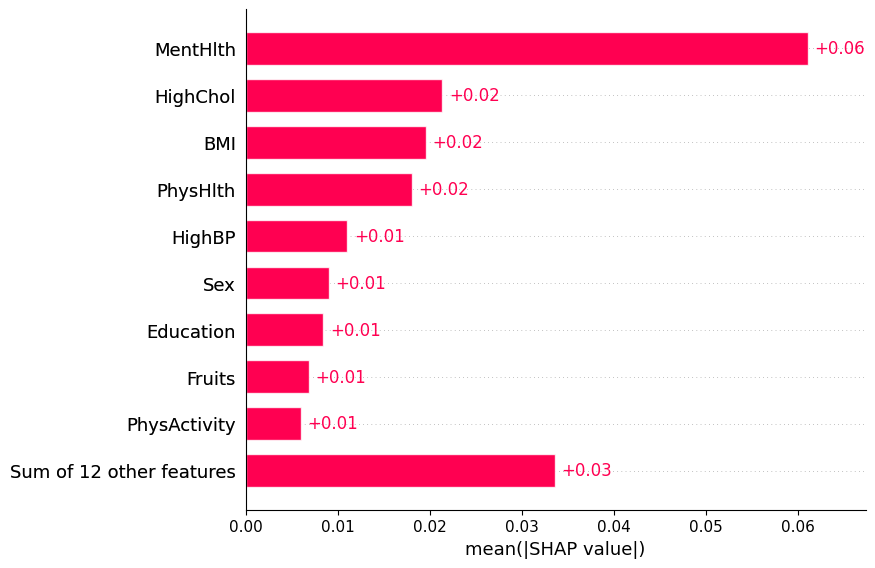

In [49]:
shap.plots.bar(shap_values)

In [60]:
formula = "Diabetes_binary ~"
for col in X_train.columns:
    formula += " + "
    formula += col
model = smf.logit(formula, data=df_train).fit()

Optimization terminated successfully.
         Current function value: 0.508543
         Iterations 6


In [61]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:        Diabetes_binary   No. Observations:                 9000
Model:                          Logit   Df Residuals:                     8978
Method:                           MLE   Df Model:                           21
Date:                Mon, 22 Apr 2024   Pseudo R-squ.:                  0.2663
Time:                        14:54:02   Log-Likelihood:                -4576.9
converged:                       True   LL-Null:                       -6238.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -6.7408      0.340    -19.808      0.000      -7.408      -6.074
HighBP                   0.8218      0.055     14.849      0.000       0.713       0.930
HighChol    

In [62]:
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

PermutationExplainer explainer: 1001it [02:17,  6.64it/s]                       


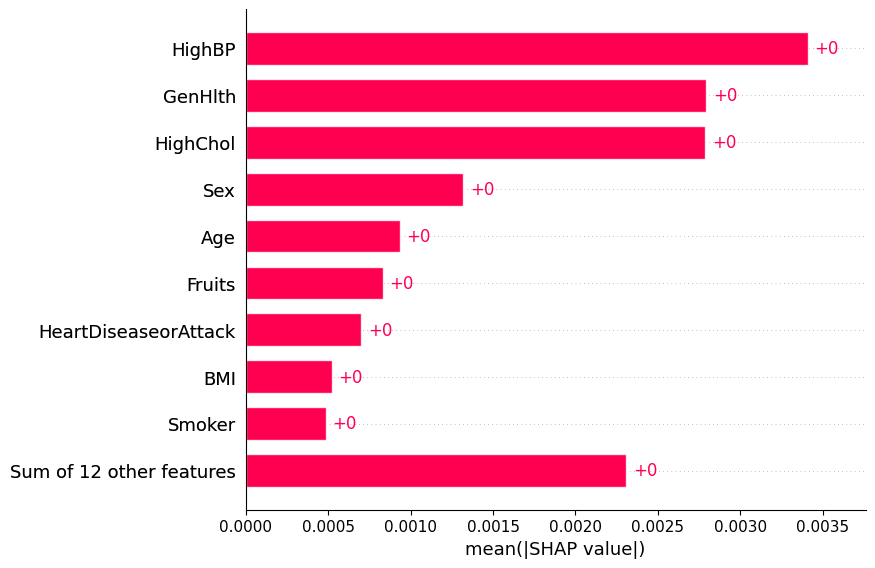

In [63]:
shap.plots.bar(shap_values)

In [64]:
y_pred_k = model.predict(X_test)

Accuracy:  0.52
Specificity:  1.0
Recall:  0.0
F1 Score: 0.0


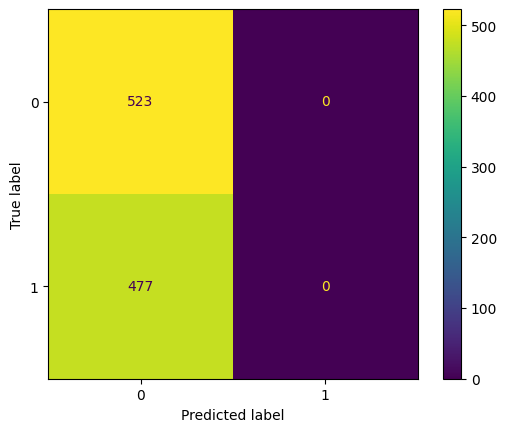

In [65]:
y_pred_kb = (y_pred_k >= 0.5)*1
scores(y_test, y_pred_kb)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_kb)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot()
plt.show()

In [66]:
df_trans = df_full.copy()

for column in numeric_cols:
    df_trans[column] = robust_data_scaling_2(df_trans[column], 
                                            transform_dict[column][0], 
                                            transform_dict[column][1], 
                                            transform_dict[column][2])

In [67]:
df_trans.describe().transpose()

count      mean       std    min    25%   50%  \
Diabetes_binary       253680.0  0.139333  0.346294  0.000  0.000  0.00   
HighBP                253680.0  0.429001  0.494934  0.000  0.000  0.00   
HighChol              253680.0  0.424121  0.494210  0.000  0.000  0.00   
CholCheck             253680.0  0.962670  0.189571  0.000  1.000  1.00   
BMI                   253680.0 -0.077205  0.826087 -2.125 -0.625 -0.25   
Smoker                253680.0  0.443169  0.496761  0.000  0.000  0.00   
Stroke                253680.0  0.040571  0.197294  0.000  0.000  0.00   
HeartDiseaseorAttack  253680.0  0.094186  0.292087  0.000  0.000  0.00   
PhysActivity          253680.0  0.756544  0.429169  0.000  1.000  1.00   
Fruits                253680.0  0.634256  0.481639  0.000  0.000  1.00   
Veggies               253680.0  0.811420  0.391175  0.000  1.000  1.00   
HvyAlcoholConsump     253680.0  0.056197  0.230302  0.000  0.000  0.00   
AnyHealthcare         253680.0  0.951053  0.215759  0.000  1.000  1.00   
NoDocbcCost           253680.0  0.084177  0.277654  0.000  0.000  0.00   
GenHlth               253680.0 -0.244304  0.534239 -1.000 -0.500 -0.50   
MentHlth              253680.0  1.061591  2.470949  0.000  0.000  0.00   
PhysHlth              253680.0  0.606012  1.245422  0.000  0.000  0.00   
DiffWalk              253680.0  0.168224  0.374066  0.000  0.000  0.00   
Sex                   253680.0  0.440342  0.496429  0.000  0.000  0.00   
Age                   253680.0 -0.241970  0.763555 -2.000 -0.750 -0.25   
Education             253680.0  0.025217  0.492887 -2.000 -0.500  0.00   
Income                253680.0  0.013469  0.517787 -1.250 -0.250  0.25   

                           75%        max  
Diabetes_binary       0.000000   1.000000  
HighBP                1.000000   1.000000  
HighChol              1.000000   1.000000  
CholCheck             1.000000   1.000000  
BMI                   0.250000   8.625000  
Smoker                1.000000   1.000000  
Stroke                0.000000   1.000000  
HeartDiseaseorAttack  0.000000   1.000000  
PhysActivity          1.000000   1.000000  
Fruits                1.000000   1.000000  
Veggies               1.000000   1.000000  
HvyAlcoholConsump     0.000000   1.000000  
AnyHealthcare         1.000000   1.000000  
NoDocbcCost           0.000000   1.000000  
GenHlth               0.000000   1.000000  
MentHlth              0.666667  10.000000  
PhysHlth              0.428571   4.285714  
DiffWalk              0.000000   1.000000  
Sex                   1.000000   1.000000  
Age                   0.250000   1.000000  
Education             0.500000   0.500000  
Income                0.500000   0.500000

In [68]:
y_pred_k = model.predict(df_full.drop(labels=["Diabetes_binary"], axis=1))

Accuracy:  0.73
Specificity:  0.73
Recall:  0.76
F1 Score: 0.44


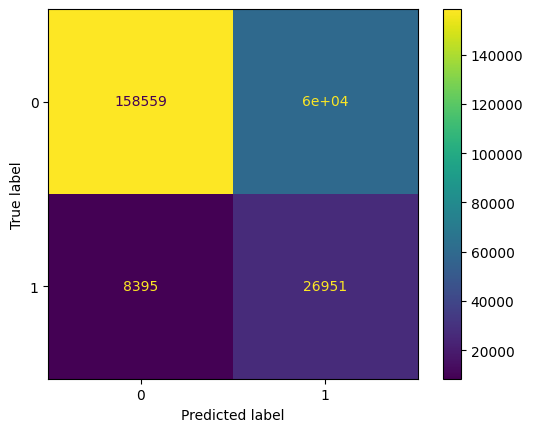

In [69]:
y_pred_kb = (y_pred_k >= 0.5)*1
scores(df_full["Diabetes_binary"], y_pred_kb)
conf_matrix = confusion_matrix(y_true=df_full["Diabetes_binary"], y_pred=y_pred_kb)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot()
plt.show()

## Phase 5: Final Report  

* Please submit a PDF of your final report.
* 10/12 pages at most.
* Should include abstract and conclusion (each 250 words minimum).
* It should contain the important findings in each phase of your project.
* Your final/best model should be evaulated using ROC and AUC
* Your report should NOT include the results of your Phase II.
* Your tables and figures should be numbered and captioned (labelled) appropriately.
* Submit a link to your final Notebook. Optionally, you are welcome to host your project (and report) at Github (i.e., no extra points for hosting). .

In [75]:
A = sum([50, 54, 42, 35, 50, 43, 85])
A_d = sum([50, 55, 60, 45, 50, 43, 85])
MT = 85/90
Lead = .9
Revies = 1
Present = 1
Milestones = 1

-0.9134077892325315

In [79]:
85/90

0.9444444444444444